# Local functions

In [1]:
from BLOCH_beamline import *

data_folder = Path('Data')

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

from IPython.display import HTML, display
display(HTML('<style>div.text_cell_render{font-family:"Linux Libtertine O";font-size:13pt}</style>'))
display(HTML('<style>.CodeMirror{font-size:9pt}</style>'))

---- BLOCH beamline ----
	Last updated 02.13.2018 

	Latest change: Simple resolution calculators



In [2]:
from lmfit import minimize, Parameters

###########################
def residual(params, x, y):
###########################
	return (y-Gauss(params,x))

########################
def Gauss(params,x):
########################    
    amplitude = params['amplitude'].value
    center = params['center'].value
    width = params['width'].value
    offset = params['offset'].value

    model = offset + (amplitude*np.exp(-(x-center)**2/(2.*width**2))) 

    return model

########################  
def quickGaussFit(x,y):
########################  
    x_center = x[np.argmax(y)]
    half_height=(max(y))-((max(y)-min(y))/2)
    half_height_y_index=(np.abs(y-half_height).argmin())
    half_width = np.abs(x_center-x[half_height_y_index])

    params = Parameters()
    params.add('amplitude', 	value=max(y)-min(y), vary=True)
    params.add('width', 	value=2*half_width,vary=True)
    params.add('center', 	value=x_center,vary=True)
    params.add('offset', 	value=min(y),vary=True)
    
    out = minimize(residual, params,args=(x, y),method='leastsq')
    
    fittedCurve=Gauss(out.params,x)
    return fittedCurve,out.params


########################  
def GaussFitReducedRange(x,y):
########################  
    x_center = x[np.argmax(y)]
    half_height=(max(y))-((max(y)-min(y))/2)
    half_height_y_index=(np.abs(y-half_height).argmin())
    half_width = np.abs(x_center-x[half_height_y_index])
    mask = [(ii>(x_center-half_width) and ii<(x_center+half_width)) for ii in x]     
    x_subrange = [element for index,element in enumerate(x) if mask[index]]
    y_subrange = [element for index,element in enumerate(y) if mask[index]]

    params = Parameters()
    params.add('amplitude', 	value=max(y)-min(y), vary=True)
    params.add('width', 	value=2*half_width,vary=True)
    params.add('center', 	value=x_center,vary=True)
    params.add('offset', 	value=min(y),vary=True)
    
    out = minimize(residual, params,args=(x_subrange, y_subrange),method='leastsq')
    
    fittedCurve=Gauss(out.params,x_subrange)
    return fittedCurve,x_subrange,out.params

########################  
def GaussFitSpecial(x,y):
########################  
    x_center = 11.05
    half_height=(max(y))-((max(y)-min(y))/2)
    half_height_y_index=(np.abs(y-half_height).argmin())
    half_width = 0.3
    #print(x_center,half_)
    mask = [(ii>(x_center-half_width) and ii<(x_center+half_width)) for ii in x]     
    x_subrange = [element for index,element in enumerate(x) if mask[index]]
    y_subrange = [element for index,element in enumerate(y) if mask[index]]

    params = Parameters()
    params.add('amplitude', 	value=1.5e-12, vary=True)
    params.add('width', 	value=2*half_width,vary=True)
    params.add('center', 	value=x_center,vary=True)
    params.add('offset', 	value=min(y),vary=True)
    
    out = minimize(residual, params,args=(x_subrange, y_subrange),method='leastsq')
    
    fittedCurve=Gauss(out.params,x_subrange)
    return fittedCurve,x_subrange,out.params

########################
def maxInSubset(xwave,ywave,xstart,xstop):
########################
    maximum=0
    maximum_index=0
    for index,x in enumerate(xwave):
        if x>=xstart and maximum<ywave[index] and x<=xstop:
            maximum=ywave[index]
            maximum_index=index
            
    return maximum,xwave[maximum_index]

# What are we looking for?

If we want photons of a certain energy from the undulator, we need to know what gap to set. Typically we will be following first harmonic peaks, but it's not clear whether at higher energies we should use third harmonics or switch to 'wiggler mode'.

In the undulator spectra below (small acceptance) I'm highlighting the normal harmonics (red lines) and the quasi-third) green line. 

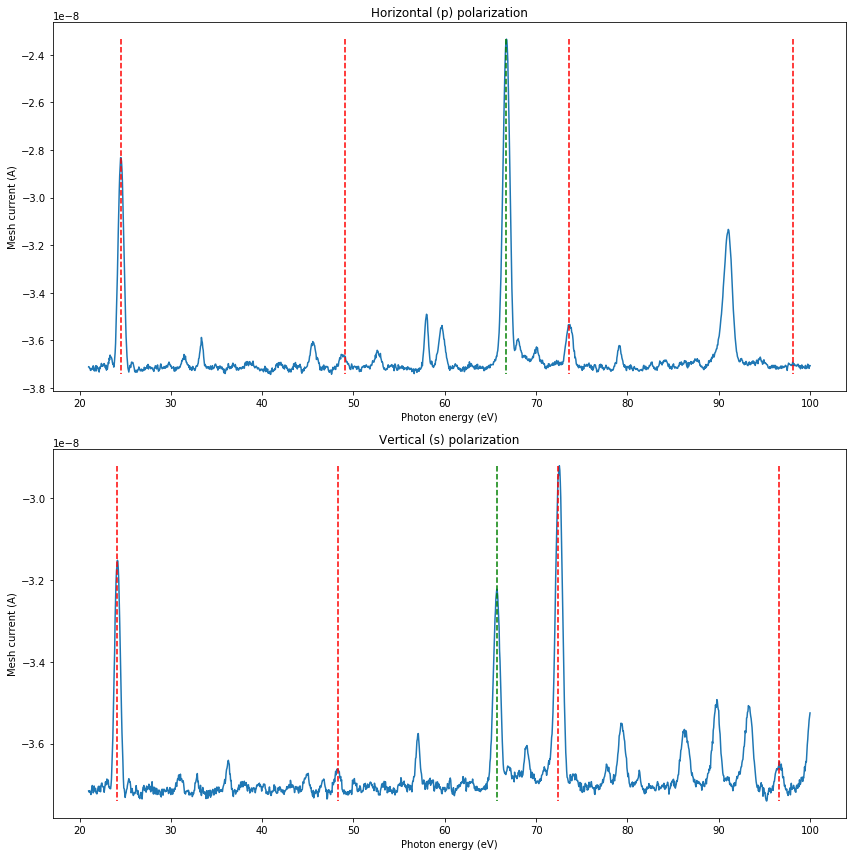

In [3]:
hpol = HDF5loadscan(data_folder/"19.01.21.higherOrder_tests.h5",99)
hpol['meshCurrent'] = [((ii)/1000) for ii in hpol['b110a_ctl_em02_ch01']]

vpol = HDF5loadscan(data_folder/"19.01.21.higherOrder_tests.h5",100)
vpol['meshCurrent'] = [((ii)/1000) for ii in vpol['b110a_ctl_em02_ch01']]

fig=plt.figure(figsize=(12,12))

plt.subplot(211)
plt.plot(hpol['mono_energy'],hpol['meshCurrent'])
fundamental=24.52
plotmax=np.array(hpol['meshCurrent']).max()
plotmin=np.array(hpol['meshCurrent']).min()
for order in range(1,5):
    plt.plot([fundamental*order,fundamental*order],[plotmax,plotmin],'r--')
  
plt.plot([fundamental*2.72,fundamental*2.72],[plotmax,plotmin],'g--')
plt.title("Horizontal (p) polarization")
plt.xlabel("Photon energy (eV)")
plt.ylabel("Mesh current (A)")


plt.subplot(212)

plt.plot(vpol['mono_energy'],vpol['meshCurrent'])
fundamental=24.15
plotmax=np.array(vpol['meshCurrent']).max()
plotmin=np.array(vpol['meshCurrent']).min()
for order in range(1,5):
    plt.plot([fundamental*order,fundamental*order],[plotmax,plotmin],'r--')
plt.plot([fundamental*2.72,fundamental*2.72],[plotmax,plotmin],'g--')
plt.title("Vertical (s) polarization")
plt.xlabel("Photon energy (eV)")
plt.ylabel("Mesh current (A)")
plt.tight_layout()

plt.show()

# Horizontal polarization (phase = 0)

## First order peaks (10-230eV)

For all of this preliminary mapping, I am using the mesh - we suspect that the diode is not large enough to catch everything at low energy - something to investigate again another day.

Exit slit is set to hgap=530,vgap=800, front end mask at 3.5mm. For now I am only interested in relative flux between different operation modes, so the exit slit settings aren't important provided they are consistent across measurements.

For each gap I can look at some older calibrations to predict where the peak is going to be. I measure twice, once with small (2mm) mono baffle aperture ('BDA') and once with fully open 15x15 baffles.

The dataset is spread over two different files:

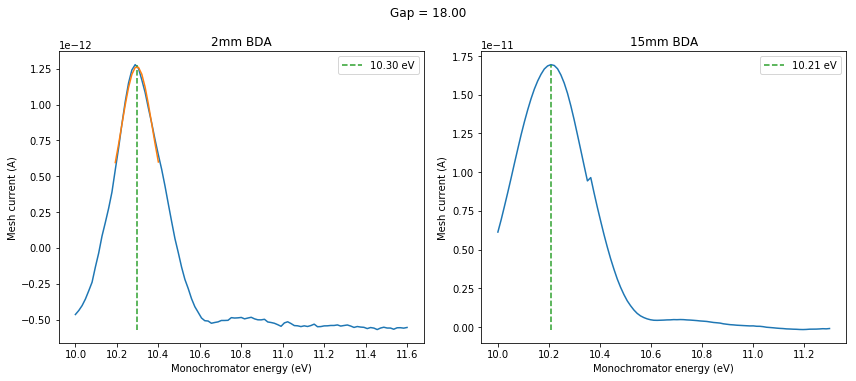

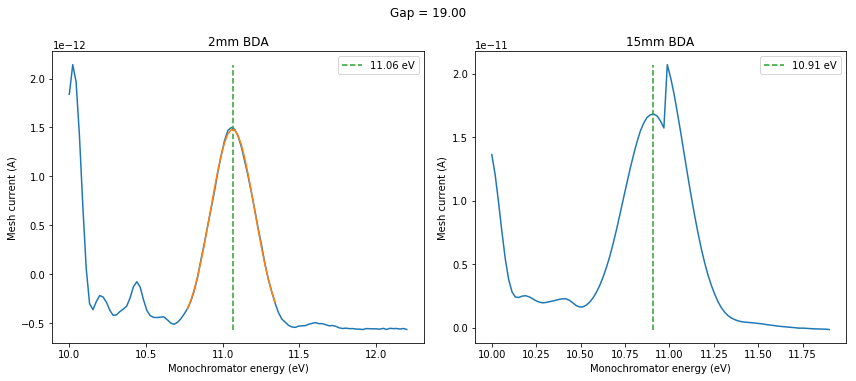

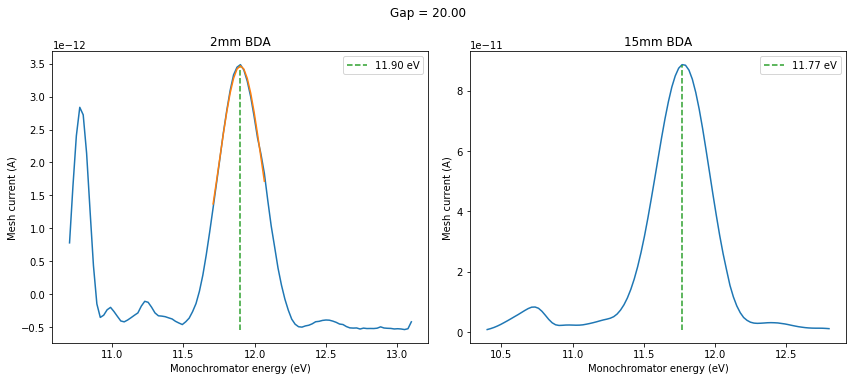

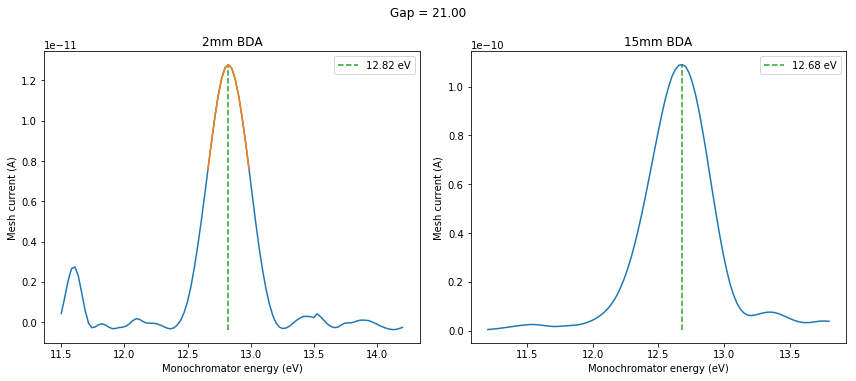

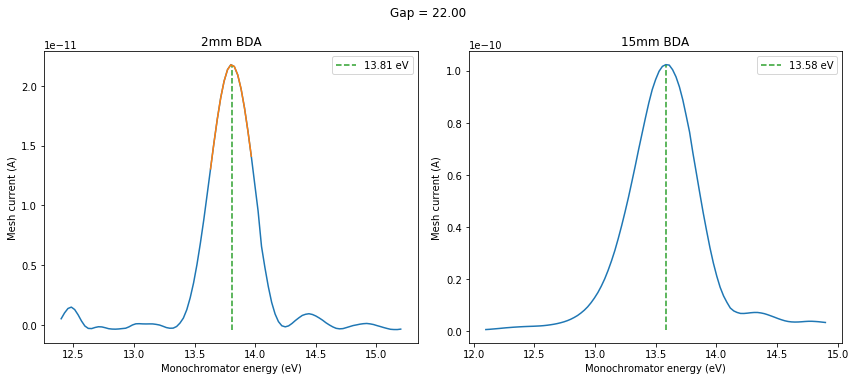

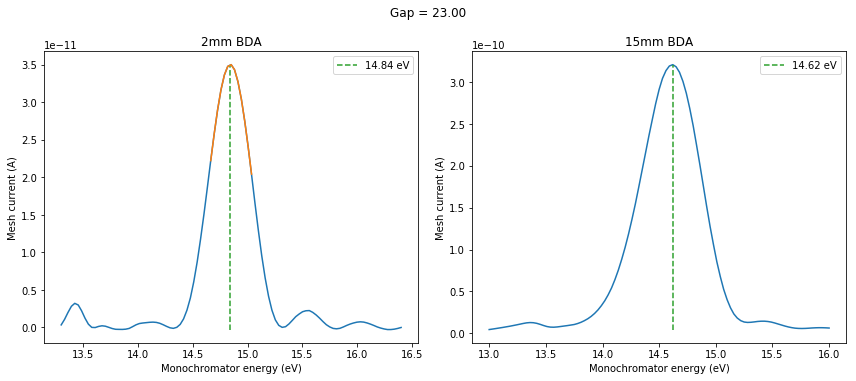

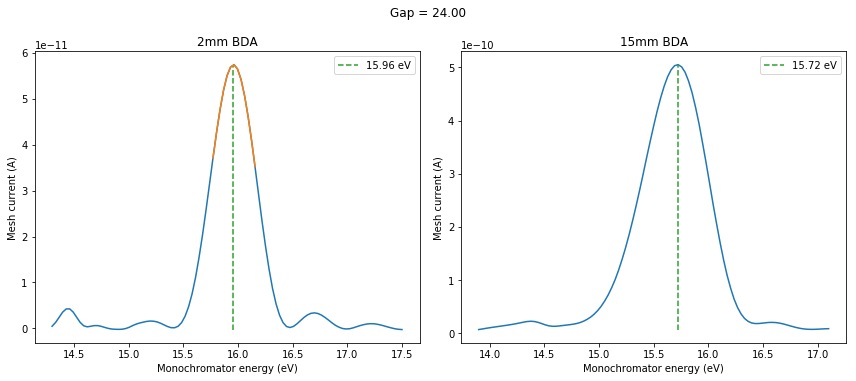

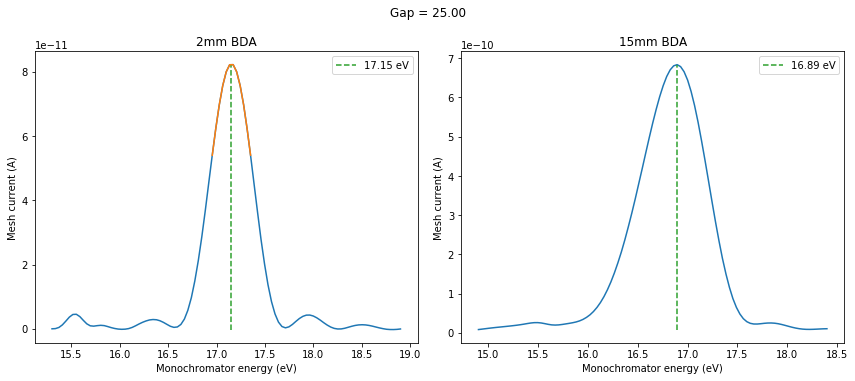

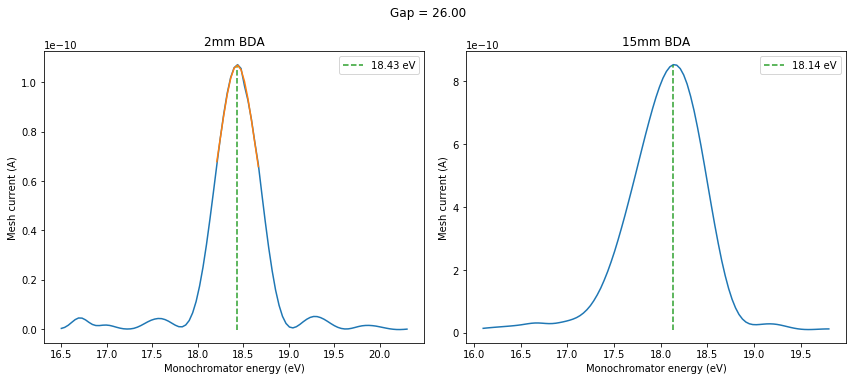

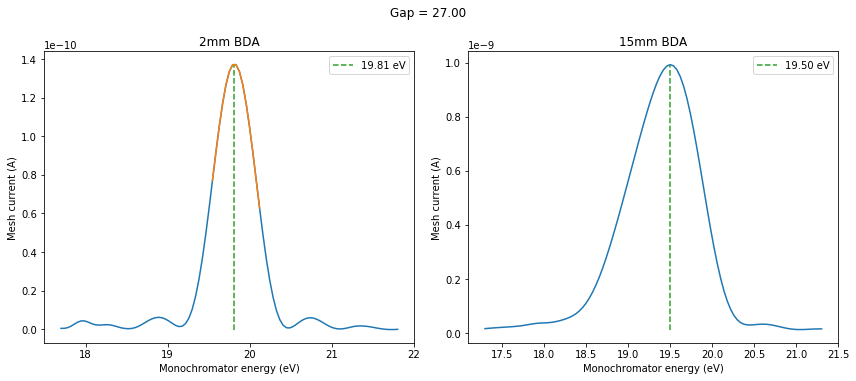

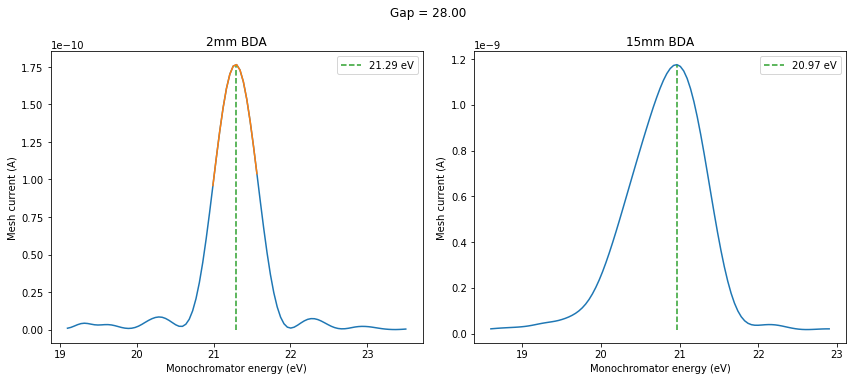

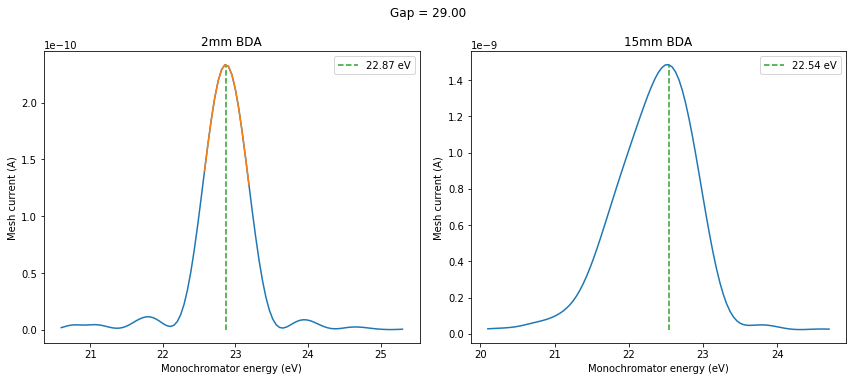

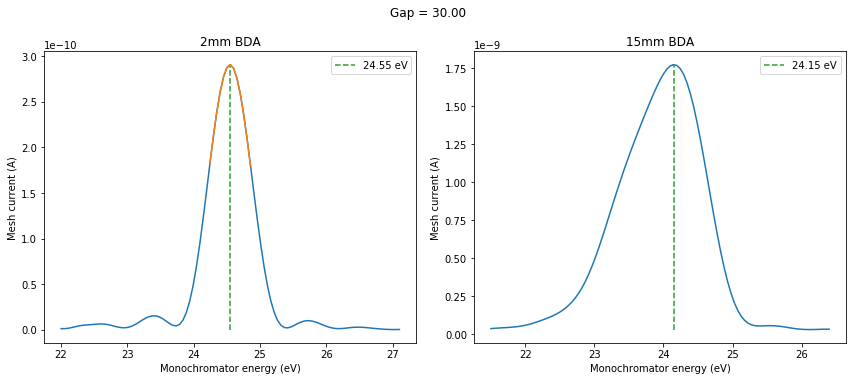

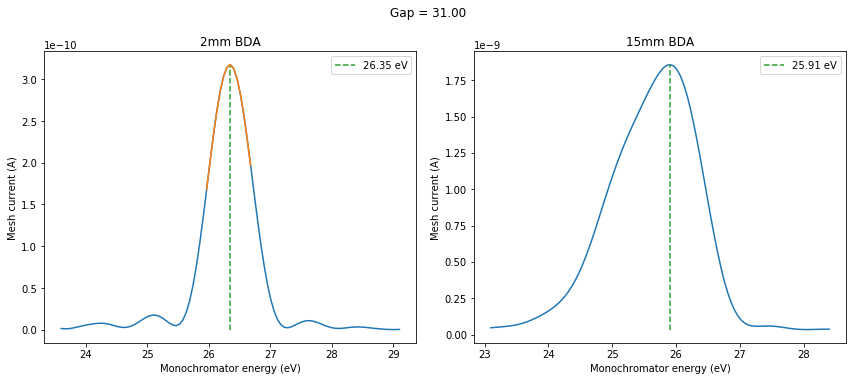

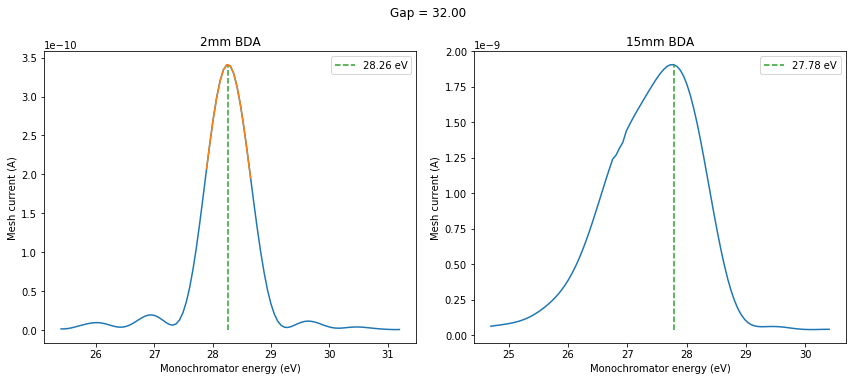

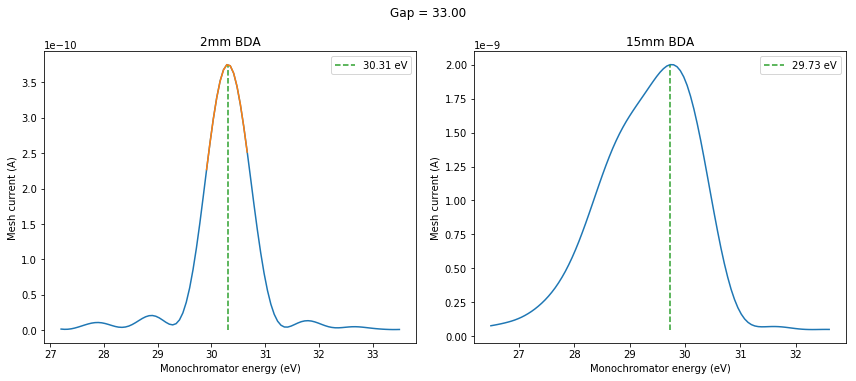

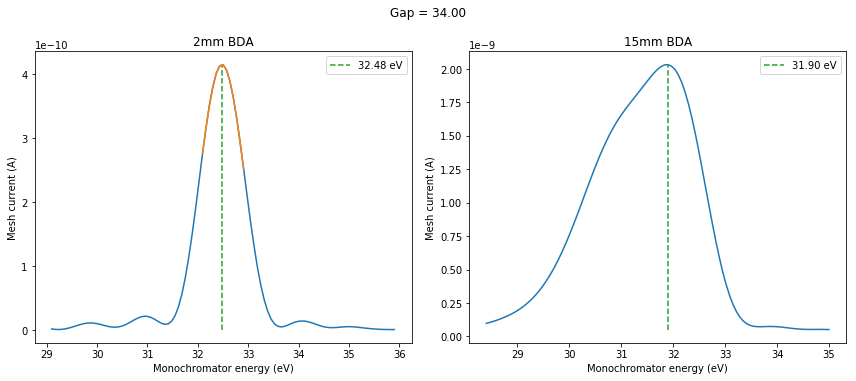

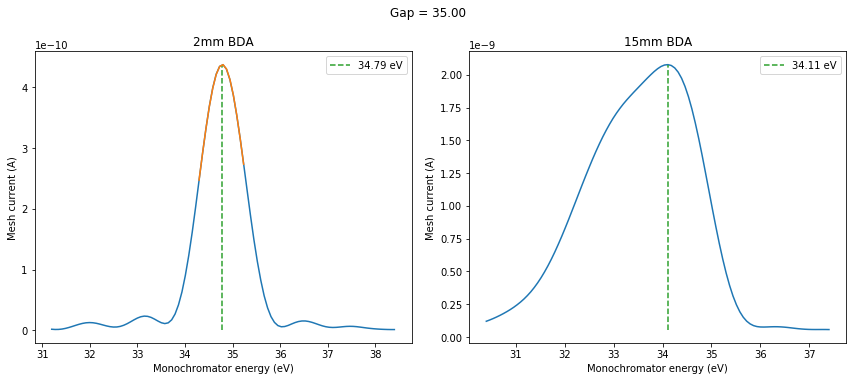

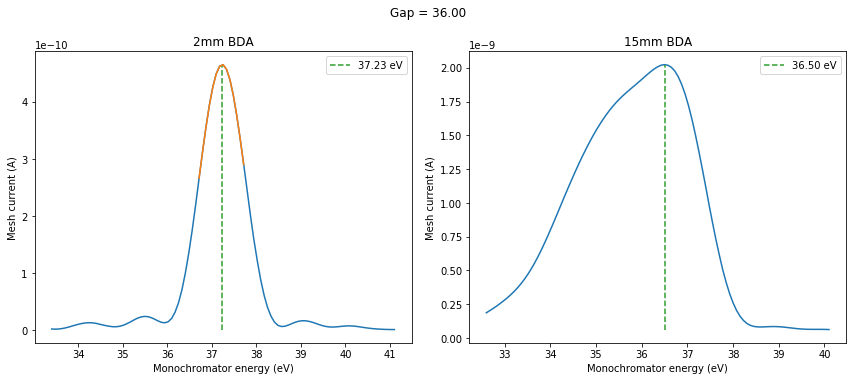

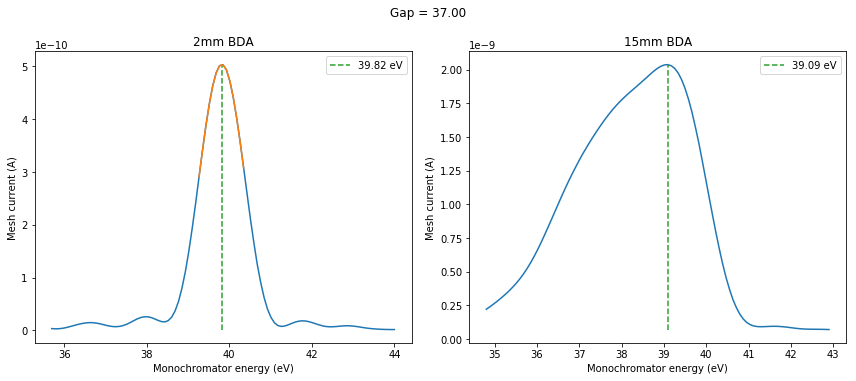

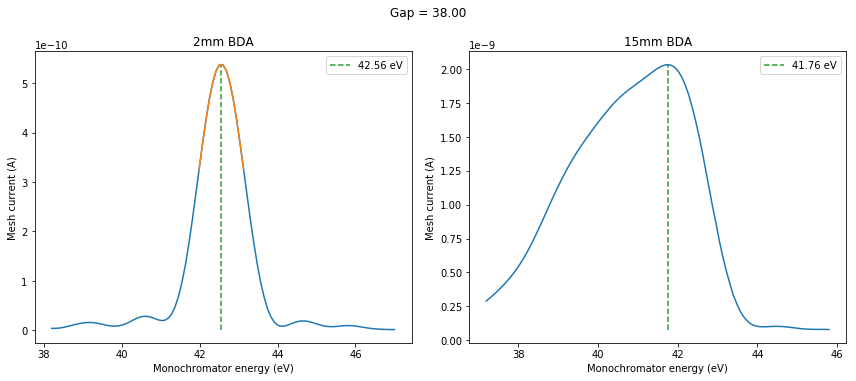

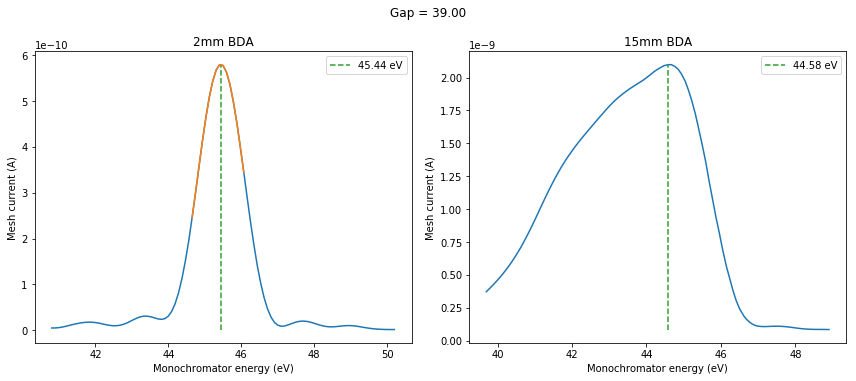

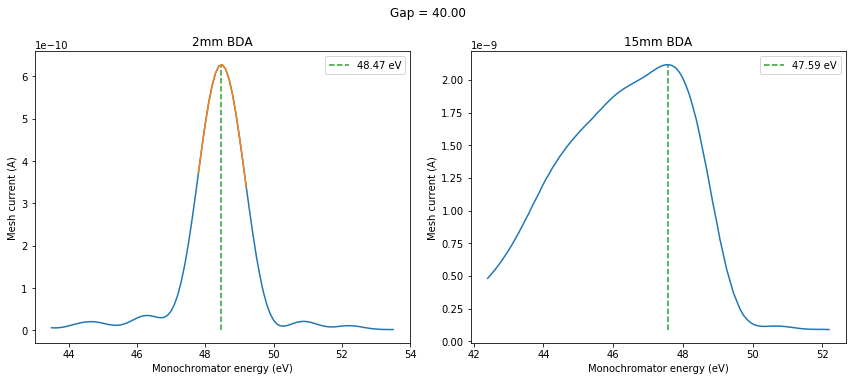

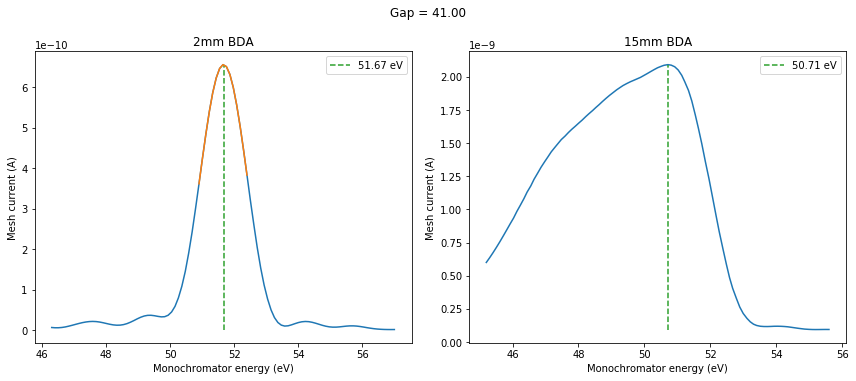

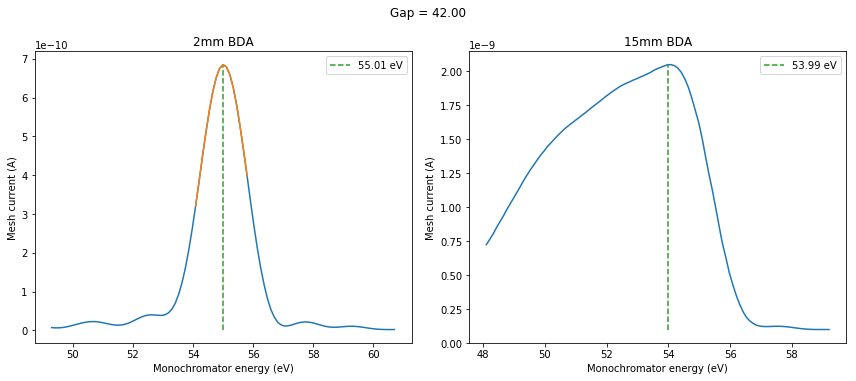

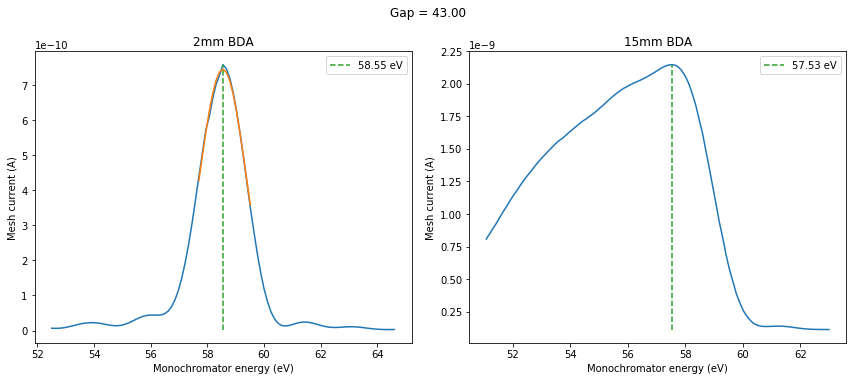

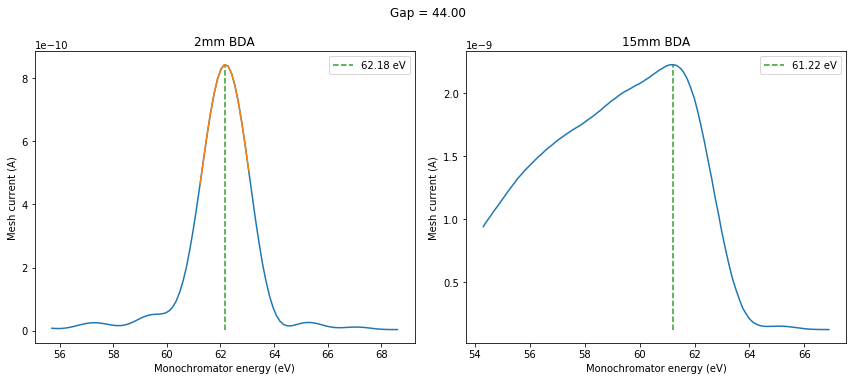

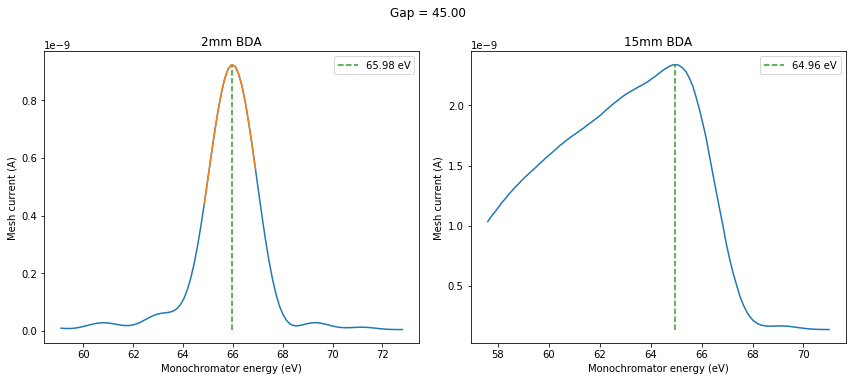

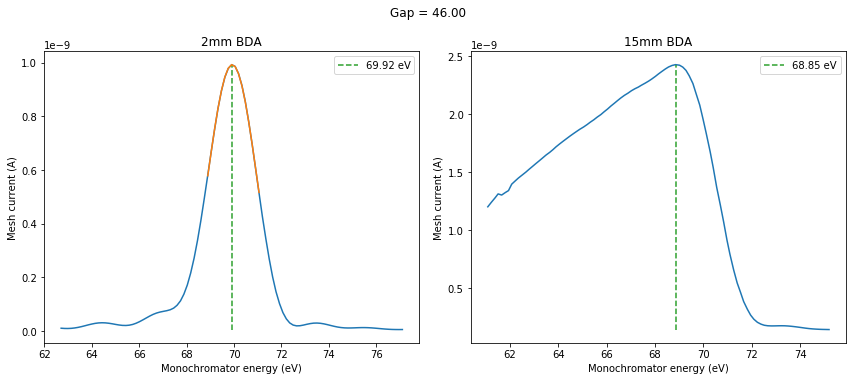

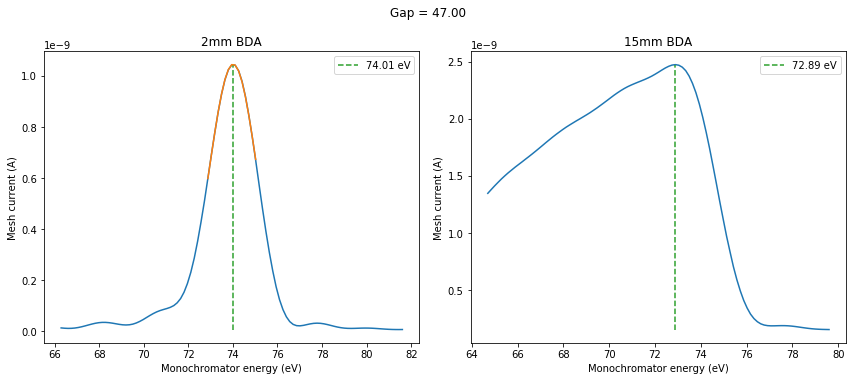

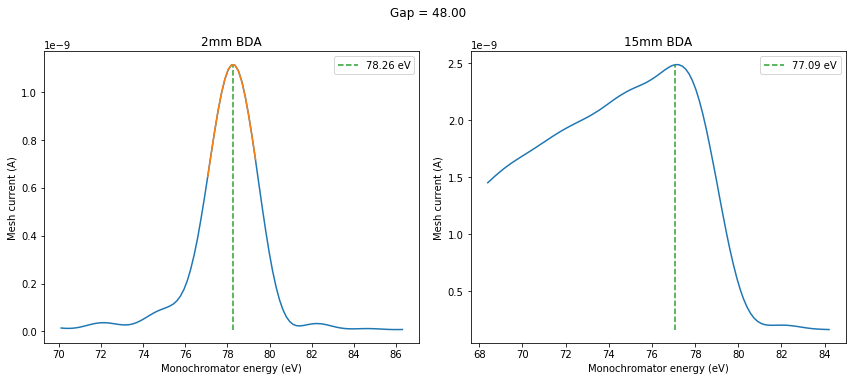

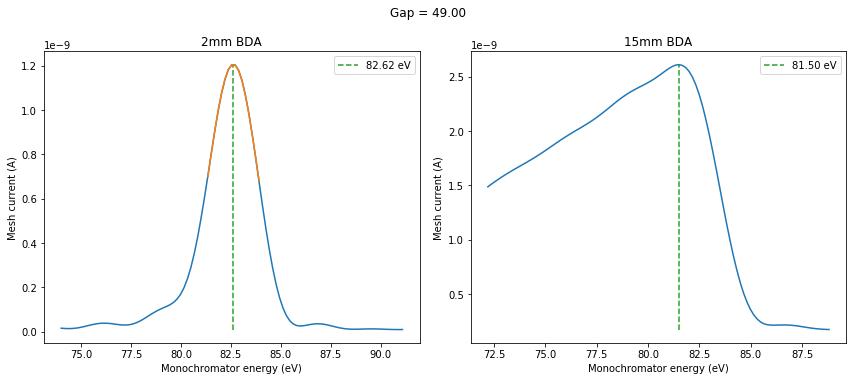

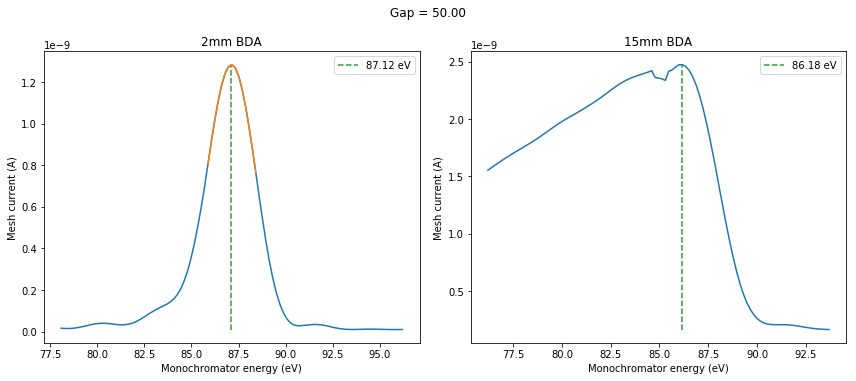

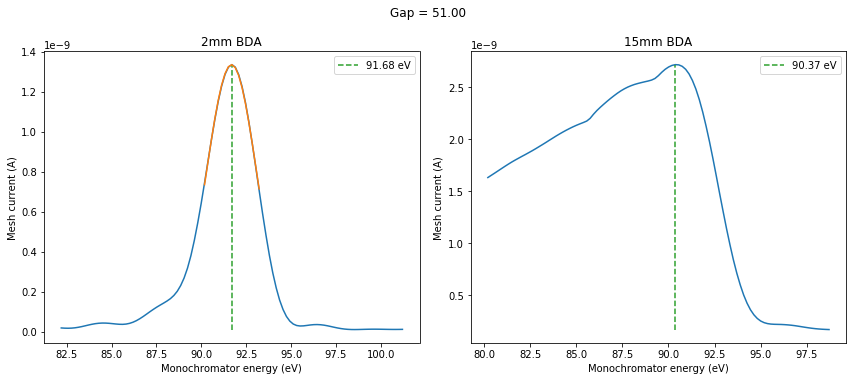

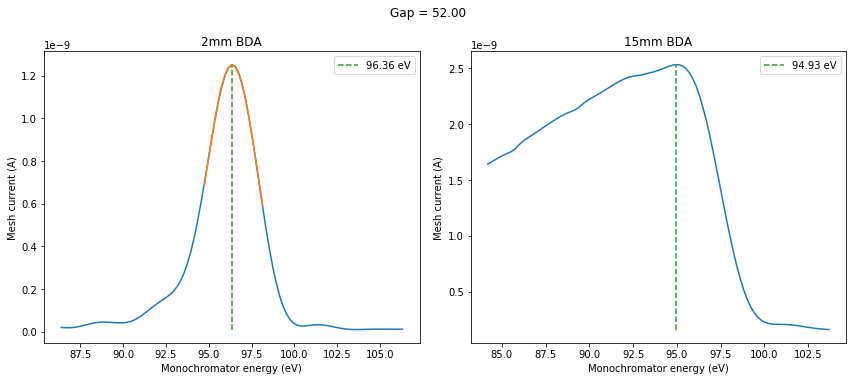

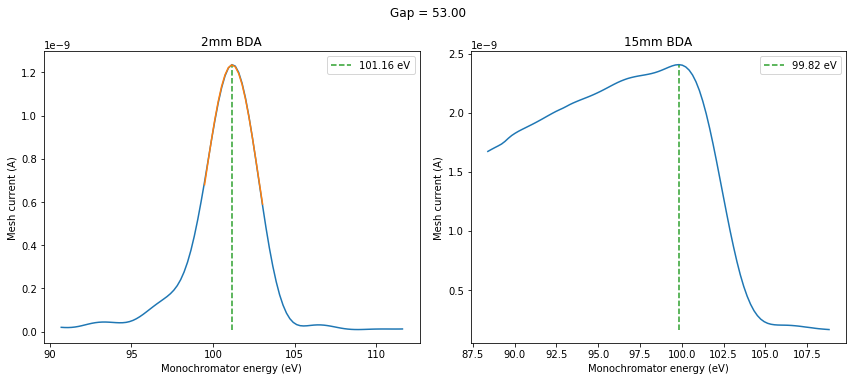

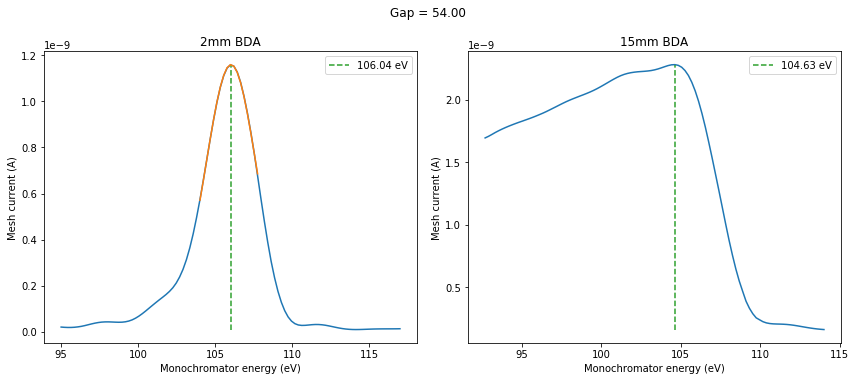

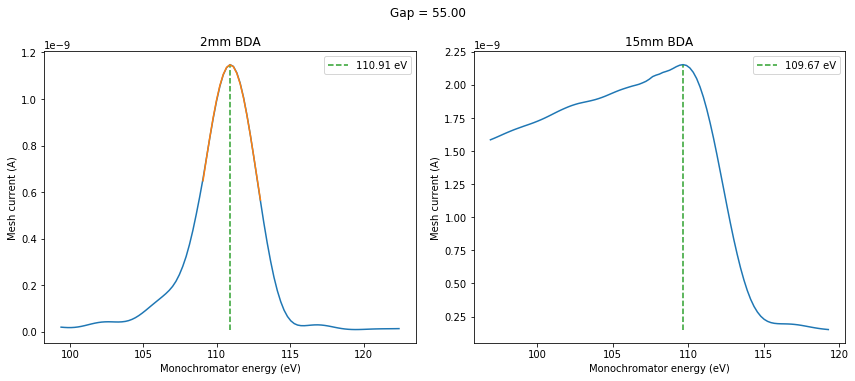

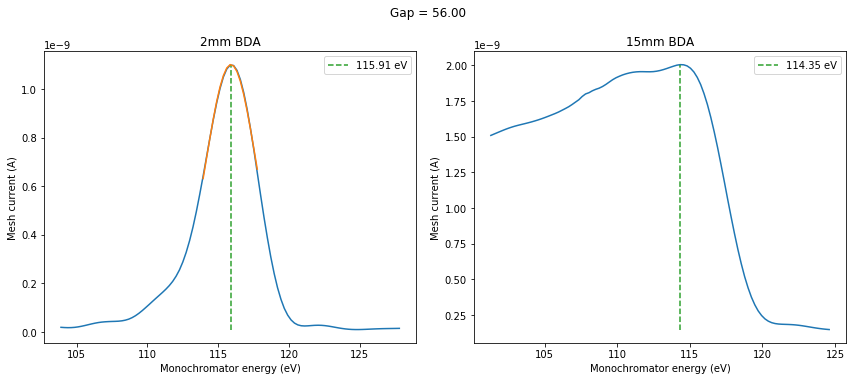

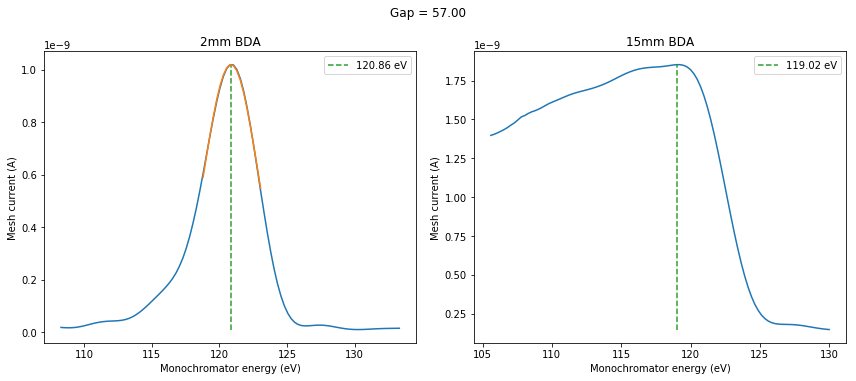

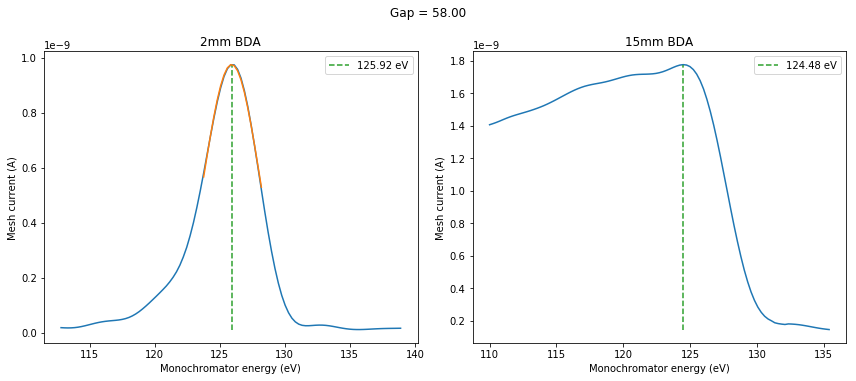

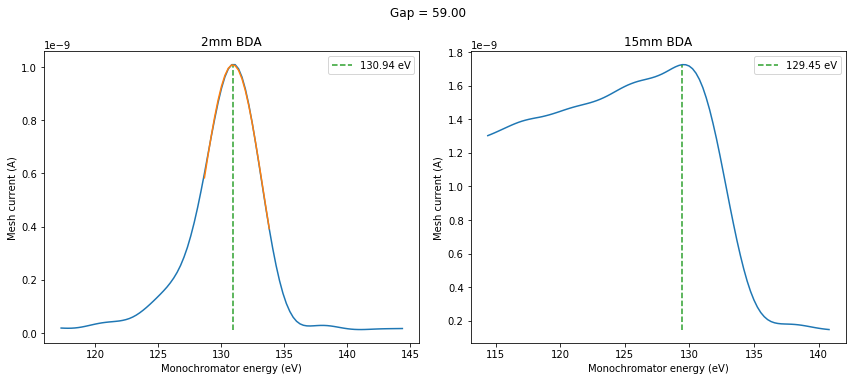

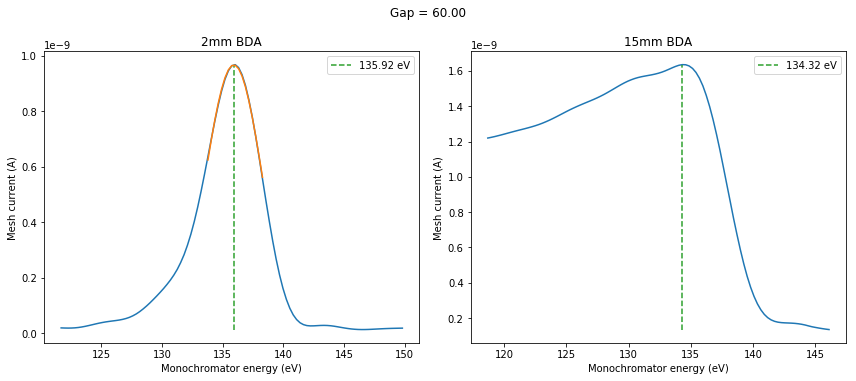

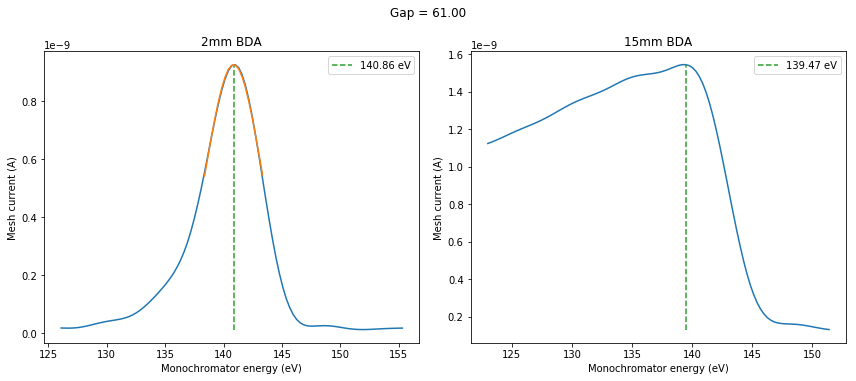

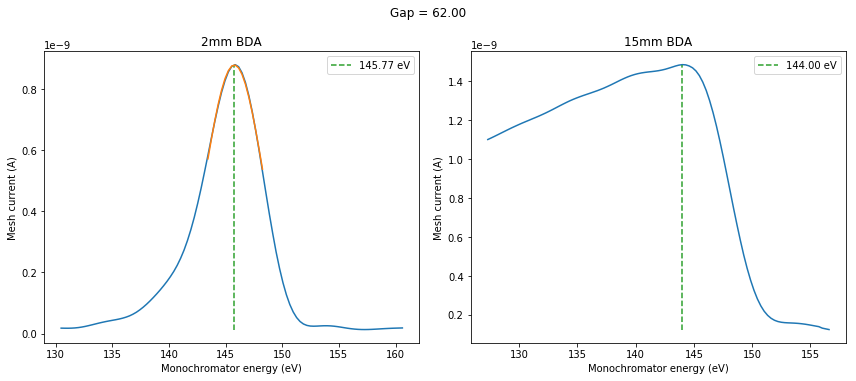

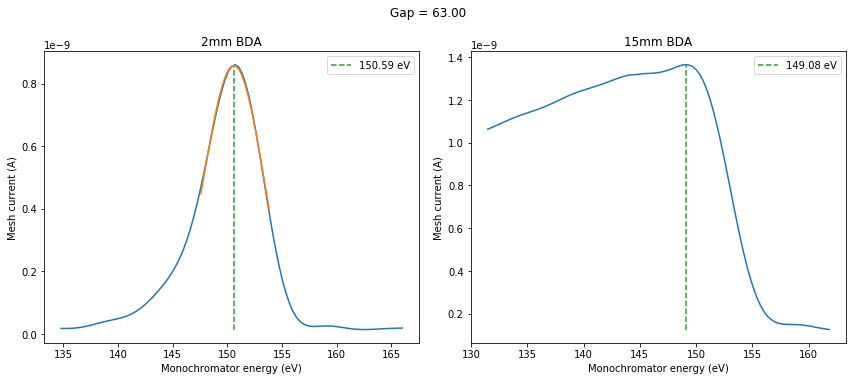

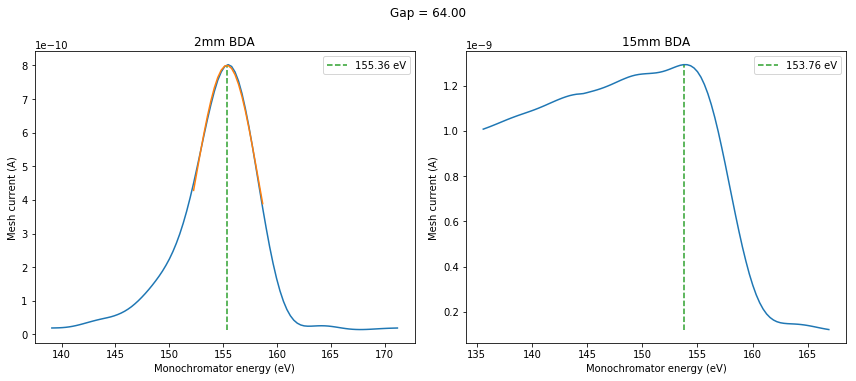

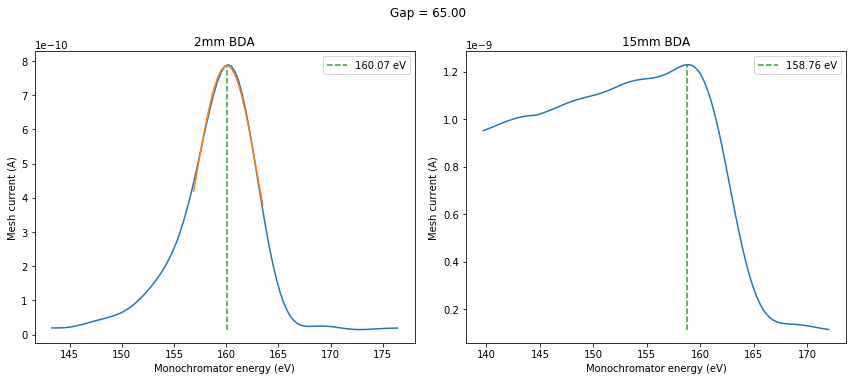

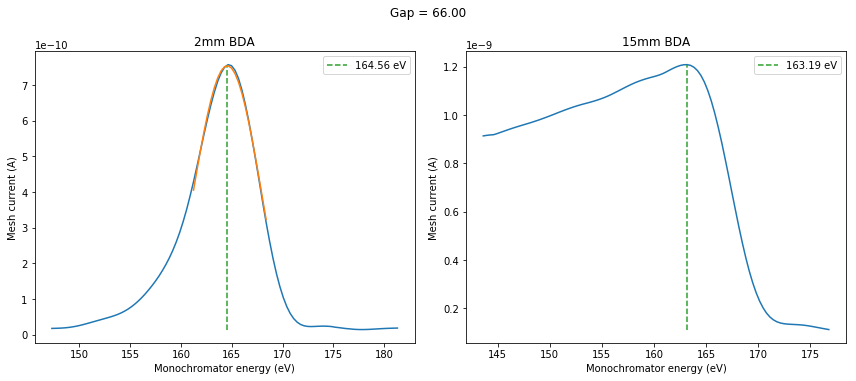

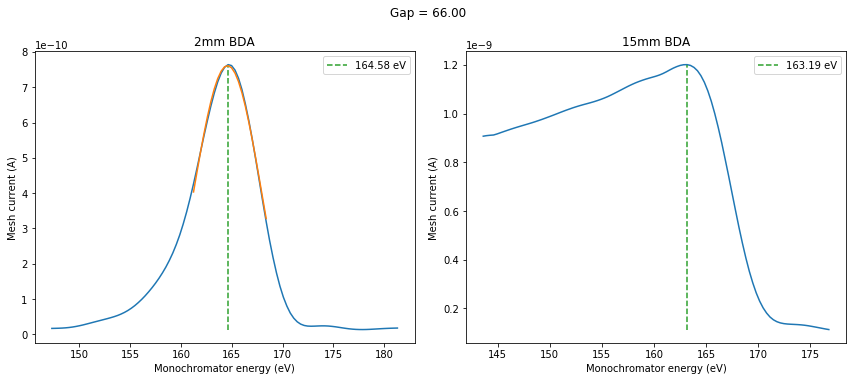

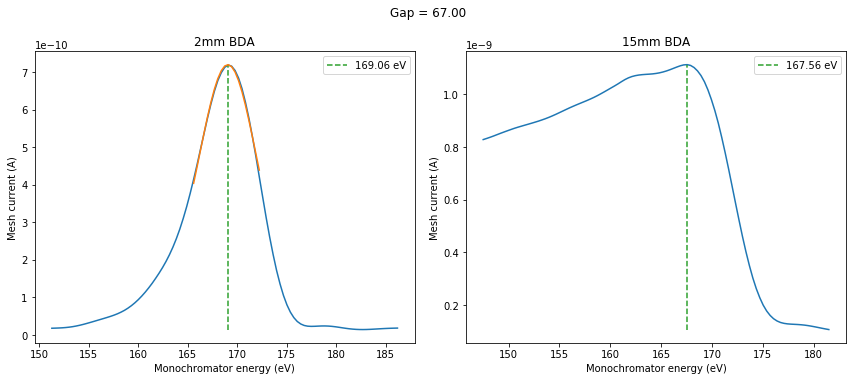

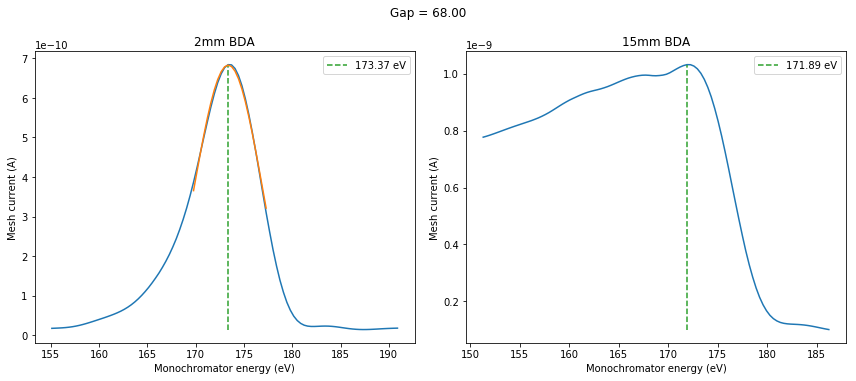

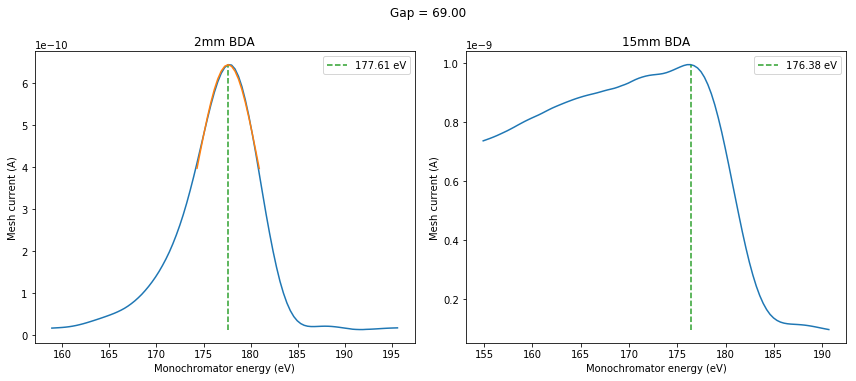

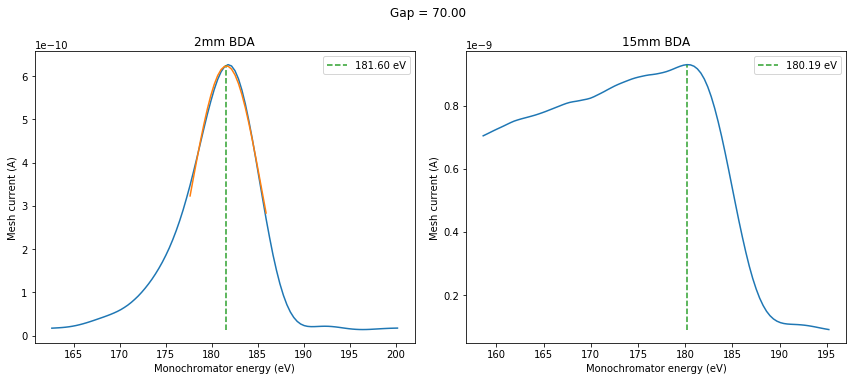

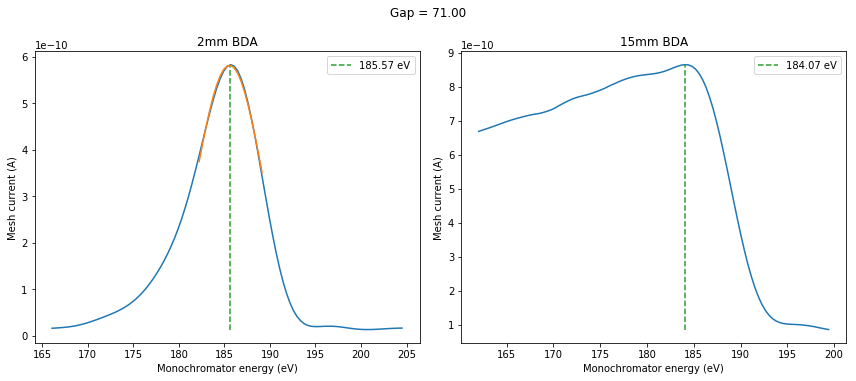

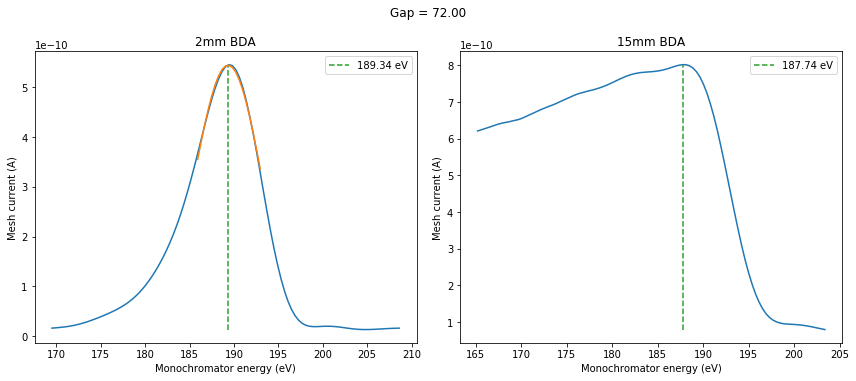

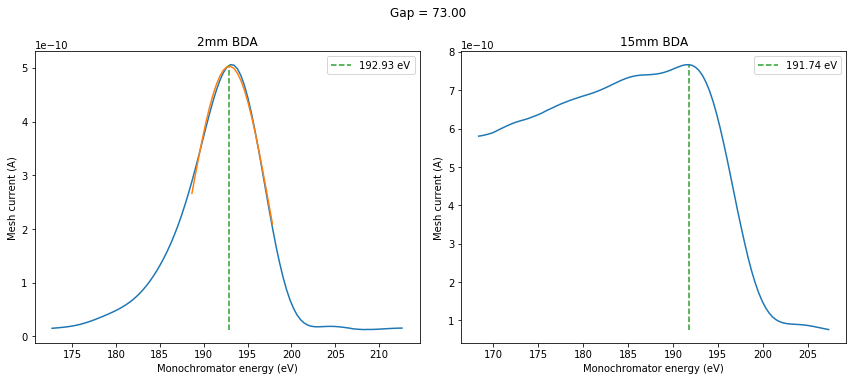

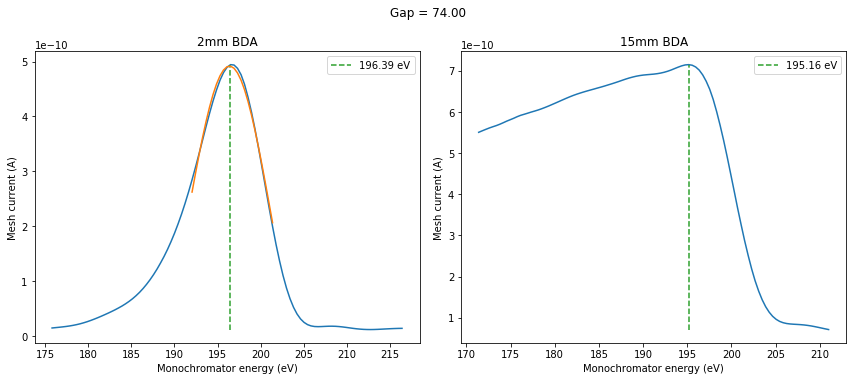

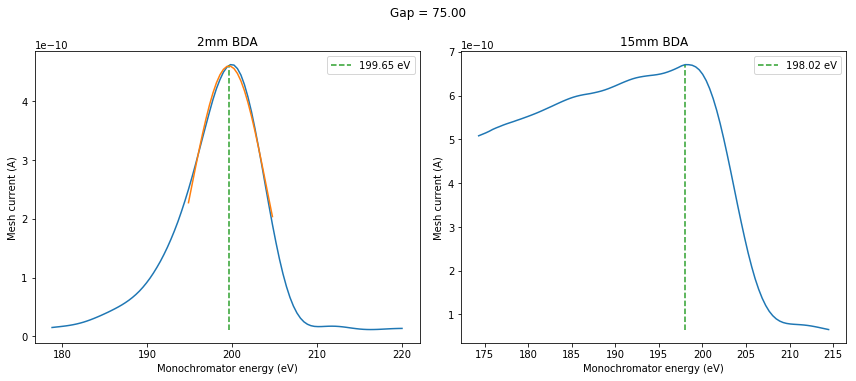

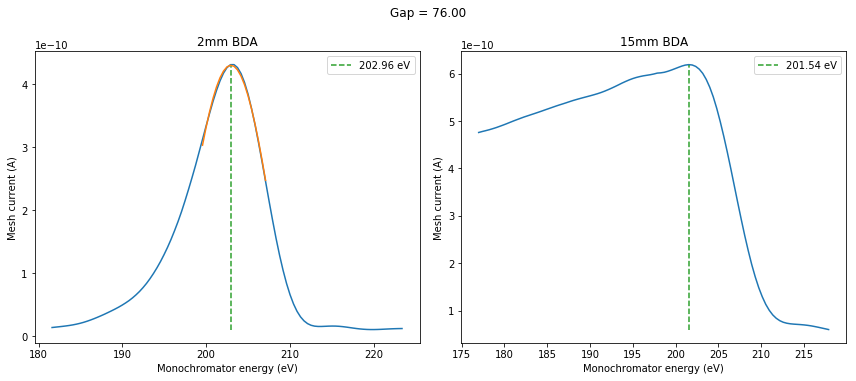

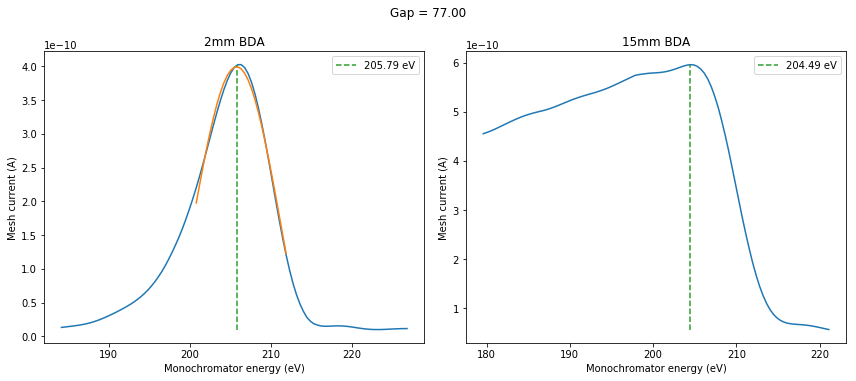

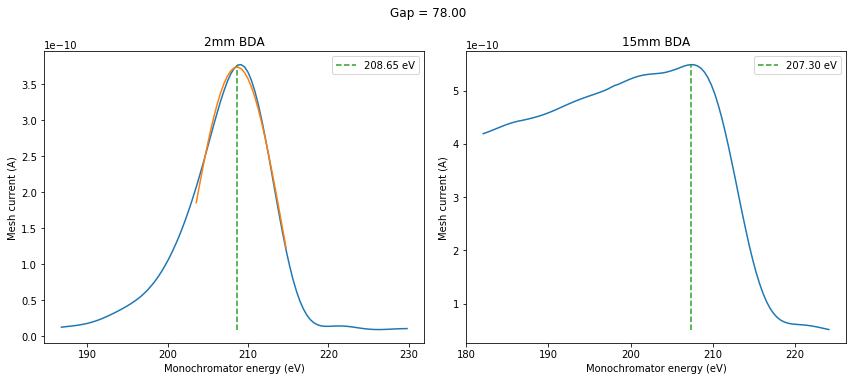

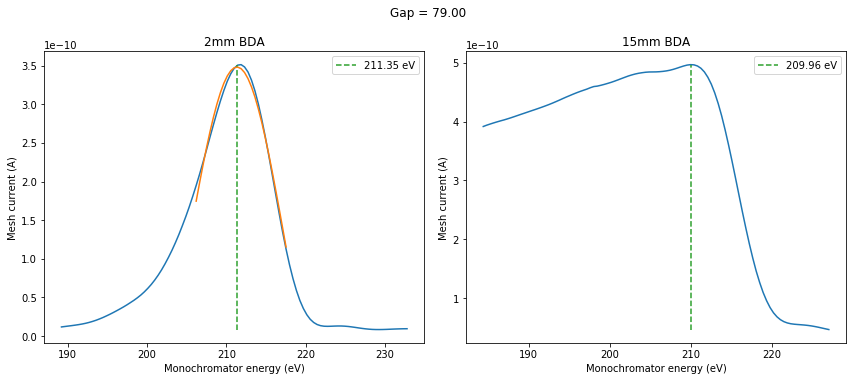

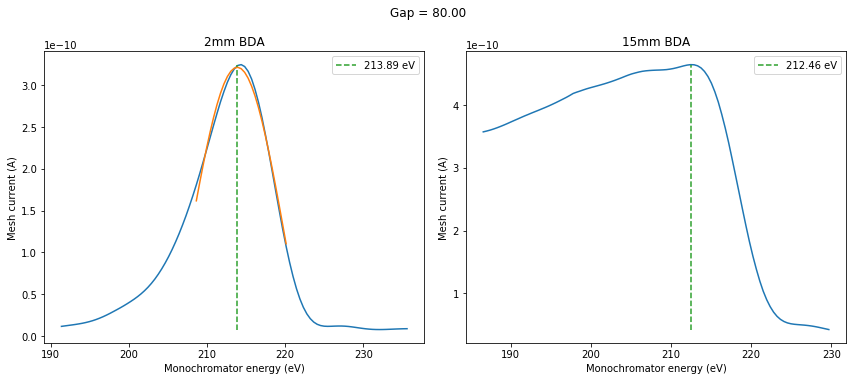

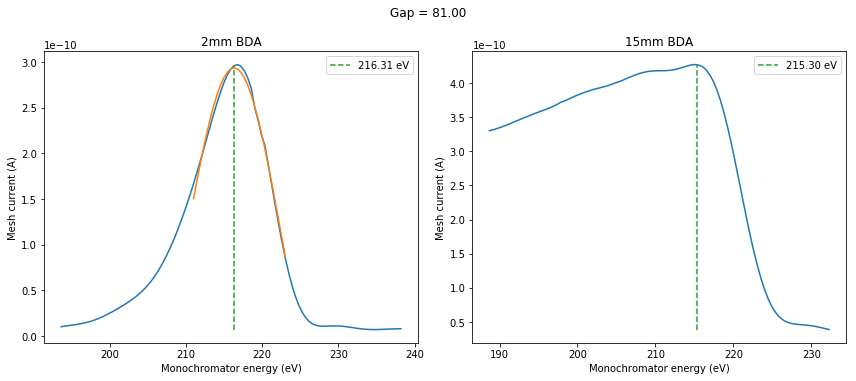

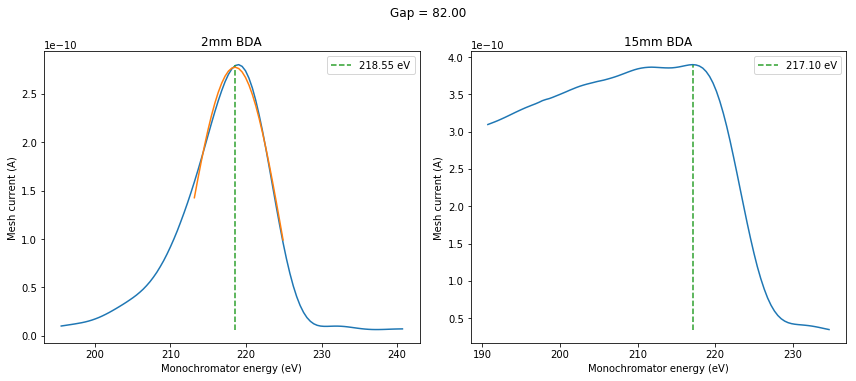

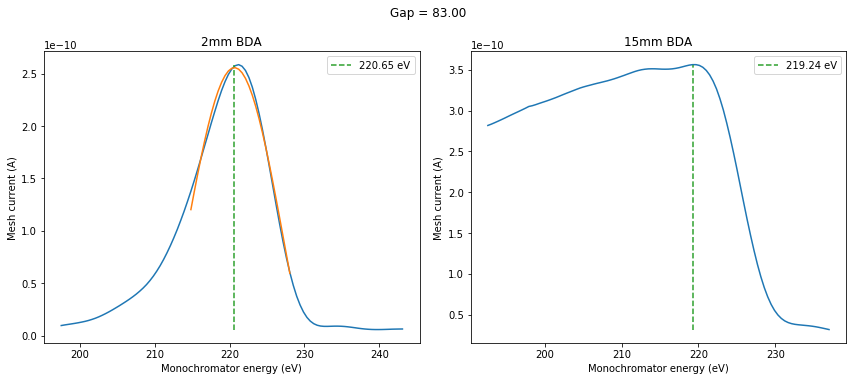

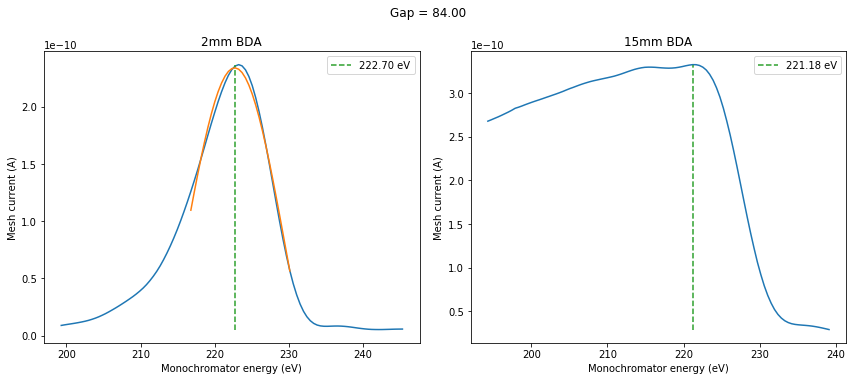

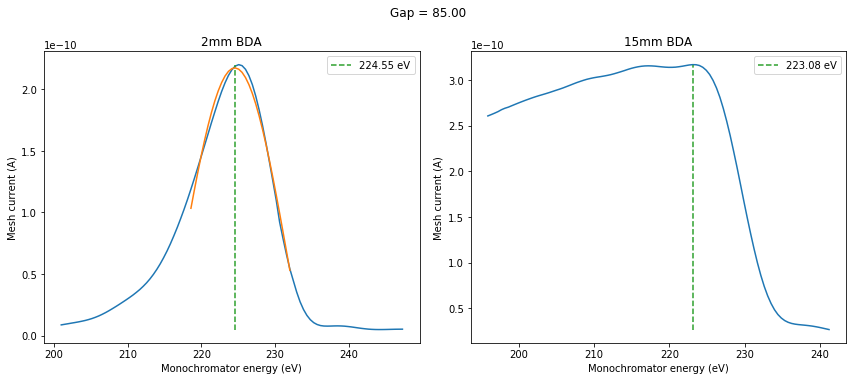

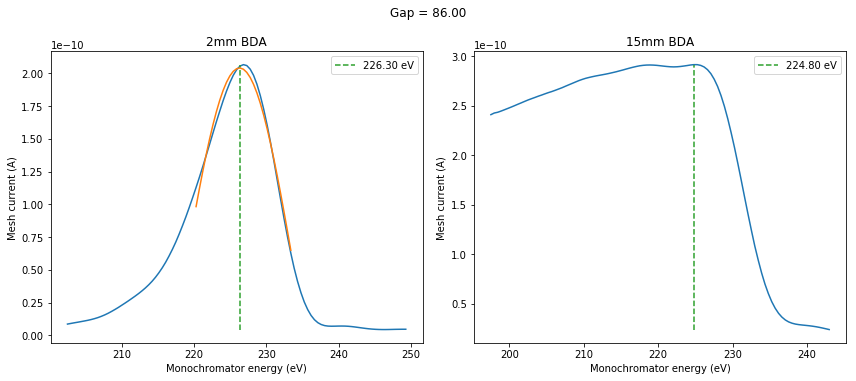

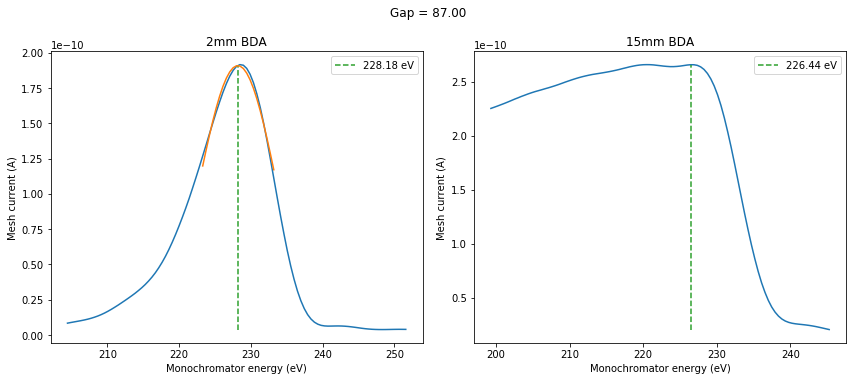

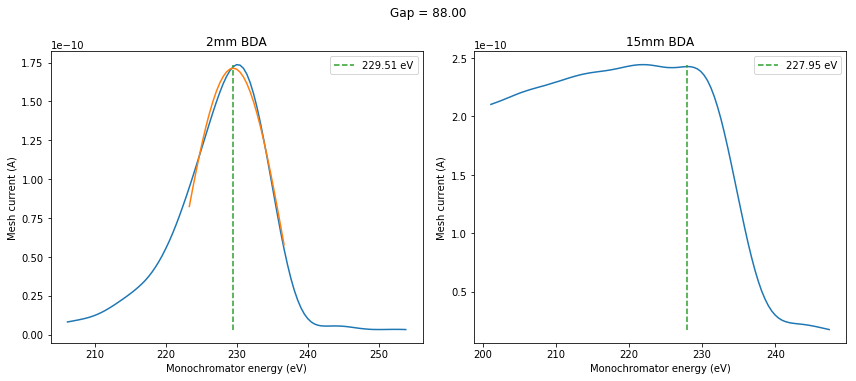

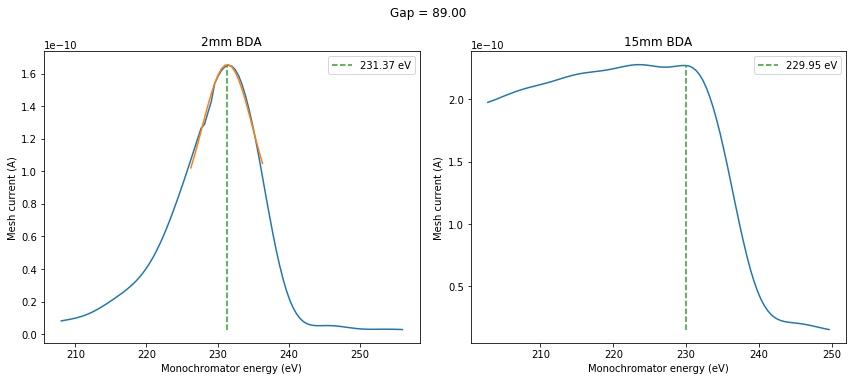

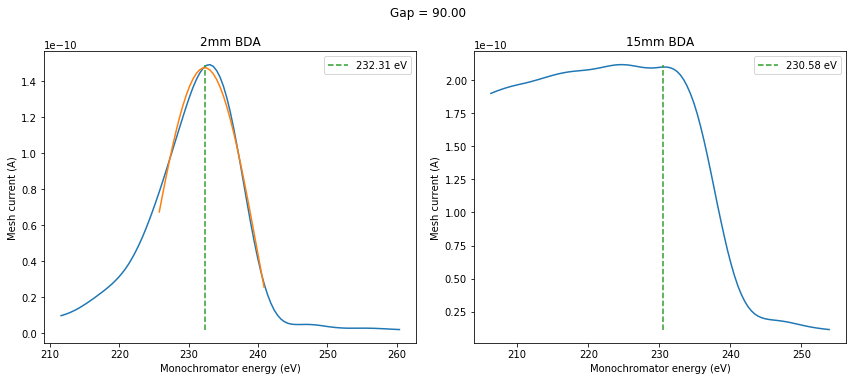

In [4]:
def ProcessFirstOrderPeaks():
    
    fileName = "(2019.02.28)_HPOL_gaps2.h5"
    
    BDA_2mm_scanSet = []
    BDA_2mm_entries = [n for n in range(808,907,2)]
    
    BDA_15mm_scanSet = []
    BDA_15mm_entries = [n for n in range(809,906,2)]

    HPOL_1st_BDA_2mm_peakPos=[]
    HPOL_1st_BDA_2mm_peakWidth=[]
    HPOL_1st_BDA_15mm_peakPos=[]
    HPOL_1st_BDA_15mm_peakHeight=[]
    HPOL_1st_EPU_gap=[]

    for BDA_2mmEntryNumber,BDA_15mmEntryNumber in zip(BDA_2mm_entries,BDA_15mm_entries):

        BDA_2mm_scanSet.append(HDF5loadscan(data_folder/fileName,BDA_2mmEntryNumber))
        BDA_2mm_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in BDA_2mm_scanSet[-1]['b110a_ctl_em02_ch01']]
        
        BDA_15mm_scanSet.append(HDF5loadscan(data_folder/fileName,BDA_15mmEntryNumber))
        BDA_15mm_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in BDA_15mm_scanSet[-1]['b110a_ctl_em02_ch01']]

        fig=plt.figure(figsize=(12,5))
        plt.suptitle("Gap = {:.2f}".format(BDA_2mm_scanSet[-1]['EPU_R1_110_GAPposition'][-1]),y=1.05)
        
        
        plt.subplot(121)
        
        flux = BDA_2mm_scanSet[-1]['meshCurrent']
        energy = BDA_2mm_scanSet[-1]['mono_energy']

        if BDA_2mmEntryNumber==810: fittedCurve,x_subrange,params=GaussFitSpecial(energy,flux)
        else: fittedCurve,x_subrange,params=GaussFitReducedRange(energy,flux)
        peakPosition = params['center'].value
        
        plt.plot(energy,flux)
        plt.plot([peakPosition,peakPosition],[min(flux),max(flux)],'--',color='tab:green',label="{:.2f} eV".format(peakPosition))
        plt.plot(x_subrange,fittedCurve)
        plt.xlabel("Monochromator energy (eV)")
        plt.ylabel("Mesh current (A)")
        plt.title("2mm BDA")
        plt.legend()

        plt.subplot(122)
        
        flux = BDA_15mm_scanSet[-1]['meshCurrent']
        energy = BDA_15mm_scanSet[-1]['mono_energy']   
        
        plt.plot(energy,flux)
        
        if BDA_15mmEntryNumber==811: #Special case, treated by hand   
            peakPosition=10.91
            peakHeight = 1.68e-11
        else:
            peakPosition=BDA_15mm_scanSet[-1]['mono_energy'][np.argmax(BDA_15mm_scanSet[-1]['meshCurrent'])]
            peakHeight = np.max(BDA_15mm_scanSet[-1]['meshCurrent'])

        plt.plot([peakPosition,peakPosition],[min(flux),max(flux)],'--',color='tab:green',label="{:.2f} eV".format(peakPosition))

        plt.title("15mm BDA")
        plt.legend()
        plt.xlabel("Monochromator energy (eV)")
        plt.ylabel("Mesh current (A)")
        plt.tight_layout()
        plt.show()    

        HPOL_1st_EPU_gap.append(BDA_2mm_scanSet[-1]['EPU_R1_110_GAPposition'][-1])
        HPOL_1st_BDA_2mm_peakPos.append(params['center'].value)
        HPOL_1st_BDA_2mm_peakWidth.append(params['width'].value)
        HPOL_1st_BDA_15mm_peakPos.append(peakPosition)
        HPOL_1st_BDA_15mm_peakHeight.append(peakHeight)

    fileName = "(2019.02.28)_HPOL_gaps3.h5"

    BDA_2mm_scanSet = []
    BDA_2mm_entries = [n for n in range(908,957,2)]
    
    BDA_15mm_scanSet = []
    BDA_15mm_entries = [n for n in range(909,958,2)]

    for BDA_2mmEntryNumber,BDA_15mmEntryNumber in zip(BDA_2mm_entries,BDA_15mm_entries):

        BDA_2mm_scanSet.append(HDF5loadscan(data_folder/fileName,BDA_2mmEntryNumber))
        BDA_2mm_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in BDA_2mm_scanSet[-1]['b110a_ctl_em02_ch01']]
        
        BDA_15mm_scanSet.append(HDF5loadscan(data_folder/fileName,BDA_15mmEntryNumber))
        BDA_15mm_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in BDA_15mm_scanSet[-1]['b110a_ctl_em02_ch01']]

        fig=plt.figure(figsize=(12,5))
        plt.suptitle("Gap = {:.2f}".format(BDA_2mm_scanSet[-1]['EPU_R1_110_GAPposition'][-1]),y=1.05)
        
        
        plt.subplot(121)
        
        flux = BDA_2mm_scanSet[-1]['meshCurrent']
        energy = BDA_2mm_scanSet[-1]['mono_energy']
        
        fittedCurve,x_subrange,params=GaussFitReducedRange(energy,flux)
        peakPosition = params['center'].value
        
        plt.plot(energy,flux)
        plt.plot([peakPosition,peakPosition],[min(flux),max(flux)],'--',color='tab:green',label="{:.2f} eV".format(peakPosition))
        plt.plot(x_subrange,fittedCurve)
        plt.xlabel("Monochromator energy (eV)")
        plt.ylabel("Mesh current (A)")
        plt.title("2mm BDA")
        plt.legend()

        plt.subplot(122)    
        
        flux = BDA_15mm_scanSet[-1]['meshCurrent']
        energy = BDA_15mm_scanSet[-1]['mono_energy']   
        
        plt.plot(energy,flux)
        
        if BDA_15mmEntryNumber==951: peakHeight,peakPosition = maxInSubset(energy,flux,224,230)
        elif BDA_15mmEntryNumber==953: peakHeight,peakPosition = maxInSubset(energy,flux,226,230)
        elif BDA_15mmEntryNumber==955: peakHeight,peakPosition = maxInSubset(energy,flux,228,232)
        elif BDA_15mmEntryNumber==957: peakHeight,peakPosition = maxInSubset(energy,flux,228,232) 
        else:
            peakPosition= energy[np.argmax(flux)]
            peakHeight = max(flux)
        
        plt.plot([peakPosition,peakPosition],[min(flux),max(flux)],'--',color='tab:green',label="{:.2f} eV".format(peakPosition))

        plt.title("15mm BDA")
        plt.legend()
        plt.xlabel("Monochromator energy (eV)")
        plt.ylabel("Mesh current (A)")
        plt.tight_layout()
        plt.show()   
    
        HPOL_1st_EPU_gap.append(BDA_2mm_scanSet[-1]['EPU_R1_110_GAPposition'][-1])
        HPOL_1st_BDA_2mm_peakPos.append(params['center'].value)
        HPOL_1st_BDA_2mm_peakWidth.append(params['width'].value)
        HPOL_1st_BDA_15mm_peakPos.append(peakPosition)
        HPOL_1st_BDA_15mm_peakHeight.append(peakHeight)

    return HPOL_1st_EPU_gap,HPOL_1st_BDA_2mm_peakPos,HPOL_1st_BDA_2mm_peakWidth,HPOL_1st_BDA_15mm_peakPos,HPOL_1st_BDA_15mm_peakHeight
        
        
HPOL_1st_EPU_gap,HPOL_1st_BDA_2mm_peakPos,HPOL_1st_BDA_2mm_peakWidth,HPOL_1st_BDA_15mm_peakPos,HPOL_1st_BDA_15mm_peakHeight = ProcessFirstOrderPeaks()

### FWHM

To a good approximation, the peak FWHM (in energy) should be $\frac{h\nu}{nN}$, where $n$ is the harmonic order and $N$ is the number of periods in the undulator. So in this case we should expect $\frac{h\nu}{29}$. Let's check:

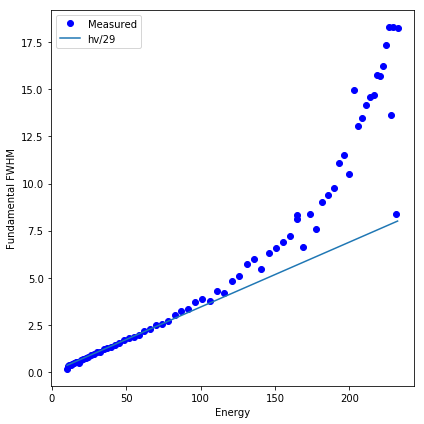

In [5]:
def MakeFigure():
    fig=plt.figure(figsize=(6,6))
    plt.subplot(121)

    FWHM = [np.abs(2.355*ii) for ii in HPOL_1st_BDA_2mm_peakWidth]
    theoryFWHM = [np.abs(ii/29) for ii in HPOL_1st_BDA_2mm_peakPos]

    plt.subplot(111)
    plt.plot(HPOL_1st_BDA_2mm_peakPos,FWHM,'bo',label="Measured")
    plt.plot(HPOL_1st_BDA_2mm_peakPos,theoryFWHM,label="hv/29")
    plt.xlabel("Energy")
    plt.ylabel("Fundamental FWHM")
    plt.legend()
    plt.tight_layout()
    plt.show()
MakeFigure()

It starts off OK, but diverges above about 100eV. To see the reason for this, look at what a 2mm aperture corresponds to as the energy increases:

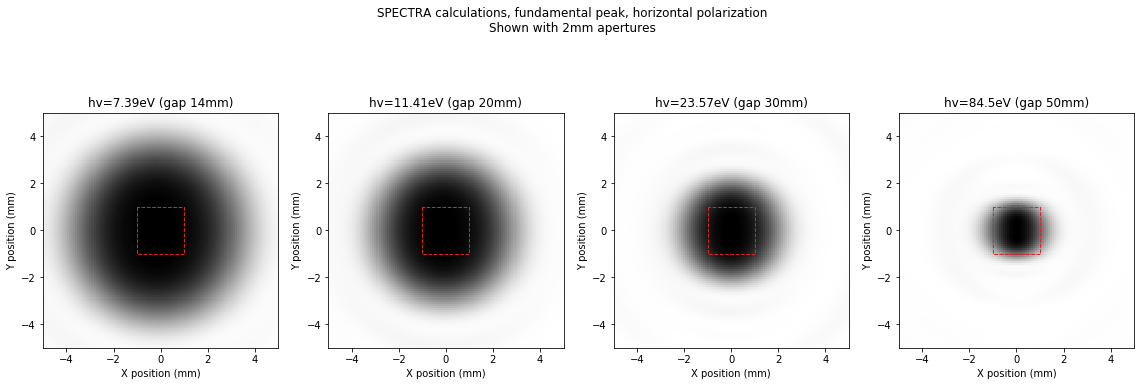

In [6]:
def MakeFigure():
    import matplotlib.patches as patches
    calculation_folder = Path('SPECTRA_calculations/')
    im01,im01_extent=loadSPECTRA_image(calculation_folder/"14mm_fundamental.dta")
    im02,im02_extent=loadSPECTRA_image(calculation_folder/"20mm_fundamental.dta")
    im03,im03_extent=loadSPECTRA_image(calculation_folder/"30mm_fundamental.dta")
    im04,im04_extent=loadSPECTRA_image(calculation_folder/"50mm_fundamental.dta")

    fig=plt.figure(figsize=(16,6))
    fig.suptitle('SPECTRA calculations, fundamental peak, horizontal polarization\nShown with 2mm apertures')

    hv = [7.39,11.41,23.57,84.5]
    gap = [14,20,30,50]
    images = [im01,im02,im03,im04]
    extents =[im01_extent,im02_extent,im03_extent,im04_extent]

    for subplot_index in range(1,5):
        plt.subplot(1, 4, subplot_index)
        plt.imshow(images[subplot_index-1],aspect='auto',cmap='gray_r',extent=extents[subplot_index-1])
        plt.xlim(-5,5)
        plt.ylim(-5,5)
        aperture= patches.RegularPolygon((0, 0), numVertices=4, orientation=math.radians(45),radius=sqrt(2)*(2/2),linestyle='--',color='tab:red',fill=False)
        plt.gca().add_patch(aperture)
        ax=plt.gca()
        ax.set_aspect(1)
        plt.xlabel('X position (mm)')
        plt.ylabel('Y position (mm)')
        plt.title("hv={0}eV (gap {1}mm)".format(hv[subplot_index-1],gap[subplot_index-1]))

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show() 
MakeFigure()

As suspected, the 2mm BDA aperture is too much acceptance for hv>100eV. This means that our estimate of the fundamental position will be too low at higher energies.

How does it look if we start doing the same thing with a narrower aperture? (0.3mm)

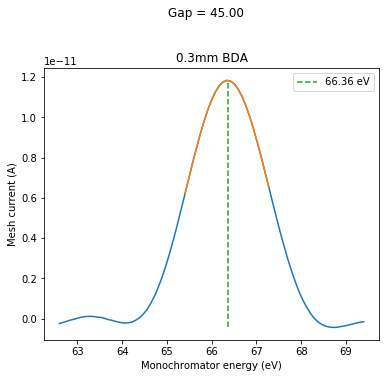

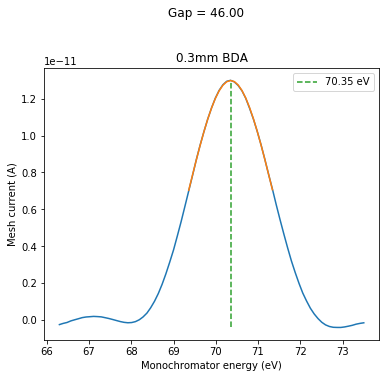

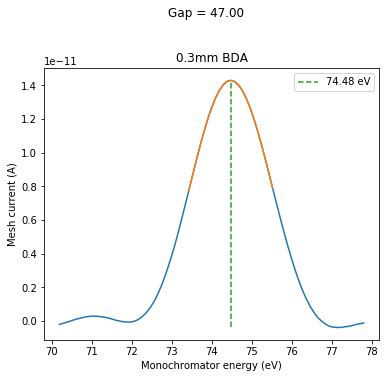

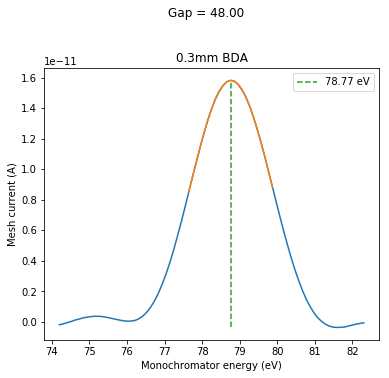

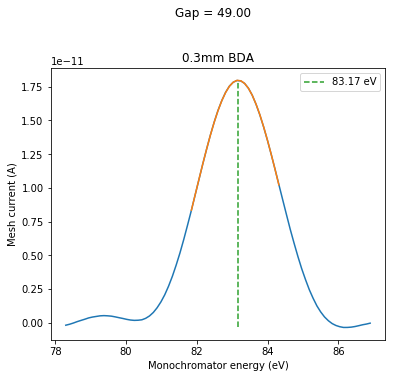

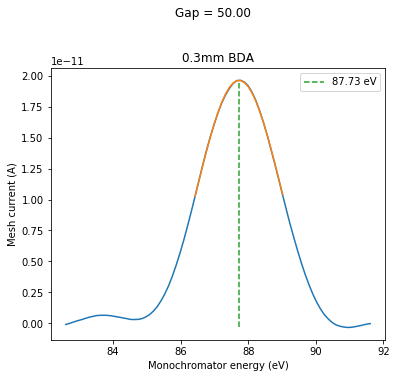

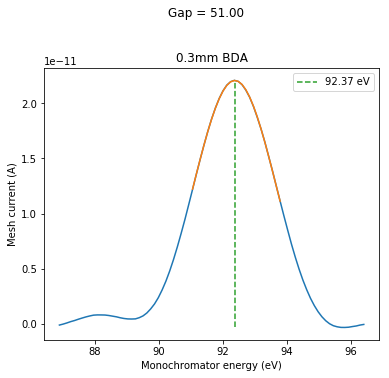

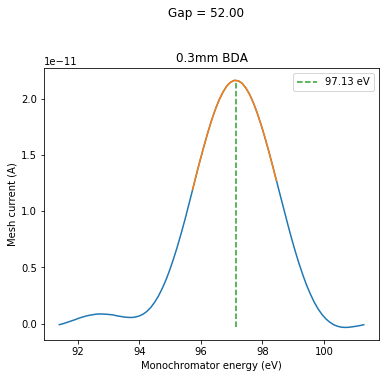

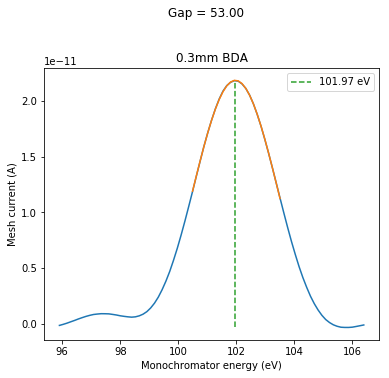

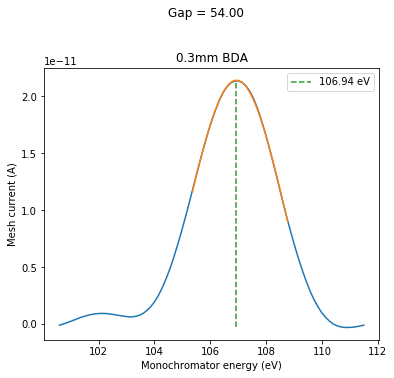

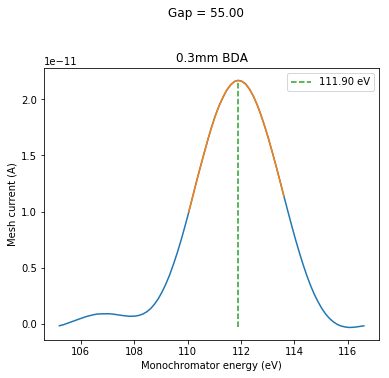

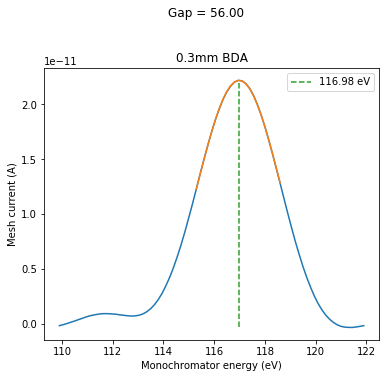

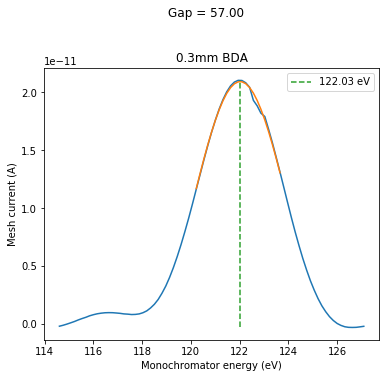

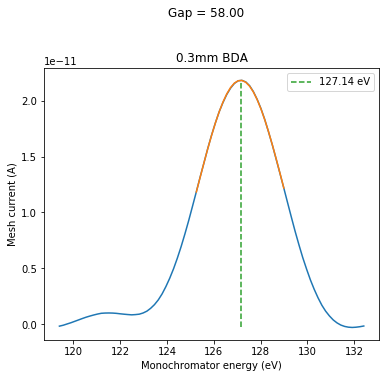

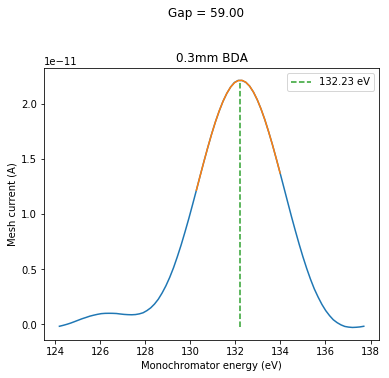

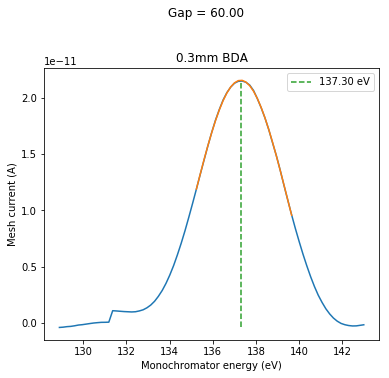

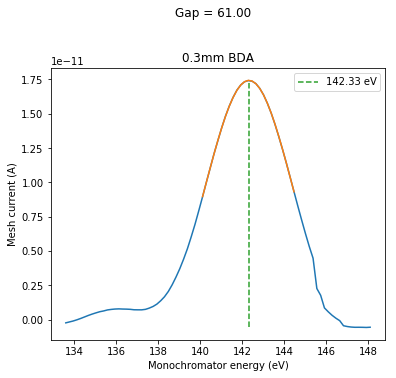

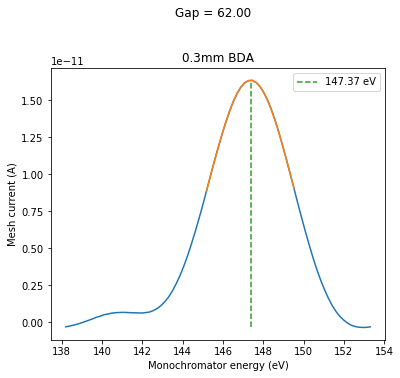

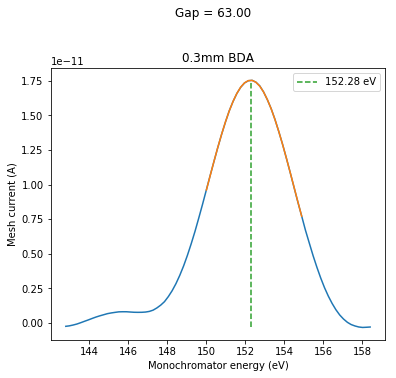

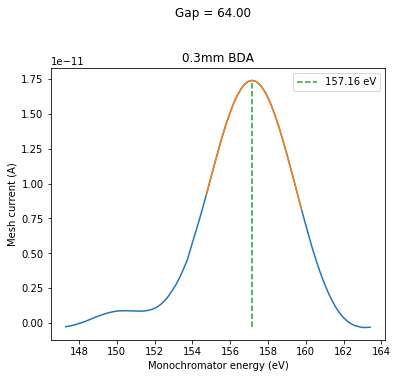

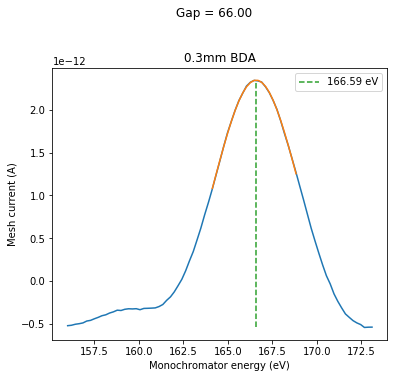

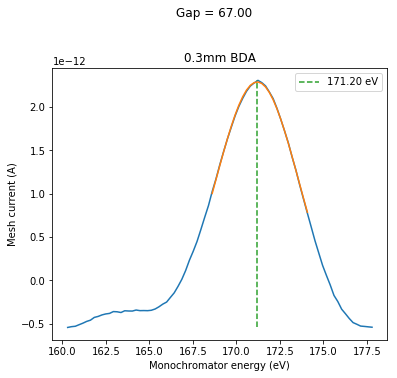

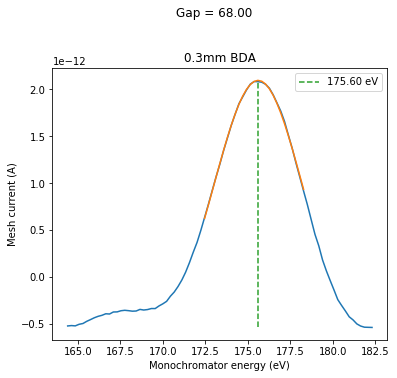

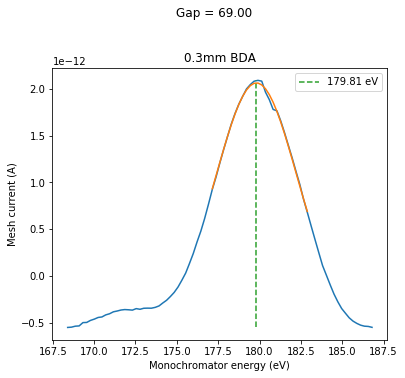

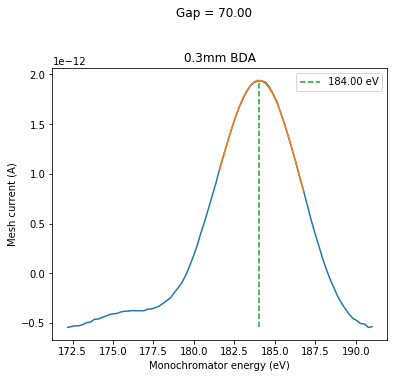

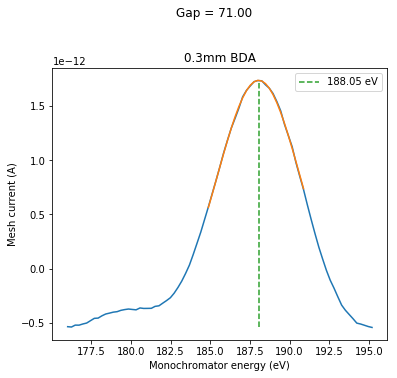

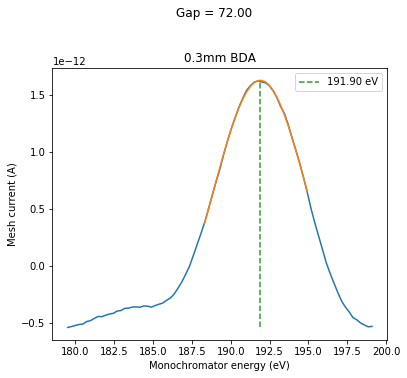

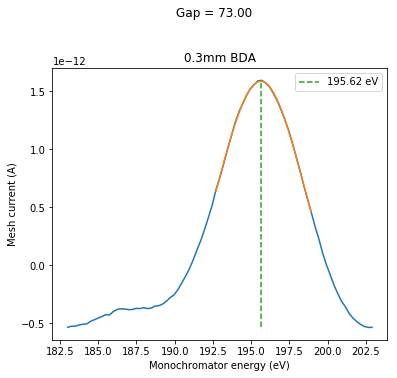

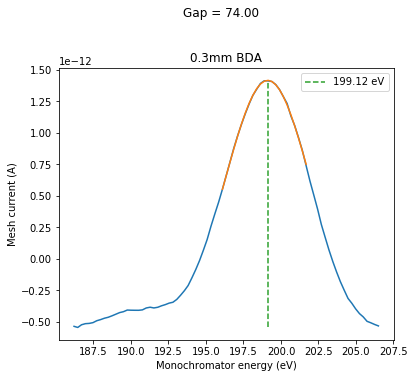

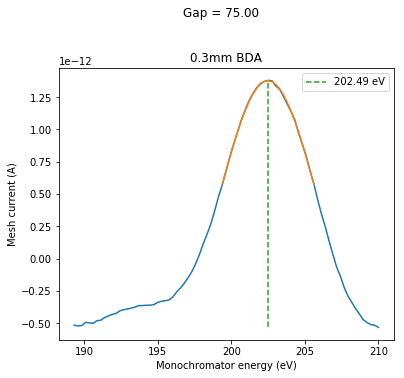

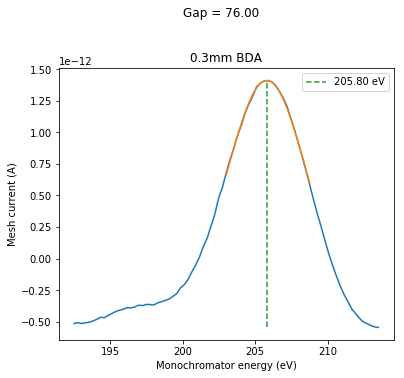

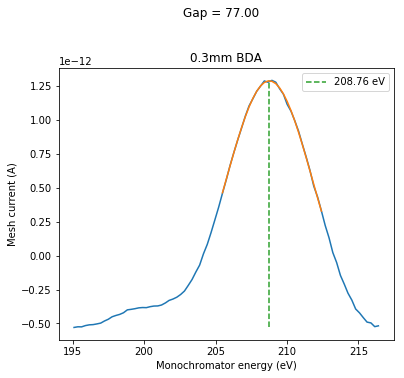

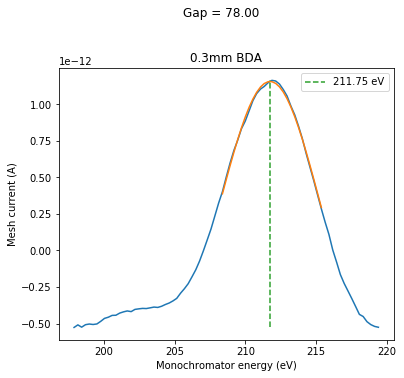

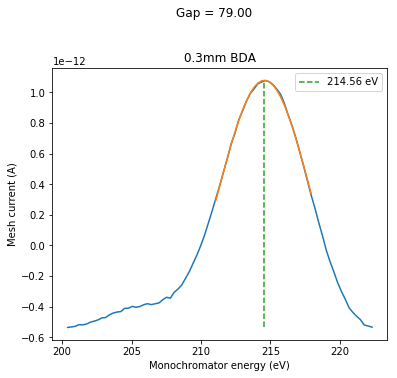

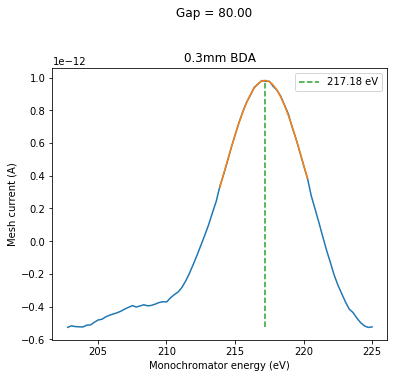

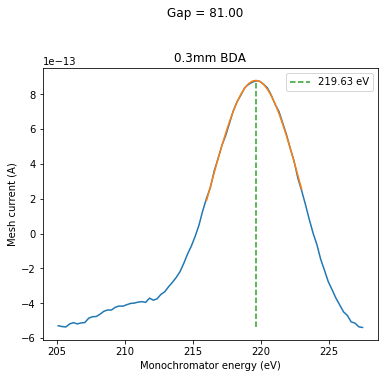

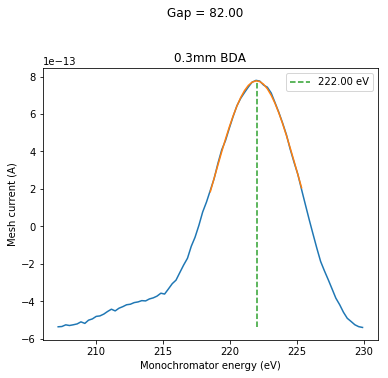

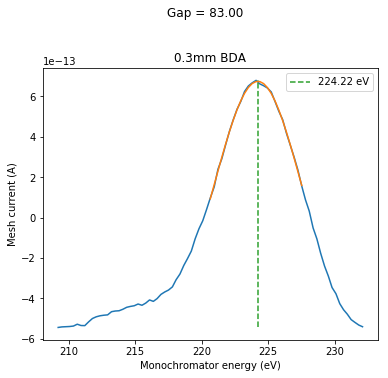

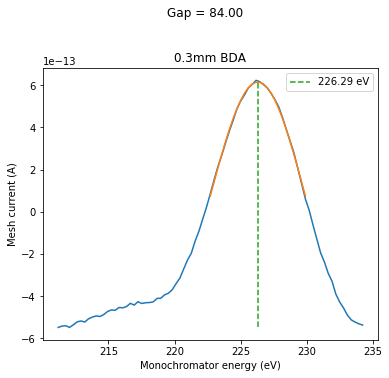

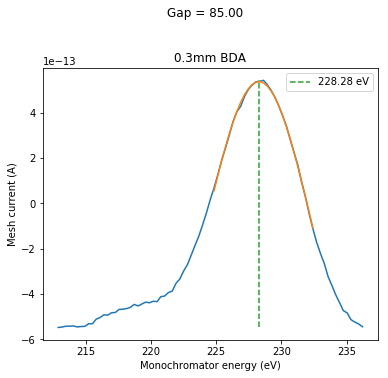

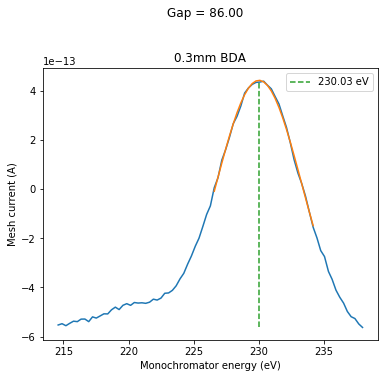

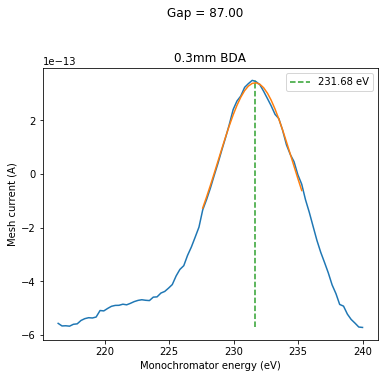

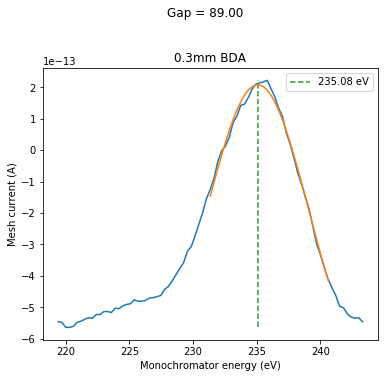

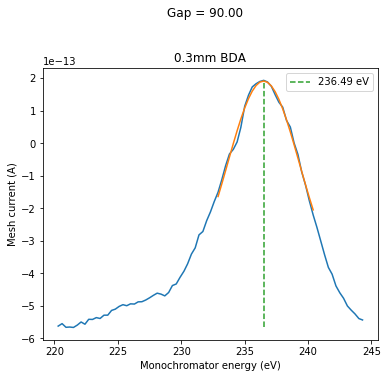

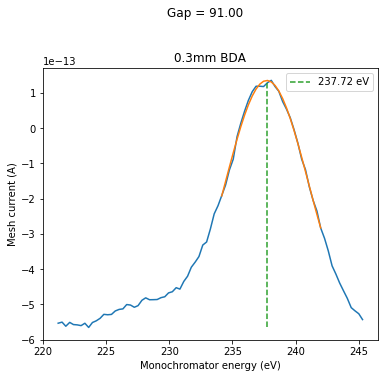

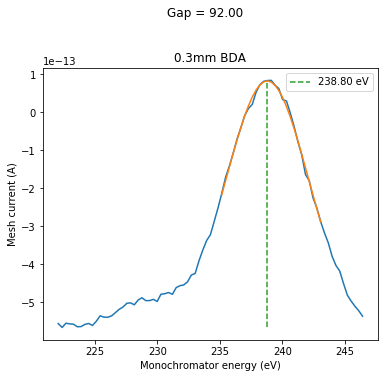

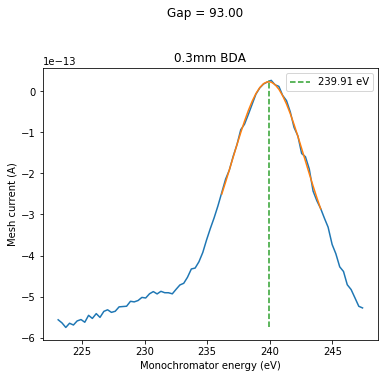

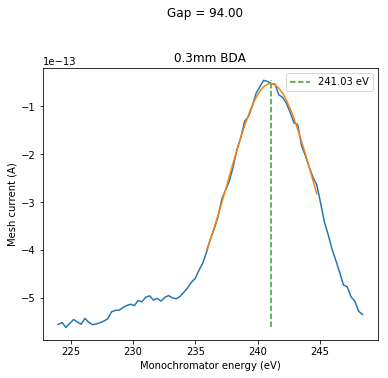

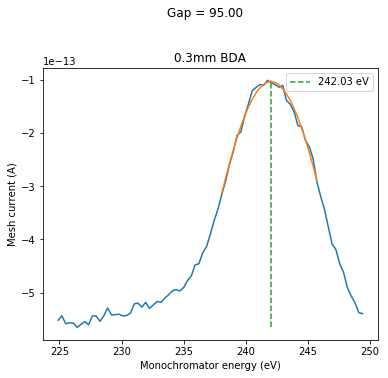

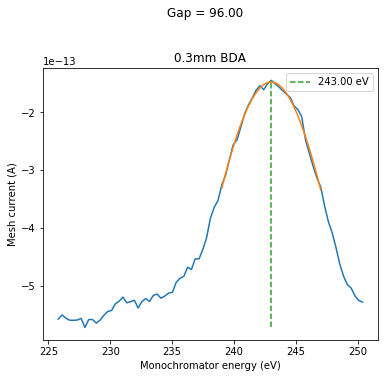

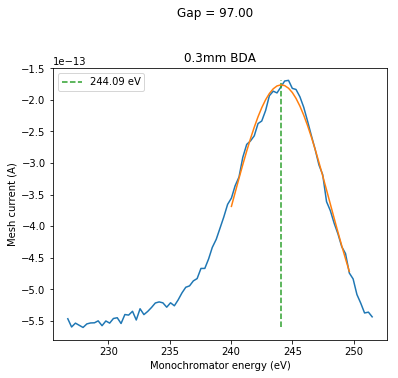

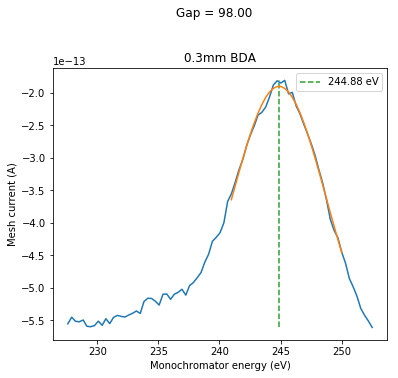

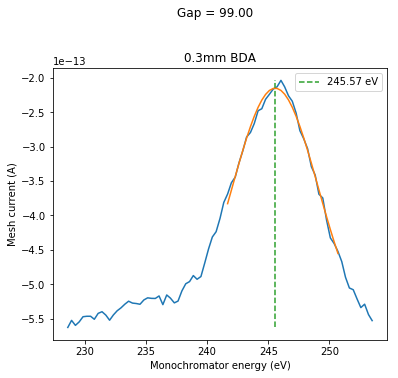

In [7]:
def ProcessFirstOrderPeaks():
    fileName = "(2019.03.07)_HPOL_1st_narrowBDA.h5"

    BDA_300um_scanSet = []
    BDA_300um_entries = [n for n in range(1468,1488,1)]

    HPOL_1st_300umBDA_peakPos=[]
    HPOL_1st_300umBDA_peakWidth=[]
    HPOL_1st_300umBDA_EPU_gap=[]

    for entryNumber in BDA_300um_entries:
        
        BDA_300um_scanSet.append(HDF5loadscan(data_folder/fileName,entryNumber))
        BDA_300um_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in BDA_300um_scanSet[-1]['b110a_ctl_em02_ch01']]
        
        flux =  BDA_300um_scanSet[-1]['meshCurrent']
        energy = BDA_300um_scanSet[-1]['mono_energy']
        
        fig=plt.figure(figsize=(6,5))
        plt.suptitle("Gap = {:.2f}".format(BDA_300um_scanSet[-1]['EPU_R1_110_GAPposition'][-1]),y=1.05)

        fittedCurve,x_subrange,params=GaussFitReducedRange(BDA_300um_scanSet[-1]['mono_energy'],BDA_300um_scanSet[-1]['meshCurrent'])
        peakPosition = params['center'].value
        plt.plot(energy,flux)
        plt.plot([peakPosition,peakPosition],[min(flux),max(flux)],'--',color='tab:green',label="{:.2f} eV".format(peakPosition))
        plt.plot(x_subrange,fittedCurve)
        plt.xlabel("Monochromator energy (eV)")
        plt.ylabel("Mesh current (A)")
        plt.title("0.3mm BDA")
        plt.legend()
  
        plt.show()    
    
        HPOL_1st_300umBDA_EPU_gap.append(BDA_300um_scanSet[-1]['EPU_R1_110_GAPposition'][-1])
        HPOL_1st_300umBDA_peakPos.append(params['center'].value)
        HPOL_1st_300umBDA_peakWidth.append(params['width'].value)


    fileName = "(2019.03.07)_HPOL_1st_narrowBDA_3.h5"

    BDA_300um_scanSet = []
    BDA_300um_entries = [n for n in range(1491,1525,1)]

    for entryNumber in BDA_300um_entries:
        if entryNumber==1513: pass
        else:
            BDA_300um_scanSet.append(HDF5loadscan(data_folder/fileName,entryNumber))
            BDA_300um_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in BDA_300um_scanSet[-1]['b110a_ctl_em02_ch01']]
            
            flux =  BDA_300um_scanSet[-1]['meshCurrent']
            energy = BDA_300um_scanSet[-1]['mono_energy']
            
            fig=plt.figure(figsize=(6,5))
            plt.suptitle("Gap = {:.2f}".format(BDA_300um_scanSet[-1]['EPU_R1_110_GAPposition'][-1]),y=1.05)

            fittedCurve,x_subrange,params=GaussFitReducedRange(BDA_300um_scanSet[-1]['mono_energy'],BDA_300um_scanSet[-1]['meshCurrent'])
            peakPosition = params['center'].value
            plt.plot(energy,flux)
            plt.plot([peakPosition,peakPosition],[min(flux),max(flux)],'--',color='tab:green',label="{:.2f} eV".format(peakPosition))
            plt.plot(x_subrange,fittedCurve)
            plt.xlabel("Monochromator energy (eV)")
            plt.ylabel("Mesh current (A)")
            plt.title("0.3mm BDA")
            plt.legend()
      
            plt.show()    
        
            HPOL_1st_300umBDA_EPU_gap.append(BDA_300um_scanSet[-1]['EPU_R1_110_GAPposition'][-1])
            HPOL_1st_300umBDA_peakPos.append(params['center'].value)
            HPOL_1st_300umBDA_peakWidth.append(params['width'].value)

    return HPOL_1st_300umBDA_EPU_gap,HPOL_1st_300umBDA_peakPos,HPOL_1st_300umBDA_peakWidth
HPOL_1st_300umBDA_EPU_gap,HPOL_1st_300umBDA_peakPos,HPOL_1st_300umBDA_peakWidth = ProcessFirstOrderPeaks()


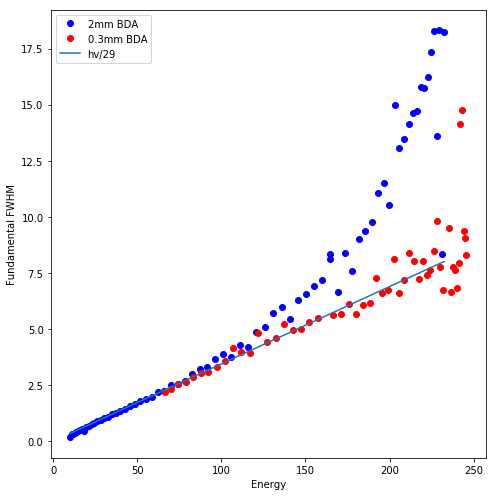

In [8]:
def MakeFigure():
    fig=plt.figure(figsize=(7,7))
    plt.subplot(121)


    FWHM = [np.abs(2.355*ii) for ii in HPOL_1st_BDA_2mm_peakWidth]
    FWHM2 = [np.abs(2.355*ii) for ii in HPOL_1st_300umBDA_peakWidth]
    theoryFWHM = [np.abs(ii/29) for ii in HPOL_1st_BDA_2mm_peakPos]

    plt.subplot(111)
    plt.plot(HPOL_1st_BDA_2mm_peakPos,FWHM,'bo',label="2mm BDA")
    plt.plot(HPOL_1st_300umBDA_peakPos,FWHM2,'ro',label="0.3mm BDA")
    plt.plot(HPOL_1st_BDA_2mm_peakPos,theoryFWHM,label="hv/29")
    plt.xlabel("Energy")
    plt.ylabel("Fundamental FWHM")
    plt.legend()
    plt.tight_layout()
    plt.show()
MakeFigure()

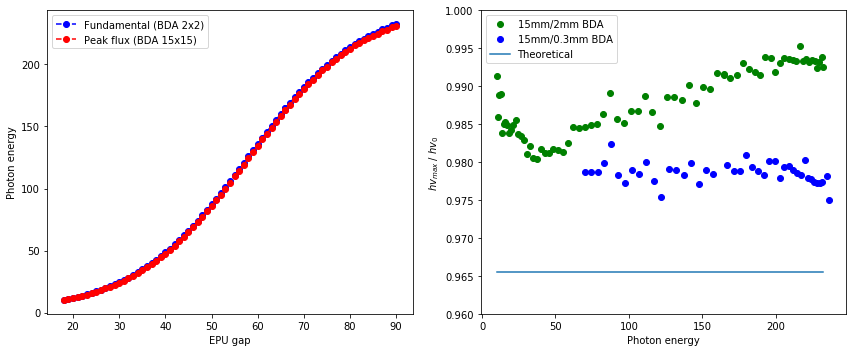

In [9]:
def MakeFigure():
    fig=plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.xlabel("EPU gap")
    plt.ylabel("Photon energy")

    plt.plot(HPOL_1st_EPU_gap,HPOL_1st_BDA_2mm_peakPos,'--bo',label="Fundamental (BDA 2x2)")
    plt.plot(HPOL_1st_EPU_gap,HPOL_1st_BDA_15mm_peakPos,'--ro',label="Peak flux (BDA 15x15)")
    plt.legend()

    plt.subplot(122)

    theoryDifference = [((29-1)/29) for ii in range(len(HPOL_1st_BDA_2mm_peakPos))]
    difference=[(HPOL_1st_BDA_15mm_peakPos[ii]/HPOL_1st_BDA_2mm_peakPos[ii]) for ii in range(len(HPOL_1st_BDA_2mm_peakPos))]
    
    
    difference2=[]
    HPOL_1st_EPU_gap_int = [int(ii) for ii in HPOL_1st_EPU_gap]
    for index,gap in enumerate(HPOL_1st_300umBDA_EPU_gap):
        try:
            largeBDA_pos = HPOL_1st_BDA_15mm_peakPos[HPOL_1st_EPU_gap_int.index(int(gap))]
            difference2.append(largeBDA_pos/HPOL_1st_300umBDA_peakPos[index])
        except:
            difference2.append(np.NaN)

    plt.plot(HPOL_1st_BDA_2mm_peakPos,difference,'go',label="15mm/2mm BDA")
    plt.plot(HPOL_1st_300umBDA_peakPos,difference2,'bo',label="15mm/0.3mm BDA")
    plt.plot(HPOL_1st_BDA_2mm_peakPos,theoryDifference,label="Theoretical")
    plt.ylim([0.96,1])
    plt.ylabel("$hv_{max}$ / $hv_{0}$")
    plt.xlabel("Photon energy")
    plt.legend()
    plt.tight_layout()
    plt.show()
MakeFigure()

According to Walan's thesis (p10), the expected detuning for peak flux goes as:

$hv_{max} = hv_{0}\bigg(\frac{nN-1}{nN}\bigg)$

Which is a constant for all energies. Experimentally I'm seeing smaller detuning values and also some structure. The magnitude of the detuning I don't know, but with the structure there are at least two things going on here. At low energy, 15x15 is not open enough so  $hv_{max}$ is overestimated. Above 100eV, the 15x15 value is OK but the 2x2mm aperture underestimates $hv_{0}$. Both effects will also make the detuning estimate $1-\frac{hv_{max}}{hv_{0}}$ too small.

Using the 0.3mm aperture partially addresses this, but we still don't come to the theoretically expected detuning value. I'm not sure why.


### Gap table

In [10]:
fp = open("new_HPOL_table.txt",'w')
fp.write("EPU gap (mm)\tFundamental position (eV)\tFlux (photons/s)\n")

print("Gap\thv, 2mm BDA\thv, 0.3mm BDA")
for gap,hv1 in zip(HPOL_1st_EPU_gap,HPOL_1st_BDA_2mm_peakPos):
    
    if gap>44.5:
        nearestIndex=[np.abs(gap-ii) for ii in HPOL_1st_300umBDA_EPU_gap].index(min([np.abs(gap-ii) for ii in HPOL_1st_300umBDA_EPU_gap]))
        print("{:.1f}\t{:.2f}\t\t{:.2f}".format(gap,hv1,HPOL_1st_300umBDA_peakPos[nearestIndex]))
        fp.write("{0:0.1f}\t{1:0.2f}\n".format(gap,HPOL_1st_300umBDA_peakPos[nearestIndex]))
    else:
        print("{:.1f}\t{:.2f}\t\tNaN".format(gap,hv1))
        fp.write("{0:0.1f}\t{1:0.2f}\n".format(gap,hv1))

fp.close()

Gap	hv, 2mm BDA	hv, 0.3mm BDA
18.0	10.30		NaN
19.0	11.06		NaN
20.0	11.90		NaN
21.0	12.82		NaN
22.0	13.81		NaN
23.0	14.84		NaN
24.0	15.96		NaN
25.0	17.15		NaN
26.0	18.43		NaN
27.0	19.81		NaN
28.0	21.29		NaN
29.0	22.87		NaN
30.0	24.55		NaN
31.0	26.35		NaN
32.0	28.26		NaN
33.0	30.31		NaN
34.0	32.48		NaN
35.0	34.79		NaN
36.0	37.23		NaN
37.0	39.82		NaN
38.0	42.56		NaN
39.0	45.44		NaN
40.0	48.47		NaN
41.0	51.67		NaN
42.0	55.01		NaN
43.0	58.55		NaN
44.0	62.18		NaN
45.0	65.98		66.36
46.0	69.92		70.35
47.0	74.01		74.48
48.0	78.26		78.77
49.0	82.62		83.17
50.0	87.12		87.73
51.0	91.68		92.37
52.0	96.36		97.13
53.0	101.16		101.97
54.0	106.04		106.94
55.0	110.91		111.90
56.0	115.91		116.98
57.0	120.86		122.03
58.0	125.92		127.14
59.0	130.94		132.23
60.0	135.92		137.30
61.0	140.86		142.33
62.0	145.77		147.37
63.0	150.59		152.28
64.0	155.36		157.16
65.0	160.07		157.16
66.0	164.56		166.59
66.0	164.58		166.59
67.0	169.06		171.20
68.0	173.37		175.60
69.0	177.61		179.81
70.0	181.60		184.00
71.0	185.57		1

## Third order peaks (150-400eV)

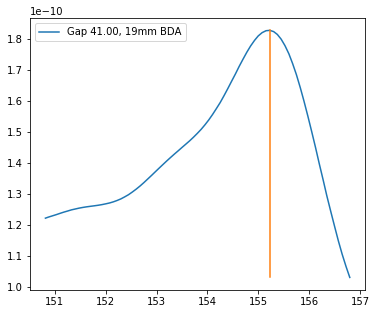

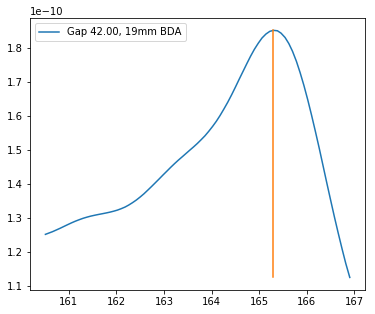

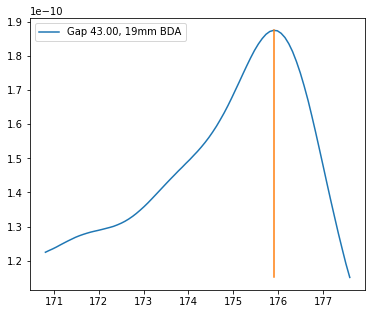

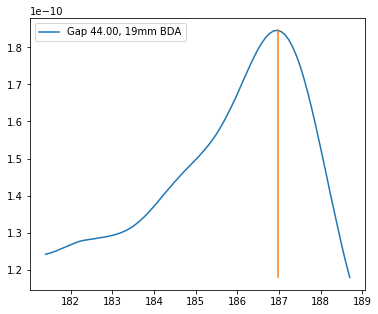

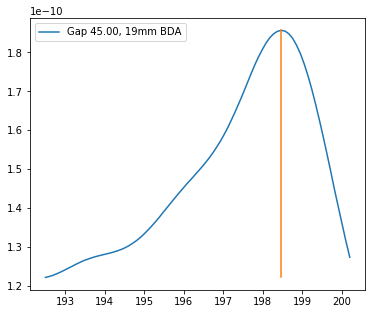

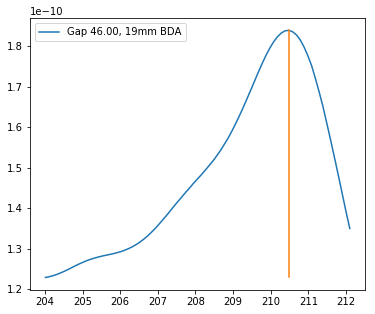

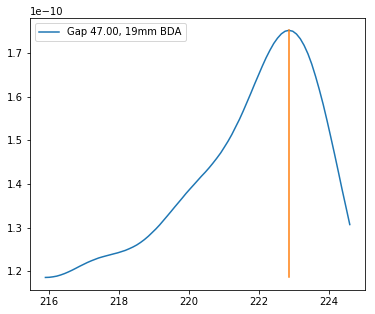

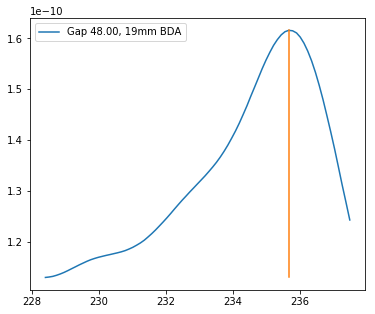

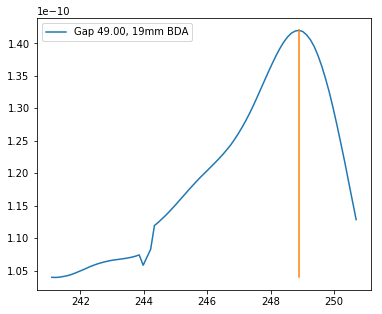

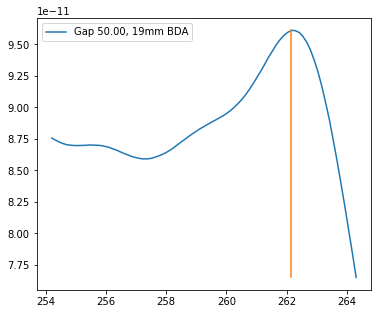

In [11]:
scanSet = []

fileName = "(2019.03.02)_HPOL_3rd_2.h5"
entries = [n for n in range(1170,1180,1)]

HPOL_3rd_peakPos=[]
HPOL_3rd_peakHeight=[]
HPOL_3rd_EPU_gap=[]

for EntryNumber in entries:
    
    scanSet.append(HDF5loadscan(data_folder/fileName,EntryNumber))
    scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in scanSet[-1]['b110a_ctl_em02_ch01']]

    fig=plt.figure(figsize=(6,5))
    plt.subplot(111)
    plt.plot(scanSet[-1]['mono_energy'],scanSet[-1]['meshCurrent'],label="Gap {:.2f}, 19mm BDA".format(scanSet[-1]['EPU_R1_110_GAPposition'][-1]))
    
    peakPosition=scanSet[-1]['mono_energy'][np.argmax(scanSet[-1]['meshCurrent'])]
    peakHeight = np.max(scanSet[-1]['meshCurrent'])
    plt.plot([peakPosition,peakPosition],[min(scanSet[-1]['meshCurrent']),max(scanSet[-1]['meshCurrent'])])
    plt.legend()    
    plt.show()    

    HPOL_3rd_EPU_gap.append(scanSet[-1]['EPU_R1_110_GAPposition'][-1])
    HPOL_3rd_peakPos.append(peakPosition)
    HPOL_3rd_peakHeight.append(peakHeight)

## Quasi-third order peaks (150-400eV)

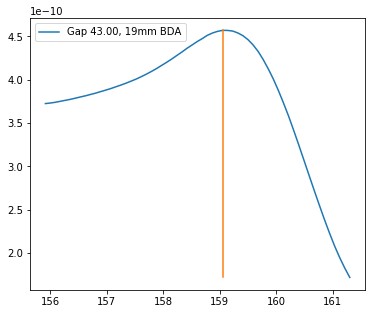

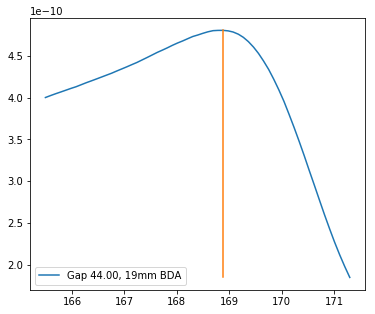

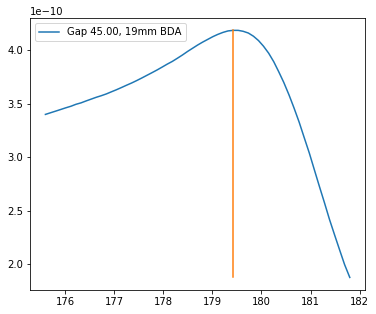

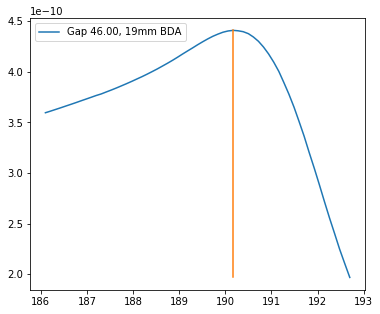

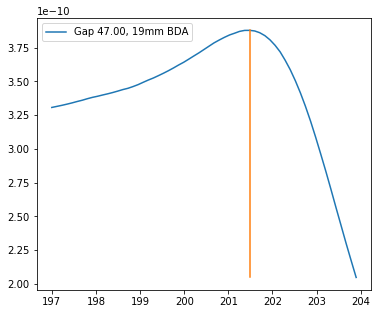

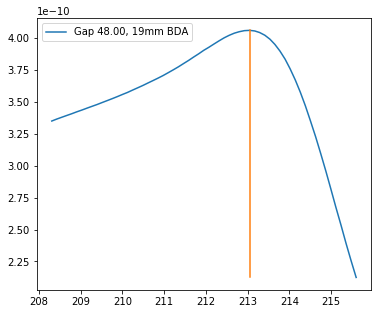

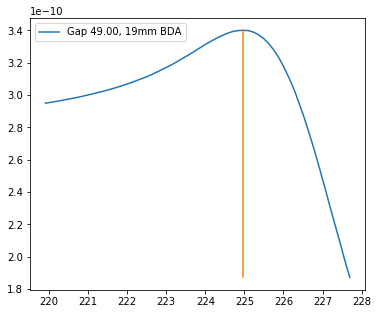

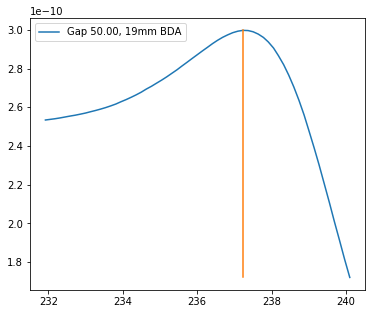

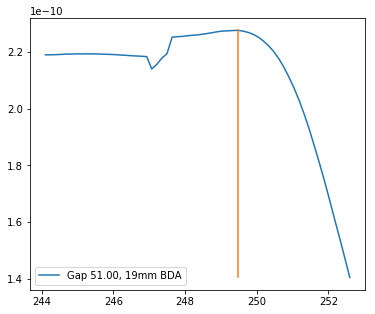

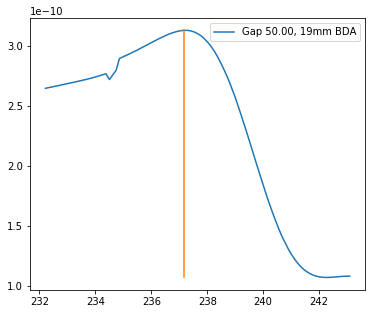

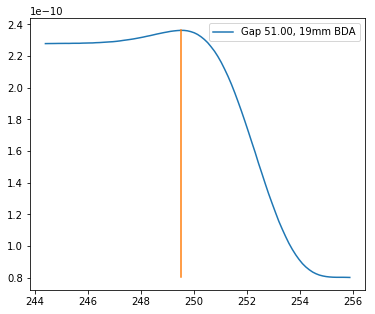

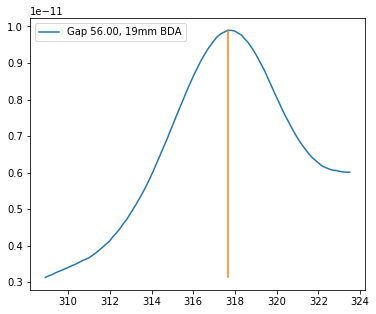

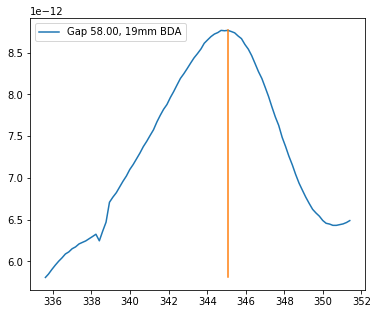

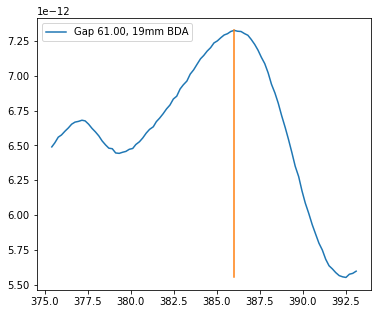

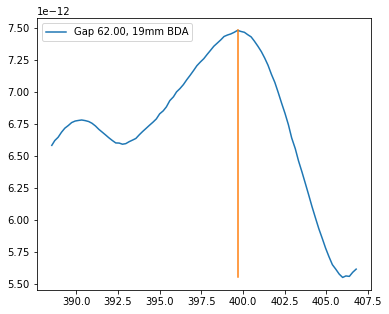

In [12]:
scanSet = []

fileName = "(2019.03.02)_HPOL_quasi3rd_1.h5"
entries = [n for n in range(1149,1158,1)]

HPOL_q3rd_peakPos=[]
HPOL_q3rd_peakHeight=[]
HPOL_q3rd_EPU_gap=[]

for EntryNumber in entries:
    
    scanSet.append(HDF5loadscan(data_folder/fileName,EntryNumber))
    scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in scanSet[-1]['b110a_ctl_em02_ch01']]

    fig=plt.figure(figsize=(6,5))
    plt.subplot(111)
    plt.plot(scanSet[-1]['mono_energy'],scanSet[-1]['meshCurrent'],label="Gap {:.2f}, 19mm BDA".format(scanSet[-1]['EPU_R1_110_GAPposition'][-1]))
    
    peakPosition=scanSet[-1]['mono_energy'][np.argmax(scanSet[-1]['meshCurrent'])]
    peakHeight = np.max(scanSet[-1]['meshCurrent'])
    plt.plot([peakPosition,peakPosition],[min(scanSet[-1]['meshCurrent']),max(scanSet[-1]['meshCurrent'])])
    plt.legend()    
    plt.show()    

    HPOL_q3rd_EPU_gap.append(scanSet[-1]['EPU_R1_110_GAPposition'][-1])
    HPOL_q3rd_peakPos.append(peakPosition)
    HPOL_q3rd_peakHeight.append(peakHeight)

fileName = "(2019.03.03)_HPOL_q3rd_highE.h5"
entries = [1400,1401,1406,1408,1411,1412]

for EntryNumber in entries:
    
    scanSet.append(HDF5loadscan(data_folder/fileName,EntryNumber))
    scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in scanSet[-1]['b110a_ctl_em02_ch01']]

    fig=plt.figure(figsize=(6,5))
    plt.subplot(111)
    plt.plot(scanSet[-1]['mono_energy'],scanSet[-1]['meshCurrent'],label="Gap {:.2f}, 19mm BDA".format(scanSet[-1]['EPU_R1_110_GAPposition'][-1]))
    
    peakPosition=scanSet[-1]['mono_energy'][np.argmax(scanSet[-1]['meshCurrent'])]
    peakHeight = np.max(scanSet[-1]['meshCurrent'])
    plt.plot([peakPosition,peakPosition],[min(scanSet[-1]['meshCurrent']),max(scanSet[-1]['meshCurrent'])])
    plt.legend()    
    plt.show()    

    HPOL_q3rd_EPU_gap.append(scanSet[-1]['EPU_R1_110_GAPposition'][-1])
    HPOL_q3rd_peakPos.append(peakPosition)
    HPOL_q3rd_peakHeight.append(peakHeight)

## Wiggler mode

Not done yet

## Flux curve

NameError: name 'HPOL_1st_largeBDA_peakPos' is not defined

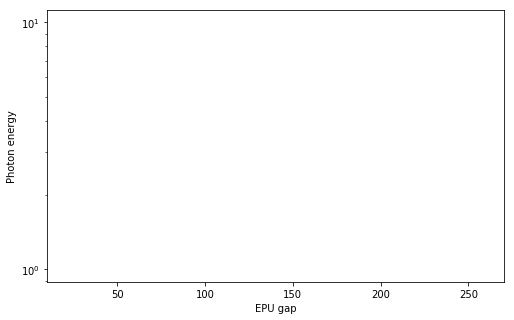

In [13]:
fig=plt.figure(figsize=(18,5))
plt.subplot(121)
plt.xlabel("EPU gap")
plt.ylabel("Photon energy")
plt.yscale('log')
plt.xlim(10,270)
plt.plot(HPOL_1st_largeBDA_peakPos,HPOL_1st_largeBDA_peakHeight,'bo-',label="1st")
plt.plot(HPOL_3rd_peakPos,HPOL_3rd_peakHeight,'go-',label="3rd")
plt.plot(HPOL_q3rd_peakPos,HPOL_q3rd_peakHeight,'ro-',label="quasi-3rd")

plt.subplot(122)
plt.xlabel("EPU gap")
plt.ylabel("Photon energy")
plt.yscale('log')
plt.xlim(10,1000)
plt.plot(HPOL_1st_largeBDA_peakPos,HPOL_1st_largeBDA_peakHeight,'bo-',label="1st")
plt.plot(HPOL_3rd_peakPos,HPOL_3rd_peakHeight,'go-',label="3rd")
plt.plot(HPOL_q3rd_peakPos,HPOL_q3rd_peakHeight,'ro-',label="quasi-3rd")

#plt.plot([283.8,283.8],[1e-11,1e-8],linestyle='--',color='black',label='Carbon K edge (283.8eV)')

plt.legend()
plt.tight_layout()
plt.show()

# Vertical polarization (phase = 42)

## First order peaks (13-230eV)

In [ ]:
def ProcessFirstOrderPeaks():
    
    fileName = "(2019.02.28)_VPOL_gaps.h5"
    
    BDA_2mm_scanSet = []
    BDA_2mm_entries = [n for n in range(958,1049,2)]
    
    BDA_15mm_scanSet = []
    BDA_15mm_entries = [n for n in range(959,1050,2)]

    VPOL_1st_BDA_2mm_peakPos=[]
    VPOL_1st_BDA_2mm_peakWidth=[]
    VPOL_1st_BDA_15mm_peakPos=[]
    VPOL_1st_BDA_15mm_peakHeight=[]
    VPOL_1st_EPU_gap=[]

    for BDA_2mmEntryNumber,BDA_15mmEntryNumber in zip(BDA_2mm_entries,BDA_15mm_entries):

            BDA_2mm_scanSet.append(HDF5loadscan(data_folder/fileName,BDA_2mmEntryNumber))
            BDA_2mm_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in BDA_2mm_scanSet[-1]['b110a_ctl_em02_ch01']]

            BDA_15mm_scanSet.append(HDF5loadscan(data_folder/fileName,BDA_15mmEntryNumber))
            BDA_15mm_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in BDA_15mm_scanSet[-1]['b110a_ctl_em02_ch01']]

            fig=plt.figure(figsize=(12,5))
            plt.suptitle("Gap = {:.2f}".format(BDA_2mm_scanSet[-1]['EPU_R1_110_GAPposition'][-1]),y=1.05)


            plt.subplot(121)

            flux = BDA_2mm_scanSet[-1]['meshCurrent']
            energy = BDA_2mm_scanSet[-1]['mono_energy']

            if BDA_2mmEntryNumber==810: fittedCurve,x_subrange,params=GaussFitSpecial(energy,flux)
            else: fittedCurve,x_subrange,params=GaussFitReducedRange(energy,flux)
            peakPosition = params['center'].value

            plt.plot(energy,flux)
            plt.plot([peakPosition,peakPosition],[min(flux),max(flux)],'--',color='tab:green',label="{:.2f} eV".format(peakPosition))
            plt.plot(x_subrange,fittedCurve)
            plt.xlabel("Monochromator energy (eV)")
            plt.ylabel("Mesh current (A)")
            plt.title("2mm BDA")
            plt.legend()

            plt.subplot(122)

            flux = BDA_15mm_scanSet[-1]['meshCurrent']
            energy = BDA_15mm_scanSet[-1]['mono_energy']   

            plt.plot(energy,flux)

            peakPosition=BDA_15mm_scanSet[-1]['mono_energy'][np.argmax(BDA_15mm_scanSet[-1]['meshCurrent'])]
            peakHeight = np.max(BDA_15mm_scanSet[-1]['meshCurrent'])

            plt.plot([peakPosition,peakPosition],[min(flux),max(flux)],'--',color='tab:green',label="{:.2f} eV".format(peakPosition))

            plt.title("15mm BDA")
            plt.legend()
            plt.xlabel("Monochromator energy (eV)")
            plt.ylabel("Mesh current (A)")
            plt.tight_layout()
            plt.show()    

            VPOL_1st_EPU_gap.append(BDA_2mm_scanSet[-1]['EPU_R1_110_GAPposition'][-1])
            VPOL_1st_BDA_2mm_peakPos.append(params['center'].value)
            VPOL_1st_BDA_2mm_peakWidth.append(params['width'].value)
            VPOL_1st_BDA_15mm_peakPos.append(peakPosition)
            VPOL_1st_BDA_15mm_peakHeight.append(peakHeight)
        
    return VPOL_1st_EPU_gap,VPOL_1st_BDA_2mm_peakPos,VPOL_1st_BDA_2mm_peakWidth,VPOL_1st_BDA_15mm_peakPos,VPOL_1st_BDA_15mm_peakHeight
        
        
VPOL_1st_EPU_gap,VPOL_1st_BDA_2mm_peakPos,VPOL_1st_BDA_2mm_peakWidth,VPOL_1st_BDA_15mm_peakPos,VPOL_1st_BDA_15mm_peakHeight = ProcessFirstOrderPeaks()        



### FWHM

In [ ]:
def MakeFigure():
    fig=plt.figure(figsize=(6,6))
    plt.subplot(121)

    FWHM = [np.abs(2.355*ii) for ii in VPOL_1st_BDA_2mm_peakWidth]
    theoryFWHM = [np.abs(ii/29) for ii in VPOL_1st_BDA_2mm_peakPos]

    plt.subplot(111)
    plt.plot(VPOL_1st_BDA_2mm_peakPos,FWHM,'bo',label="Measured")
    plt.plot(VPOL_1st_BDA_2mm_peakPos,theoryFWHM,label="hv/29")
    plt.xlabel("Energy")
    plt.ylabel("Fundamental FWHM")
    plt.legend()
    plt.tight_layout()
    plt.show()
MakeFigure()

I guess the VPOL beam must stay broader at higher energies, since the 2mm aperture was OK here. This can be checked with SPECTRA but I don't have anything pre-calculated.

### Gap table

In [ ]:
def MakeFigure():
    fig=plt.figure(figsize=(12,7))
    plt.subplot(121)
    plt.xlabel("EPU gap")
    plt.ylabel("Photon energy")

    plt.plot(VPOL_1st_EPU_gap,VPOL_1st_BDA_2mm_peakPos,'--bo',label="Fundamental (BDA 2x2)")
    plt.plot(VPOL_1st_EPU_gap,VPOL_1st_BDA_15mm_peakPos,'--ro',label="Peak flux (BDA 15x15)")
    plt.legend()

    plt.subplot(122)

    theoryDifference = [((29-1)/29) for ii in range(len(VPOL_1st_BDA_2mm_peakPos))]
    difference=[(VPOL_1st_BDA_15mm_peakPos[ii]/VPOL_1st_BDA_2mm_peakPos[ii]) for ii in range(len(VPOL_1st_BDA_2mm_peakPos))]
    plt.plot(VPOL_1st_BDA_2mm_peakPos,difference,'go',label="Measured")
    plt.plot(VPOL_1st_BDA_2mm_peakPos,theoryDifference,label="Theoretical")
    #plt.ylim([0,0.03])
    plt.ylabel("$hv_{max}$ / $hv_{0}$")
    plt.xlabel("Photon energy")
    plt.legend()
    plt.tight_layout()
    plt.show()
MakeFigure()

In [ ]:
print("Gap\tFundamental hv\tMax flux hv")
for gap,hv1,hv2 in zip(VPOL_1st_EPU_gap,VPOL_1st_BDA_2mm_peakPos,VPOL_1st_BDA_15mm_peakPos):
    print("{:.1f}\t{:.2f}\t\t{:.2f}".format(gap,hv1,hv2))

## Third order peaks (150-400eV)

In [ ]:
smallBDA_scanSet = []
largeBDA_scanSet = []

VPOL_3rd_smallBDA_peakPos=[]
VPOL_3rd_smallBDA_peakWidth=[]
VPOL_3rd_largeBDA_peakPos=[]
VPOL_3rd_largeBDA_peakHeight=[]
VPOL_3rd_EPU_gap=[]

fileName = "(2019.02.28)_VPOL_third3.h5"
smallBDA_entries = [n for n in range(1066,1123,2)]
largeBDA_entries = [n for n in range(1067,1124,2)]

for smallEntryNumber,largeEntryNumber in zip(smallBDA_entries,largeBDA_entries):
    
    smallBDA_scanSet.append(HDF5loadscan(data_folder/fileName,smallEntryNumber))
    smallBDA_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in smallBDA_scanSet[-1]['b110a_ctl_em02_ch01']]
    largeBDA_scanSet.append(HDF5loadscan(data_folder/fileName,largeEntryNumber))
    largeBDA_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in largeBDA_scanSet[-1]['b110a_ctl_em02_ch01']]

    fig=plt.figure(figsize=(12,5))
    plt.subplot(121)
    fittedCurve,x_subrange,params=GaussFitReducedRange(smallBDA_scanSet[-1]['mono_energy'],smallBDA_scanSet[-1]['meshCurrent'])
    plt.plot(smallBDA_scanSet[-1]['mono_energy'],smallBDA_scanSet[-1]['meshCurrent'],label="Gap {:.2f}, 2mm BDA".format(smallBDA_scanSet[-1]['EPU_R1_110_GAPposition'][-1]))
    plt.plot(x_subrange,fittedCurve)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(largeBDA_scanSet[-1]['mono_energy'],largeBDA_scanSet[-1]['meshCurrent'],label="Gap {:.2f}, 15mm BDA".format(largeBDA_scanSet[-1]['EPU_R1_110_GAPposition'][-1]))

    peakHeight,peakPosition = maxInSubset(largeBDA_scanSet[-1]['mono_energy'],largeBDA_scanSet[-1]['meshCurrent'],(params['center'].value)-1,(params['center'].value)+1)
 
    #peakPosition=largeBDA_scanSet[-1]['mono_energy'][np.argmax(largeBDA_scanSet[-1]['meshCurrent'])]
    #peakHeight = np.max(largeBDA_scanSet[-1]['meshCurrent'])
    plt.plot([peakPosition,peakPosition],[min(largeBDA_scanSet[-1]['meshCurrent']),max(largeBDA_scanSet[-1]['meshCurrent'])])
    plt.legend()    
    plt.tight_layout()
    plt.show()    
    
    VPOL_3rd_EPU_gap.append(smallBDA_scanSet[-1]['EPU_R1_110_GAPposition'][-1])
    VPOL_3rd_smallBDA_peakPos.append(params['center'].value)
    VPOL_3rd_smallBDA_peakWidth.append(params['width'].value)
    VPOL_3rd_largeBDA_peakPos.append(peakPosition)
    VPOL_3rd_largeBDA_peakHeight.append(peakHeight)
 
fileName = "(2019.03.03)_VPOL_3rd_highE2.h5"
for largeEntryNumber in range(1386,1400):
    largeBDA_scanSet.append(HDF5loadscan(data_folder/fileName,largeEntryNumber))
    largeBDA_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in largeBDA_scanSet[-1]['b110a_ctl_em02_ch01']] 
    fig=plt.figure(figsize=(6,5))

    plt.subplot(111)
    plt.plot(largeBDA_scanSet[-1]['mono_energy'],largeBDA_scanSet[-1]['meshCurrent'],label="Gap {:.2f}, 15mm BDA".format(largeBDA_scanSet[-1]['EPU_R1_110_GAPposition'][-1]))

    peakPosition=largeBDA_scanSet[-1]['mono_energy'][np.argmax(largeBDA_scanSet[-1]['meshCurrent'])]
    
    # WARNING! FUDGE FACTOR!
    # This second set has lower intensity, unclear why. I can make them match in the overlapping scans by multiplying by 1.77, 
    # so for the sake of comparison that's what I'm doing
    peakHeight = np.max(largeBDA_scanSet[-1]['meshCurrent'])*1.77
    plt.plot([peakPosition,peakPosition],[min(largeBDA_scanSet[-1]['meshCurrent']),max(largeBDA_scanSet[-1]['meshCurrent'])])
    plt.legend()    
    plt.tight_layout()
    plt.show()    
    
    VPOL_3rd_EPU_gap.append(smallBDA_scanSet[-1]['EPU_R1_110_GAPposition'][-1])
    VPOL_3rd_smallBDA_peakPos.append(params['center'].value)
    VPOL_3rd_smallBDA_peakWidth.append(params['width'].value)
    VPOL_3rd_largeBDA_peakPos.append(peakPosition)
    VPOL_3rd_largeBDA_peakHeight.append(peakHeight)


In [ ]:
fig=plt.figure(figsize=(6,6))
plt.subplot(121)


FWHM = [np.abs(2.355*ii) for ii in VPOL_3rd_smallBDA_peakWidth]
theoryFWHM = [np.abs(ii/(29*3)) for ii in VPOL_3rd_smallBDA_peakPos]

plt.subplot(111)
plt.plot(VPOL_3rd_smallBDA_peakPos,FWHM,'bo',label="Measured")
plt.plot(VPOL_3rd_smallBDA_peakPos,theoryFWHM,label="hv/87")
plt.xlabel("Energy")
plt.ylabel("Fundamental FWHM")
plt.legend()
plt.tight_layout()
plt.show()

Third order peaks also three times narrower in energy, as expected

## Quasi-third order peaks (150-400eV)

In [ ]:
scanSet = []

fileName = "(2019.03.02)_VPOL_q3rd_2.h5"
entries = [n for n in range(1187,1194,1)]

VPOL_q3rd_peakPos=[]
VPOL_q3rd_peakHeight=[]
VPOL_q3rd_EPU_gap=[]

for EntryNumber in entries:
    
    scanSet.append(HDF5loadscan(data_folder/fileName,EntryNumber))
    scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in scanSet[-1]['b110a_ctl_em02_ch01']]

    fig=plt.figure(figsize=(6,5))
    plt.subplot(111)
    plt.plot(scanSet[-1]['mono_energy'],scanSet[-1]['meshCurrent'],label="Gap {:.2f}, 19mm BDA".format(scanSet[-1]['EPU_R1_110_GAPposition'][-1]))
    
    peakPosition=scanSet[-1]['mono_energy'][np.argmax(scanSet[-1]['meshCurrent'])]
    peakHeight = np.max(scanSet[-1]['meshCurrent'])
    plt.plot([peakPosition,peakPosition],[min(scanSet[-1]['meshCurrent']),max(scanSet[-1]['meshCurrent'])])
    plt.legend()    
    plt.show()    

    VPOL_q3rd_EPU_gap.append(scanSet[-1]['EPU_R1_110_GAPposition'][-1])
    VPOL_q3rd_peakPos.append(peakPosition)
    VPOL_q3rd_peakHeight.append(peakHeight)

## Wiggler mode (Gap=19mm)

M1 pitch fixed at -1815

In [ ]:
VPOL_19mm_wiggler=HDF5loadscan(data_folder/"(2019.03.03)_VPOL_wiggler.h5",1381)
VPOL_19mm_wiggler['meshCurrent'] = [((ii)/10000) for ii in VPOL_19mm_wiggler['b110a_ctl_em02_ch01']]

In [ ]:
%matplotlib notebook

plt.plot(VPOL_19mm_wiggler['mono_energy'],VPOL_19mm_wiggler['meshCurrent'],'-',label="Wiggler")
plt.show()

## Flux curve

In [ ]:
%matplotlib inline
font = {'size'   : 22}
matplotlib.rc('font', **font)

fig=plt.figure(figsize=(13,8))

plt.subplot(111)
plt.xlabel("Photon energy (eV)")
plt.ylabel("Flux (a.u.)")
plt.yscale('log')
plt.xlim(10,1000)

plt.plot(VPOL_1st_largeBDA_peakPos,VPOL_1st_largeBDA_peakHeight,'bo-',label="1st")
plt.plot(VPOL_q3rd_peakPos,VPOL_q3rd_peakHeight,'ro-',label="quasi-3rd")
plt.plot(VPOL_3rd_largeBDA_peakPos,VPOL_3rd_largeBDA_peakHeight,'go-',label="3rd")
plt.plot(VPOL_19mm_wiggler['mono_energy'],VPOL_19mm_wiggler['meshCurrent'],'-',label="Wiggler")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig=plt.figure(figsize=(15,7))
plt.subplot(121)
plt.xlabel("Photon energy")
plt.ylabel("Flux")

plt.xlim(250,450)
plt.ylim(0,2e-11)

plt.plot(HPOL_1st_largeBDA_peakPos,HPOL_1st_largeBDA_peakHeight,'b--',label="HPOL 1st")
plt.plot(VPOL_1st_largeBDA_peakPos,VPOL_1st_largeBDA_peakHeight,'bo-',label="1st")
plt.plot(VPOL_q3rd_peakPos,VPOL_q3rd_peakHeight,'ro-',label="quasi-3rd")
plt.plot(VPOL_3rd_largeBDA_peakPos,VPOL_3rd_largeBDA_peakHeight,'go-',label="3rd")
plt.plot(VPOL_19mm_wiggler['mono_energy'],VPOL_19mm_wiggler['meshCurrent'],'-',label="Wiggler")
plt.show()

# Knowing peak positions, remeasure M1 pitch and make more accurate mesh-flux tables

## Horizontal polarization

In [ ]:
HPOL_final_mesh_flux_scanSet = []

fileName = "(2019.03.03)_HPOL_peakFlux_M1.h5"
entries = [n for n in range(1256,1329,1)]

HPOL_final_mesh_flux_peakPos=[]
HPOL_final_mesh_flux_peakHeight=[]
HPOL_final_mesh_flux_EPU_gap=[]
HPOL_final_mesh_flux_monoEnergy=[]
for entryNumber in entries:
    
    HPOL_final_mesh_flux_scanSet.append(HDF5loadscan(data_folder/fileName,entryNumber))
    HPOL_final_mesh_flux_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in HPOL_final_mesh_flux_scanSet[-1]['b110a_ctl_em02_ch01']]

    fig=plt.figure(figsize=(6,5))
    plt.subplot(111)
    fittedCurve,x_subrange,params=GaussFitReducedRange(HPOL_final_mesh_flux_scanSet[-1]['m1_pitch'],HPOL_final_mesh_flux_scanSet[-1]['meshCurrent'])
    plt.plot(HPOL_final_mesh_flux_scanSet[-1]['m1_pitch'],HPOL_final_mesh_flux_scanSet[-1]['meshCurrent'],label="Gap {:.2f}".format(HPOL_final_mesh_flux_scanSet[-1]['EPU_R1_110_GAPposition'][-1]))
    plt.plot(x_subrange,fittedCurve)
    plt.legend()
    

    plt.show()    
    
    HPOL_final_mesh_flux_EPU_gap.append(HPOL_final_mesh_flux_scanSet[-1]['EPU_R1_110_GAPposition'][-1])
    HPOL_final_mesh_flux_peakPos.append(params['center'].value)
    HPOL_final_mesh_flux_peakHeight.append(params['amplitude'].value)
    HPOL_final_mesh_flux_monoEnergy.append(HPOL_final_mesh_flux_scanSet[-1]['mono_energyposition'][-1])

## Vertical polarization

In [ ]:
VPOL_final_mesh_flux_scanSet = []

fileName = "(2019.03.03)_HPOL_peakFlux_M1_VPOL.h5"
entries = [n for n in range(1331,1378,1)]

VPOL_final_mesh_flux_peakPos=[]
VPOL_final_mesh_flux_peakHeight=[]
VPOL_final_mesh_flux_EPU_gap=[]
VPOL_final_mesh_flux_monoEnergy=[]
for entryNumber in entries:
    
    VPOL_final_mesh_flux_scanSet.append(HDF5loadscan(data_folder/fileName,entryNumber))
    VPOL_final_mesh_flux_scanSet[-1]['meshCurrent'] = [((ii)/10000) for ii in VPOL_final_mesh_flux_scanSet[-1]['b110a_ctl_em02_ch01']]

    fig=plt.figure(figsize=(6,5))
    plt.subplot(111)
    fittedCurve,x_subrange,params=GaussFitReducedRange(VPOL_final_mesh_flux_scanSet[-1]['m1_pitch'],VPOL_final_mesh_flux_scanSet[-1]['meshCurrent'])
    plt.plot(VPOL_final_mesh_flux_scanSet[-1]['m1_pitch'],VPOL_final_mesh_flux_scanSet[-1]['meshCurrent'],label="Gap {:.2f}".format(VPOL_final_mesh_flux_scanSet[-1]['EPU_R1_110_GAPposition'][-1]))
    plt.plot(x_subrange,fittedCurve)
    plt.legend()
    

    plt.show()    
    
    VPOL_final_mesh_flux_EPU_gap.append(VPOL_final_mesh_flux_scanSet[-1]['EPU_R1_110_GAPposition'][-1])
    VPOL_final_mesh_flux_peakPos.append(params['center'].value)
    VPOL_final_mesh_flux_peakHeight.append(params['amplitude'].value)
    VPOL_final_mesh_flux_monoEnergy.append(VPOL_final_mesh_flux_scanSet[-1]['mono_energyposition'][-1])

## Flux curve

In [ ]:
fig=plt.figure(figsize=(18,5))
plt.subplot(121)
plt.xlabel("Photon energy")
plt.ylabel("Mesh current")
plt.yscale('log')
plt.xlim(10,270)
plt.xscale('log')
#plt.plot(HPOL_1st_largeBDA_peakPos,HPOL_1st_largeBDA_peakHeight,'b-',label="HPOL, no M1 correction")
plt.plot(HPOL_final_mesh_flux_monoEnergy,HPOL_final_mesh_flux_peakHeight,'r-',label="HPOL, optimal M1")
#plt.plot(VPOL_1st_largeBDA_peakPos,VPOL_1st_largeBDA_peakHeight,'b-',label="VPOL, no M1 correction")
plt.plot(VPOL_final_mesh_flux_monoEnergy,VPOL_final_mesh_flux_peakHeight,'r-',label="VPOL, optimal M1")
plt.legend()

plt.subplot(122)
plt.xlabel("Photon energy")
plt.ylabel("M1 pitch")
plt.xlim(10,250)
plt.xscale('log')
plt.plot(HPOL_final_mesh_flux_monoEnergy,HPOL_final_mesh_flux_peakPos,'bo--')
plt.plot(VPOL_final_mesh_flux_monoEnergy,VPOL_final_mesh_flux_peakPos,'ro-')
plt.ylim(-1920,-1800)
plt.tight_layout()
plt.show()

In [ ]:
fp = open("new_M1_table.txt",'w')
fp.write("hv\tM1 pitch\n")

for index,element in enumerate(HPOL_final_mesh_flux_monoEnergy):
    fp.write("{0:0.1f}\t{1:0.1f}\n".format(HPOdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABQAAAAFYCAYAAAAMdlF+AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzs3Xd8VGX2x/HPQ0Jv0hQQElBkQUEFsXexgaKs7uoqYocVC1Zs2LCuuiqWRVHBBquuDQtiBXtFbFhBJSC9dwhJzu+Pk/mlzSQTmGQmyff9et3XZO7cufNMCMkz557nnGBmiIiIiIiIiIiISPVUK9kDEBERERERERERkYqjAKCIiIiIiIiIiEg1pgCgiIiIiIiIiIhINaYAoIiIiIiIiIiISDWmAKCIiIiIiIiIiEg1pgCgiIiIiIiIiIhINaYAoIiIiIiIiIiISDWmAKCIiIiIJE0IYXAIYUoIYUUIwUIIHaIc0zmEMCGEsCSEsDqE8FkI4chix2SEEF4NIazNP+6+EEKdYsccGEL4KoSwIYTwewjhnIp9dyIiIiKpQQFAEREREUmmBsBbwA2lHPMaUA/oDfQAPgJeDiFsDxBCSAMmAo2B/YGTgL8Bd0VOEELoCLwOfJJ/jtuA+0MIxyf27YiIiIiknmBmyR6DiIiIiNRwIYRewJdARzObVWh/S2AxcIiZTcnflw5sBE40s+dDCH3wAGCmmc3JP+YU4FFgazNbFUK4HTjOzHYodO5HgZ3MbO9KeZMiIiIiSaIMQBERERFJZUuBn4CBIYRG+dl+g4HVwMf5x+wN/BQJ/uV7E6gL7FbomLeKnftNoFcIoXZFDV5EREQkFaQnewAiIiIiIrGYmYUQDgNeAlYBecAyoI+Zzc8/rDWwsNhTlwC5+Y9Fjnmn2DEL8flwS2A+IiIiItWUAoAxhBD6Af0aN248qHPnzskejoiIiEgRX3311RIza5XscUQTQrgZGF7GYQeb2XtxnCsAo/BMwP2B9cDZwAshhN3NbG7+obHq2liMrwFCrOeGEAbjmYY0bNhwty5dupQ1VBEREZFKVZ75oAKAMZjZq8CrvXr1GjR16tRkD0dERESkiBBCVrLHUIqRwLgyjpkd57kOAfoBzc1sRf6+c/OzAs8AbgYWAPsWe15LII2CzMAFFGQDRmwN5ODBxSLM7GHgYYBevXqZ5oMiIiKSasozH1QAUEREREQSysyW4EtwE6FB/m1esf15FNSz/hS4JoTQzsz+zN93GN4o5KtCx/Qvdo7DgKlmtilBYxURERFJSWoCIiIiIiJJE0JoHULYFYjUXNkxhLBrCKF5/v1P8Zp/j4UQdgkhdA4h3AlsB7yWf8xbwA/AkyGEHiGEQ4E7gUfMbFX+MQ8B7UIII0MIXUMIZwOnA/+u8DcpIiIikmQKAIqIiIhIMp0DfA2Mz78/Mf/+MfD/2YRHAo2AycBU4ACgv5lNyz8mFzgKWId3Bn4WeBG4LPIiZvYH0Df/ud/gNQqHmtkLFfv2RERERJJPS4BFREREJGnM7AbghjKOmQocUcYxs4GjyzjmfaBn+UYoIiIiUvUpA1BERERERERERKQaUwBQRERERERERESkGlMAUEREREREREREpBpTAFBERERERERERKQaUwBQRERERERERESkGlMXYBERqbpycmDVKt9Wry74OrKtWwcHHww775zskYqIiIiIiCSNAoAiIlI1LFwI330H335bcPvTT7BpU9nP3XdfOO88OP54qFOn4scqIiIiIiKSQhQAFBGRxJg/Hx5+GJYv98y8yJabW/R+Tg6kpUGDBtCwod9G23JyYPr0gmDfwoUFr7Xttp7V16cPtGkDTZr41rhxwddNmkAI8Oyz8OCDcPLJsM02MGgQDB4M7dsn73slIiIiIiJSiYKZJXsMKSmE0A/o16lTp0EzZsxI9nBERFLXihVwxx0wciRs3OhBuPR039LSCr4uvC8315fnFt7y8kqeu25d2Gkn2GUXD/jtsgt07w4tW5ZvjHl58Pbb8J//wGuveWDw2GPh3HOhd2+/L1LFhBC+MrNeyR5HTdCrVy+bOnVqsochIiIiUkR55oPKAIzBzF4FXu3Vq9egZI9FRCQlbdgADzwAt90Gy5Z5ht1NN8F225X/XGaQnV00IGjm50pPwJ+qWrXgiCN8mzULRo+GRx+Fl16Crl3hkkvglFOgXr0tf60IM5g2Ddavh/32S9x5RUREREREykldgEVEpHxycmDsWNhhBxg2DPbYA77+GsaP37zgH3gGXt260KyZL+/dYQfo3Dkxwb/iOnTwoOWcOfDkkx70GzQIMjM9gLlkyZadf+5cuP126NYNevXyJiS//pqQoYuIiIiIiGwOBQBFRCQ+ZjBhgi/FPessaNsWpkyBSZNg112TPbryq1cPBg6Er76Cd9/1YN1110FGhi8NLk/5h7VrYdw4OPxwry145ZWw1Va+LLpePbjqqop7HyIiIiIiImXQEmAREYktNxdmzvQMv/vug08/hb/8BV54Af761+pROy8EOOQQ3378Ee6+G8aMgYcegmOO8YYh9ev7Ut5o208/+fdjzRrPLrz2Wg8sdurk51+1ygOLH3/s3YhFREREREQqmZqAlEFFn0Wkxli9Gr7/3jvufvON337/vdfjA8/4GzECTj+9YpbmppIFC7xhyKhRXt+wNE2awAknwKmneoCvVrHk+rVrfUlzhw4eBKwOQVNJCWoCUnk0HxQREZFUpCYgIiI1XXa2B5tWr46etbZuXcHXixd7sG/mzILnN2vmHXcHD/bbXXeFHXeEOnWS957K8vvv8PTTnq2Yng61a/tWp07B19Hud+7sS3cLNwBp3drrAV51FXzyiZ+vfv2iW4MGfluvXulBvYYN4cYbvc7giy/C8cdX/PdCRERERESkEGUAlkFXfEWkylm1ypeuvv9+7GPS0goCWc2aQffuHuTbZRff2revGplqCxbA//7ngb/PPvN9nTv77aZNvmVnF3wduV/8b1/jxnDssXDiiXDYYd6QJJFycvz7u3GjLzOuXTux55caSRmAlUfzQREREUlFygAUEampliyBPn18Ce+DD8Luu0fPXKvKAaiVK+Gll+C///XmHXl5HrS8/Xb4xz+8iUdZcnMLgoGffeZBxBdf9EYeTZtC//6+rPfQQxOT9Zie7uM7+mgYPRrOP3/LzykiIiIiIhInZQCWQVd8RaTK+PNPz16bNQuefx6OOirZI0qcDRtg4kQP+k2c6Jl0220HJ58MJ53ky5O31KZN8M47Hgx86SUPNG61lTc7OfFEbxKyJYFTM+jd2+sq/vab1w4U2QLKAKw8mg+KiIhIKirPfLBW2YeISI2Wm+vLLFevTvZIqq9Nm7xRxJaYMcMbUMybB2++WT2Cf7m58PbbcMYZsM028Le/eV3Df/7Ts/ZmzvQ6fYkI/oEH9/r0gcceg4UL4bXXoF8/7/B75JFeF/D882H58s07fwhw552epXn77YkZs4iIiIiISBy0BFikpjKDpUs9YFTatmCBB2LAgzCdOnlH08Jbp07QqFFy309VkpvrS3QnT4YpU+DDDz0IeN55cOWV0KpV+c73zTdwxBH+bzplCvTsWTHjriw//QRPPOHLcefO9Uy544/3bL+DDqqcDsR163oQ9aijPPvwrbfg2Wd9+e7LL/v4Djmk/OfdbTd/H3ffDUOGQLt2iR+7iIiIiIhIMVoCXAYt+ZBqJbI09PnnvVNqdnbJY1q0gLZtYdtt/bZtW2jTxjMAZ8zwbeZMDw4W1rp1QUCwc2fPytppJ+jQAWrV8GTjvDyYPt2Dc1OmeHOOFSv8sa5d4eCDPQPwqae8Pt8ll/jWtGnZ5/74Yw9SNWni2XJ/+UvFvpeKsnQpPPOMB9a+/NKblBx5JJx2mmfhFe7Qm0xTp8KAAfDrr3DppXDLLeVvGDJrlv87DRgAY8cmdnyRYH1aWmLPKylJS4Arj+aDIiIikorKMx9UALAMmvBJlffHHx7we+45D6yAZ4j17u3ZR5EgXyTQF28wY+1aDwQWDgpGvl6woOC4+vWhSxcPCBbettuucjK5kmX2bHj9dW9S8d57vuwTYPvtPXPs4IM9m61Nm4Ln/PwzXHut/3s1b+7ZgOef79/DaN54A447zjv2vv12fM0vUsmmTTBpkgf9Xn3V7++8swf9Tj7Zg8qpaO1aGDbMm6zsvLNnKnbvXr5zXHaZZwF+842fIxHWrPGmJUuX+v/3XXdNzHklZSkAWHk0HxQREZFUpABgAmnCJ1XS7797AOC55+Crr3xfr17w9797HbXttqvY11+50pdx/vijbz/84LezZxccU7euZ0HtuKOPbc89PTDZoEHFjq2i5OXBF1943bjXXoNvv/X97dt7sC8S9IsnSPfVV3DNNR7ga9vWg4Jnnlm0G+2zz8LAgdCtmx+39dYV874SzcyzT594wht6LFniS54HDPDAX1UKWk2c6P8uK1fCbbfBhRfGn+26bJkHgzt2hFNO8azZv/zFM2Y3p9FIdrZnSr77LrRs6RmmDzwAZ53ltQelWlIAsPJoPigiIiKpSAHABNKET6qE3FzPvJswwYN+06b5/t13Lwj6deyY3DGCLyP++eeCwOCPP8J33xUEBtPSPKC1xx4eENxjDw8QVvRyxjlzfFlm69Ze57Bx4/iCJqtXe224117zYNDixT7W/faDo4/2pbldumx+AOaDD2D4cPjoIw/ajhjhHW/HjIFzzvHXefXV+JYKJ5OZ/1u/+iqMH+/LoevUgWOO8aDfEUdsWXfdZFq8GAYN8rqAvXvD44/HX9dv3DgPGi5bVrAvPd0Dg507e/fh008v++cnL8+/j+PG+c9Gv34eUH37bd8/alTVDaxLqRQArDyaD4qIiEgqUgAwgTThk5SyejX88osH0SK3P//swb+NG/2YPfYoCPp16JDU4cZt4UJfnvzFF/D5534bqZHXsKFnCO6xh2/77ZeYpaEbN3rQZswYD5QU/l1Yv76/RiQgGPk6cn/2bA/6vfeeL1vdaivvHtuvnwezmjff8vFFmHmG39VX+3LRDh08WNm3rwd7UzWws2GD1zqMZETOmuX799zTg1InnpjY71MymfnP0UUXeSBz9Gg44YT4n790qdcU/OWXgtvvvvNl9QcdBI884o12YrniCrjjDrj5Zg8Yg18UuOkmuPFGr8X5/PNVtz6kxKQAYOXRfFBERERSkQKACaQJnyTNtGne4CES5PvlF++IGpGW5llhXbr4B/suXbz+V2Zm8sacKGYe/IgEA7/4omjTkh49PADWt68HlMqTITh9ugdrnnrKAy8ZGXDGGbD33p7NtWBBwbZwYcHXkRp+EV26eJbf0UfDvvtWfD3DvDx44QUP6uy2Gzz8cOplzc2f75mQEyd6UHXtWg+mHnqof5/69q3eXW9nzvTlvJ9/7rf33+/B4c2Rl+c/p5dd5j/3I0Z4Y5jiP2cjR8LFF8O55/qS3+LZgm+95dmAGzb4+coTmJSUpwBg5dF8UEREpOYaP96vs8+e7R8fb7nFp9ilHdO3r5eEL/6cwsdF8iGWLvWPtLm5/nE+2vljUQAwgTThk0q1di08/TQ89FBB7b6mTT3YVDjQ16WLLxMsXBOuutu40evqTZ7sv0k/+cR/QzZr5ll3ffp419hotfBWr/aaeY8+6sGZ2rWhf384+2xfthlPAHHTJli0yIOBW23l3/+aLi/PA9WRLL/Iz2z79gXB0YMPjt3EpDrKyfG/2Dfd5IHsbbbxoGe7dt5Zu/jX225b+vdn3jw47zxf3t+zpwfxInUSn3nGl4Qfdxz873+xf47//NMzLj/5xLMJzz478e9bkkIBwMqj+aCIiEjNEC2Q98QTsG5dwTEh+FQ/EqwDGDy46DGxnMR4bmU4GcxmNhlczS08TdFoX4MGnu8RTxBQAcAE0oRPKsX06R70e+opWLXK6+ANGeI1wFq3VhH/aFas8Cyz11/3TrILF/r3qVcvDwb27esBwjFjPPi3dq3XEzz7bM/OatUq2e+g6lm61H9Wp0/3YN+kSR4QDQH22qsg6Ne9u35mp03zJeZz53oALrKtXFny2PbtPQt18GAPCBZn5tmf55/vmajDhvlS+L/+1b/vb70F9eqVPp4NG/z4N97wQPhZZyXmfUpSKQBYeTQfFBERqVpKy9qLla2XlVUQ3CuPWrU8NyKawgG/pTSnMauox6b/f3wtDRjEwyWCgJmZBVWUSqMAYAKEEPoB/Tp16jRoxowZyR6OVEcbNviH+oce8iYPdet67b5zzoF99lEApTzy8nyJ8KRJ/pv7s88Kfms3bAj/+IcH/vbcU9/XeKxe7Z2bf/ihIOA3fboH+yKaNStY2tunjwKq8VqzpiAoGLn98EMPzKWleZDuvPPgwANL/qwuW+bBv7Fj/f5OO/lzmzWL77UjQcA33/Qg4JlnJva9SaVTALDyKAAoIiJSeTZnyW3xAF/xjLzataFJE89p2JwgXzyKB/vqsoHGrKWsT6CzyKQjs4rsCyF2ULHocQoAJowmfJJwM2Z4Pu9jj/lvn06dPOh32mnQsmWyR1c9LF3qWVE5Ob7Ut3HjZI8odf34o2erFQ70ZWUVPF6/vgeaunUrurVtq2BqIv32Gzz4oAf3li/37/m558LAgSV/ft9917sN33Zb+Wsqbtjg/yfeektBwGpAAcDKo/mgiIjIlos3sFc8eNeggX9cjtTUa97ccxYiJeKLH1P440xFKB7oA2jBUiBQi/LH2PIIpFE02qcMwCTQhE8S5tNP4brr4J13PNOnf38P/B1yiOcMi1SmnBzPJhs50u/Xru01JosH+jp21M9nZVq3zmv7/ec/Hpht3BhOPdWDgTvumJjX2LABjj3Wl9CPGePLj6VKUgCw8mg+KCIiNUU8QbrNOT6ewF5Ghi+YWbq05PMrKmsvlli1+k5iPI8wmIbEUfAvTtEyAMeNUw3ASqcJn2wxMw+yDBvm9fzOOcezbtq2TfbIpKZavNi7wb73nteVGzIEdtgh9boK12Rm3rBm1CivYZmd7d2fe/f2iwb77efL2zfX+vUeBHznHc86PP30hA1dKo8CgJVH80EREakJYgXpYjWkKO14KBoYXLXKF7oUV9mBvYhoAT4gf18WxbP5NlKHVTSmJUvLXNJbHtFqALZo4aW/41Ge+aDSOkQq0urVXn/ukkvgmGO8pto11yj4J8kzbZo3Svn0U29ndf/9nlmm4F9qiTRWefJJrxN4++0e8LvnHu923awZ7L8/XH89vP++d8kuj/r1vUnJoYf6BYkbbvCsUBERERGpNsaPhw4dfEFPhw5+vzTDh5fsZLtune+Pdq5hw6IfP2iQTzGzsjy4l5UVPfgHFVeL7w86kEst/qADJzG+xOOPMJgOZFELowNZPMaZjOWM/H2UWMpbl2xaJTj4l0Mag4sF/xo0gHvvTeCLFKIAoEhF+ekn2GMPeP55uOMOb/jRtGmyRyU12VNPwb77+l/Zjz/2paWS+lq1gssv90Df8uXexOOSSzzod/PNcNBBHhA87DC49Vb/ty1cECWWSBBwwAAYMcLPU9EFU0RERESkXMobxCv8vMGDiwbhBg/2/dHOGTkmmshzC59r4ECYPz/68evXx56OlhWci+bkOJ4TKU8eLbj3KIMZFc79/3M8yWkllvDWJbtId94K16AB6eOeoO+4AWRm+vgzM2NnWyaEmWkrZdttt91MpNyeecasYUOzrbc2mzIl2aORmi472+zCC83A7KCDzBYtSvaIJFGWLzd7+WWzoUPNdtrJ/43BrH59s0MOMRsxwuy998zWry/9POPGmTVubNa0qf/+kioBmGopMFeqCZvmgyIisiXGjTPLzDQLwW/HjYv/eQ0aFEzxwO9Hnh/tvNnZZt98Y9a8edHnRbattop9znr1oj8nLa3o/ZMYZ3+QabkE+4NMO4lxcT1+EuNsDUVffA0Nijweed6ctEw7mXF2QYtxtiG95HNOqTXOBjUsOH5Jo0w7vbbfj/Ym8qK9sQrY8gj+dYsWvkX+cYYM2bwfgjKUZz6Y9AlVqm+a8Em5bNxYEGjZd1+zuXOTPSKp6RYt8qAfmF10kc8IpPpatMjshRc8ILjLLj7BALO6dc0OOMDs2mvNXn3V7M8/zfLyij7399/N9trLjz/9dLNVq+J7ze++M5s3L/HvRcqkAKDmgyIikvrKCuKVpn17ixpnql/frG9fs9q1S+5PT4/+nLKCc5mZZo8/7mMrfExWKBrgKyuId3rtcbY2yuMn86TNC22jDmoBW9tl/MvWUL/kN2qrraI+Z33D5iW+sblptSst0Pf/W/FAX4ICe/FSADCBmyZ8Erc//zTbZx9ToEVSxtSpPmuoV8/sySeTPRpJhmXLPEPwkkvMevUyq1WrYLLSqpXZ4YebXXml2bPPmv36q1/EuPZaP65FC7PrrzdbvDj6uWfMMPvb3/xcu+1WMqAoFa66BACBwcAUYAVgQIcox3QGJgBLgNXAZ8CRhR7fBXgamAOsB34BhgG1ip2nO/B+/jFzgevIb4pX2qb5oIhIzRVP9l6sYzZsMGvd2qLGjTIzYz9/7Fizu++O/ryytsaNzcaPN2sbJdZWWvAuBB/Lh0PG2dpQ9Ji1oYGdxWg7gkm2nKZRX3gjte2Deodadt2GUR/PjWTGpepWp07JiGoolM1X/LF4o7gVTAHABG6a8ElcJk/25b4NG2r5nKSGJ57wrK+MDLOvvkr2aCRVrF5t9tFHZvfdZ3bGGWa77lp0MtOkidnNN5t9+qnZMcf4vvr1zc47z+y33/wcixd7hmHt2j7xiRz38svJfW81UDUKAF4EXJV/GysA+CvwRn6grxPwb2AjsH3+42cC9wEHAdsB/8gPFF5d6BxNgAXA/4BuwPH5x1xa1hg1HxQRqb5KC/DFk70X7Zg6dcw6dCgZMyq+Pfig2V13lXx+ZIssyS2etXdBi3H/H5sqHuD7A38zq1v4ktjIY+lk23yiRyNX08Aeb3ye2fDhMTPuIlupGXaR1SSxnteiRfTHt9mm9G9Uebfi39Bo3yzwtc2F/+HL+mGogCW8W0oBwARumvBJqfLyzG6/3bNlunQx+/HHZI9IarrsbA/OgNnBB6ven5RtwwazadPMHn3U7Nhj/Wfn2GPNVqzw32lnnumz11q1fK1Jkyb+9aBBvvR30yaz7bc369FDWYCVrLoEACMb0CtaABBomb//4EL70oFc4G+lnO8O4KtC94cAq4D6hfZdk58JWGoWoOaDIiKpZ0sy8wo/Hi3A9/DDZp9/7jke0eJGW29tdsQRZrvvHnvJbd26ZldcYdayZfTHi9fVixYTGzfOl9QWz9rbVKeBXdCiZN294sflpNe1N+sdY1M40NaF+jFfLA9sQ6PmRVeLRDnmH1u/a1nEWJccSWnMzIz9eGkR1VjPa9Ei+nNiBRMjr1P4H37IkM1fh53iFABM4KYJn8S0cqXZX//q/41OOCH+elkiFWXhQrMDD/SfyYsv9sCMSHnk5ZmNHOkz0s6dCy5qzJ3rM9ittzY76iiz6dOLPu/xx/3n7qWXKn/MNVgNCgAG4EdgLNAISAPOzV8y3KaU8z0EvFPo/pPAxGLH7J7/mh1LG5vmgyIiqWVzM/Mix8ycaXbVVbEz72IF7QonlO2xhwcBiz9WOFvPMjPtwyHjYo5j3r9jN9MIwcwWLrT1jVtFHUROWm2bWquXfcJe9iH72nrqxh7w7rt7rfoYb2x1i0z/puXlxS48GAnwxdOZpLydS8p6XrTnlLe4Yopm8G0pBQATuGnCJ1HNnGm2447+Ifmee5T1IltmxgxvurD99v7HuW9fs9NOM7vsMs8wHTvWGzd89pkvw1y1quTP3JdfFtT7qyZ/zCSJ3nvPg32NGnlTkbJs2mS2ww7eeCQ3t+LHJ2ZWvglfVdhiBQDzH9sW+ALIA3KARcDepZyrJ7ABOL7QvreAscWOy8h/zRLnwmsTTgWmZmRkbMk/lYiIlEM8cZpYMapWrfzxrCzPwIsVx/rss9KbZYRg9tprsVemFq7fVzhxLVoWnjVoYB8OGVfyPUUJYK2jnj3GqfYUA2xW+naxB5i//blLX3u/3uH2DofEXpobKe5n0V+zXJHTeP+RtqTtcXmeV02DeuWhAGACNwUApYR33jFr1sz7qr/7brJHI1XZzJke+EtL88Ddccf5ZcSePQuCebH+kNer58f07OmNHOrW9T9606Yl+11JdTFnjl/aBr9EnpNT+vFPPeXHxhMwlIRI5QAgcHN+YK207aBizyktA/BlYBKwb35wbxQwD9g2ymv/BZgP/KvY/reAMcX2Zea/5l6lvR/NB0Wkpoo3vpKoOEysenpHHunbvff6cbFKuoE//uefsR8Pwac1mzaVvlo11nhKi5fNIiP6CZs2NbvhBm+2dvXVvrKiSZOYg5wX2ljW7seZ3XFHfFFIs7LfTHn+sRRYqzLKMx9MR0TiYwb/+Q9cdBF06QKvvALbbZfsUUlV9NtvcMst8OSTULs2DB0Kl18OrVsXPc4M1q6FxYsLtkWLit6PbMccA6NGQcuWyXlPUv20awcffADnnw+33QbTpsF//wuNG8P8+TB3LsybV3C7cSN07AjXXw/9+0OtWsl+B5JcI4FxZRwzO85zHQL0A5qb2Yr8feeGEA4DzsCDjQCEELrgHYWfMbMri51nAVDsFy1b598ujHMsIiLVwvjxMHw4zJ4NGRk+NR0woOQxgwfDunV+PyvL70PRY+M9rrTXzc6Gb76BSy8tOE9Edja8+SbsskvBvowMf53iMjP9dttt/etox2RkQFqaf33LLUXHDtCgge+PjD/z4/F0eHg4bXNnMy8tg1mn3cJ+kTe2eDEDGn/Krod8wpq3PyVjY4w/bStXwg03+Ndpab5lZ0c9NI/A5CfnMuCU4Dvati19kBFlvZmIAQNK/sMUF88xUvXEGymsqZuu+IqZmW3c6AXvwTteqt6fbI7ffvOGCpGMv4su8iYKIqnu4Yf98nusrNTatX2LVLMeO7bo87OyzPr3N7vySpVMSCBSOANwczZiZwD2w5f+Nim2/xfgukL3d8SDfPfFOH+kCUi9QvuuRk1ARKSGibd0Wqxltu3b++OvvuqLWerH6C3RurWf8513vHzwQw8L/U6/AAAgAElEQVSVfN30dK8iUtrCl+KrWON9D7GO+XBI0ey2qMtzSztJnTpm++1n1qlT0bnQHnuYNW4c/Q1kZJQskxJvxl5kHJWZiilVRnnmg8GPl1h69eplU6dOTfYwJJkWLYLjj4ePPvLLVTfeqMwWKZ8//oCbb4YnnoD0dDjnHLjiCmjTJtkjE4nfF1/AU095lmnbtn5pPXLbogUsWADXXAOPPeZXtf/9bxgyBJ5+Gi680K9G5+TABRfAvfdCCMl+R1VeCOErM+uV7HFsqRBCazwzb0dgPHAUvrx3tpktCyG0BH4G3gduBNYDg4CLgD3NbFoIYSdgMp79d1Hh85vZgvzXaYoHDd/DswY7A48DI8zsrtLGqPmgiFQnHTpEz4yrU8enp2+9BZ07x/5THQLk5cHIkXD33TBnzpaNp04dX3Cw996+2Gru3JLHZGbCrFlF98WbxVj4mHF9x7PfE8Wy5OrWhTPOgG7dYNWqgm3lSnjxRVi/vuSAatXyFTj77OMD3203qF+/ZDokeBbeww+XnWJZ2rEiMZRrPhhvpLCmbrriW8N9/bVfralXz+zpp5M9GinNsmXevXThwmSPpMDvv5uddZZf2qxb12zoUO+mKlKd/etfBVewGzb02/339wzYSy7x+xdcoEzABKCaZAACNxC9RuDphY7pBbwJLMWz+D4HjorjHFbstboDH+ANQuYD11NG9p9pPigiSZTIhK6lS81GjSq9ft7AgT6FNTNr2zb6McX7IsVKZGvf3uznn7232DPPxH7N8vaoKPc3aPVqs/ffN7vzzthtf4uvbGjZ0my7UppwFE9JLO+YNudYkSjKMx9M+qQv1TdN+Gqw55/3PxDbbms2dWqyRyOlmTixYIay3XZmv/yS3PH88YfZ2WcXBP4uuMArEYvUBDk5Zl27FkyOwRvc5OR40O/ii33f0KEKAm6h6hIArAqb5oMikgzlDYZFiyVt3Gg2YYL/Ka5Tx8+x1VYWNaYVrVdEPK8f73GJ7FFR6gvffLOvNz7zTLNu3cxq1Yr+wsUDegsXmm3YsHmDFkkSBQA14ZMtkZtrdv31/t9j773N5s9P9ogklhUr/A87+B/3xx83a9XKrEULs48/rvzxzJrltSLT032Gdf75CvxJzTRlitf8+/Zbn4SDd7sz86DfRReZgoBbTgFAzQdFpGoqK8C1YYNZdnbs2FOjRgUfUZYtM1u5MnYsrGVL/7pVK//zO21a+QKLiSw9V+brxvti69b5yoJY3XEjW4sWZn36+Ge7117zAF95A3rlTkkUqVwKAGrCJ5tr9Wq/PAZe0bb4FSBJHW++adaunV/Ru/rqgn+rmTMLKgk//3zljeeJJ3wyUKeO2Xnnmc2ZU3mvLZLqzjnHf68++aTfz8szu/BC33fffckdWxWmAKDmgyKSOsoTKCseT6pf3/tkXXut2YEH+gKS118vfanu4sV+vuuu8/uxktyaN/fYV3b25o030WK+brRvTO3aZkcdZXbKKWaHHOIrDGKlLxbP5vvtt+gXGTcnoKdlupLCyjMfVBOQMqjocw0yYwb8/e/w/fdw111etF5F6lPP6tVw2WVeHLdrV3j8cdhjj6LHLFniRXk/+8wrE190UdRTJcT69d7UYMwYOPBAePJJrzAsIgU2bYLDD4dPP4X33oO99vLq4f37w6RJMHky7L9/skdZ5VSXJiBVgeaDIlKa0no5nHwy/P57QU+JE06AxYujn6dWLejZEw44AM48E446KnqzjsINMb74AqZMgSuvjH7OSMOOShVPd4516+CHH+C773wbPRo2box+vg4dvDtJmzbegCxye8UV3rCxuGgdQ8o7PpEqojzzQQUAy6AJXw1gBg8+CMOGeQeop5+GI45I9qgkmnffhbPO8lZjl10GI0ZAvXrRj12/Hk45xTt3XXihB3XT0hI7nl9/9aDxd9/B1Vf7eNLTE/saItXF0qUerF+7Fr78Etq3909Cu+/un4qmTfPJvMRNAcDKo/mgiJSmfXv488+S+zMz4Y8/oHZtyM0t/Rwh+J/Fxo0L9pWnSWyszr5lxcJKtTmBsmiDrl8f/vlPaNasIOA3c6Z/DgNo2NDnB9GUFsFUF12Rcs0Ha1X0YERS2ty50KcPnHeeZ59Mn67gXypas8b/jQ491IO0H30Et98eO/gHPtH43/88++/ee/1y6/r1iRvTs8/Cbrv5z9Drr/uESME/kdhatIBXXvFJev/+ftu0Kbz0kv8f/9vfIDs72aMUERH5f+PHe2CtVi2/HT/e95v59eiIaME/8LhZCDBuHEyY4AnvrVtHPzYjo2jwDzyG9fDDHsQLwW9jxbZuucVjX4U1aOD7N0skuJaV5W84K8vvF/4mrFjhF8Q/+sgvuj/0kM/ZCwfkwOfgI0fCDTd48K97d7j+en/OzJl+ITAzM/o4SltZU55vkIioBmBZm2q+VGPPPGPWrJnXfBg1SoXoU9V775l17Og1Ny65xIv+ltc99/jz9967oGDK5lq/3mzIEPv/JjGzZ2/Z+URqmtde8/+Pf/97we/d//3P/08NGZLcsVUxqAag5oMiUm5bUquvTh2v0demjfefyM31Y1u1KnpcaX0lKrKnREJL1cVqllG7ttm22/ptWbX4itflW7Om9MGr2YZIuZVnPqh0Fal5li2D88/3pb577glPPQU77JDsUUlxa9f6str77oPtt4cPPoD99tu8c110ka/NOOUU2HtvrznWqVP5z/P7777kd9o0uPRSuO02X9MhIvE76ijP4L38cr9Sf+ut/v9q2DC4805fK3X22dCvH9Spk+zRiohINVJ8xWgkqW3jRv9YsHy5J7UtX+4VZIonsmVn+5T073+Hvn19WW+tWnDPPdFXokbLvoskp1VECboBAxJwnlmz4OWXo68nhoK6vltvXXTbZhu/3Wsvf2PFZWT4Ut/SBg+qzSdSgVQDsAyq+VLNvPUWnHGGF4u9/nqvlqtlm6nno4/832nmTBg61AMEpU0Y4vXJJ94cJAR47TWf6cXrpZd8TCF445Fjj93y8YjUVGb+SenRR2GnnXyZ/oEH+kT/kUd8aX2rVjBwoF+w6dgx2SNOSaoBWHk0HxSp+nJyoF07WLiw5GMtWnip2njEKklXZftKmME333jQb8IE+PZb35+e7t+04uJpsKG6fCKVRjUARYpbu9Y/RB5xhNec+uwzuOYaBf9Szfr1nll3wAF+SXXKFA8MJCL4B7DPPh4EbNIEDj7YJzllyc6Giy+G446Dzp09+0/BP5EtE4J/EJgwwT8gHHoo/OMfcPrpnnHw+uv+e+D++2Hnnb2ep4iISAyxavVFAnXffuvXlaIF/8AXCD3zDLz5pnfV/fVXDxZGE6sk3YABHhfLy/PbhMa6Yr3BzX3upk1ekPDCC31fz55w441ehPDOO/0b8Pjjm1dUUHX5RFJXvGuFq8MGXAb8AEwHTonnOar5Ug189pnZDjt4HYmLL968GnJSMfLyzJYtM/vpJ7NXXjHr3Nn/nc4912z16op73YULzfbYw2uR3Hdf7OOyssz23NPHdMEFZhs2VNyYRGqq9evNbrrJrH59s3r1zG64oeD3dFaW19oEs6FDzTZuTO5YUwyqAVhpm+aDIqkrWum49HSzdu3MrrnGj1m/3uzss81atrSo5ekqu1ZfuUQbSP36Zo8/brZpkxcijFXLPNpz09IK9tWrZ9avn9mjj/r8ONrzE1ZUUEQqQnnmgzVmCXAIoTvwBLAPEID3gCPMbEVpz9OSjyps0ya46SZfPtq2LTzxhGd9ScUy88IpCxcWbAsWFL0f2bdoUdGunxkZMHYs9O5d8eNctw5OPtmXO1x6Kdxxh18ZjZg4EU491X+OxozxYi8iUnHmzIHLLvNsv5128tsdd/TfEVdc4d0D99rLswa32SbZo00JWgJceTQfFKlc8SynXb3ap5K9e0cvV1evnk/hTj656HnLszo16ct658/3jrnxrE+uVavolpbmbzTa5/2GDb0O+uGHJ26ljYgkRXnmgzUpAHgCcKCZnZd/fzQwxcyeKe15mvBVUevW+ZLNN9/0IM599/nSX0ksM18+MHq0N8iIBPc2bSp5bFqaFwZu3do/vBfeIvv23BMaNaq88efm+tKH//zHA3xPPunLwq+5xpsU7LorPPfc5jUMEZHN8+abXvtv7Vr/v3n66b7/+efhtNN8qdKUKf77pIZTALDyaD4oUnliBekGDfLltT/95NvcudClC/zyS/QYV5Ws1bdpk5ereeMNb1oXqccXy003+ZvMy/N5bfGv77or+vNifXNEpMqpcgHAEMIB+PLc3YC2wBlm9nixY84FhgFt8GW8F5nZh+V4ja7A88C+eAbg58BoM4vxW9FpwlcFrVoFRx/tjSRGj/bZgiRWbi68+KIHyb76yj+I9+xZNJhXPLjXvHnRDLtUYQZ33+2ZR/vu62P88EOfeY4cCfXrJ3uEIjXP/Pn+aWzKFL+I85//+MWB99/3tosdO/pjrVole6RJpQBg5dF8UKTytG8Pf/5Zcn/Dhh636trVA39du0K3bnDBBdEzAMvqVVGpSos6ZmV5wO+NN+Dddz21MT3d56VHHumJDPPnlzxnPG+wQ4cq8M0RkS1RnvlgqnRAaITX5XsyfysihHAicC9wLvBR/u2kEMKOZjY7/5jpMc7dx8zmmNlPIYSRwGRgOfApEKWtkVRpS5dCnz7w9dfw9NNw4onJHlH1smGDZ8ndead36O3UyYOsp57q6yyqohB8CXD79p51VLs2jBuXQpeCRWqgNm3g7bfh5pthxAivyD56tDfyee01OOooX/P17rs1PggoIlJdfPKJJ7RFC/6BZwTm5vrUrbBVq6JnDJbVq6LSFE9pzMqCs87y+WZWlqczggcGTz7Zg36HHOJN68DnqJv7Bm+5JcW/OSJSmVIiHcfMXjezq83seSBaLvIlwONm9oiZ/WRmFwDzgSGFztEtxjan0DGPmFlPM+sNbAJmVvBbk8q0YAEcdBB8951npyn4lzgrVsC//uVXEf/5T9hqK18a+/PPPqmoqsG/wk44Ab75BqZPV/BPJBWkpcH113uQb8UKOPBA/zB03XWe5f3zz7D//n4xQkREUlq0RrQbN3pZ119/9WPWr/dYWCTuVVxGRsngH1SBprNXXVU0AAf+5t94w4N799zjb3zWLHjoIejfv+g3YUveYMp/c0SkMqXEEuDCQghrgPMjS4BDCHWAdcBJZvZcoeP+A3QzswPLce6tzWxRCOEvwHNATzMrkQUYQhgMDAbIyMjYLSta2rSkltmzPRtk3jx45ZXKaSJRE8yb58tgH3rIlyMcfrgX4z/44OgzMBGRirB8ObzzDnz6KXz2mZceyM72T5KNGsEzz3j2dw2jJcCVR0uARTZftJp+aWlQp44H/a66ynv25eX59PK//y1fo46UsmGDX1D+8kvPXv/ySy9SGI3q8IlIApRnPpgSGYBlaAmkAQuL7V8ItC7nuSaEEH4ExuF1BqMuATazh82sl5n1aqWlRalvxgzPAlm82JeMKfi35X75Bc4+2+ts3XWXL7ebNs2L8x9yiIJ/IlK5mjXzRj133+1rxFatgtdf94JQGzZ4XcBbboleBV5ERCpEtKy+wrKzPbHtsstKJsDl5vrzJk3ySg/g90NI0aS1aG82Nxe+/x7GjoVzzoHddoPGjWHvvWHoUM9g79IldiPCjIzKfAciIilTAzAexWf1Icq+0k9gtk/ihiMpYfp0OPRQ/wM8ZQr06JHsEVVtn3/ujT0mTIC6dT0IeOmlsN12yR6ZiEiBunU942/yZDjssILu3enpnqUsIiIVKlpZu8GDPea1dKlXafjtN5+ix7JunZe7i2bAgBTK9ov2Zk89Fc4806Oc4EG+3XeHYcNgjz386223jf58UB0+EUmKqhAAXALkUjLbb2tKZgVKTTJ1KhxxhNefmzwZdtwx2SOqmsw8s+/22+G99zzTZvhwb6m29dbJHp2ISGy9evmnzcMO899lV17pbSGPOSbZIxMRqbbMomf1rVvnJaIzM6F7d0/c7tLFY2ILFpQ8T8onwK1Y4XPjc84p+Wbz8vxi1NixHuzr1MmzA6OJRDJjdQEWEakkKR8ANLPsEMJXwGF43b6Iw4AXkjMqSboPP/RlqS1a+Ic/ZaiVjxn8+KN/78aOhW+/9auUd9/tWX+NGyd7hCIi8enZ0y8C9e4NOTlw0kleJ7B792SPTESk2nnzTbjoougBPYC1a32BTmEhVJEEuI0b/e/HO+94WaEvvyy9Rt+aNfEH8VIqpVFEaqqUqAEYQmgUQtg1hLArPqaM/PuR60J3A6eHEM4OIXQNIdwLtAUeqsAx9QshPLxy5cqKegnZXG++6Zl/bdt6IFDBv/j88QeMGQMnnwxt2kC3bnDhhb4247HH4Pff4eKLFfwTkapnl138ggb4BY5jjvG6sCIiEpdY9fxWrfJrxd995/ebNIFWraB58+jniZbVl/SafrHeXF6ev7G77/ayEs2bw0EHwW23+bHDh8MHH8ROVUz5FEYRkaJSogtwCOEgYEqUh54ws9PzjzkXuBxoA0wHLjazDyp6bOr6lmJeegn+8Q9f4vXWW1qiWpqFCz0rZvJk/2D8xx++v3Vrb+TRu7ffduiQ1GGKiCTMxRfDffd5LcDMTG9idPTR1bZxkboAVx7NB6U6i1airm5dL639zTfea2n4cLj55tKfUyGdeseP37Kls9EGWqeON+z47TdYtMj3denidcUPPdSDgIUbd1TamxURKb/yzAdTIgCYyjThSxHZ2fDAA3D55V5n4/XXvVadFFi5Et5/34N9774LP/zg+7fayicykaBf167V9sOwiNRwS5fC9tv777nly72jee/eMHKkZz1XMwoAVh7NB6Uqijd2lpnpxxRXqxYMGQIDB3pfi+LTxy2NzcX1BmIF3v76V5/7rlrlW+Tr4vtGj/alutHe3EknecCvd29o377ssaiGn4ikIAUAE0gTviTLzYWnn4Zrr4VZs6BvX3j2WWjUKNkjS7716+Hjjz3YN3myN0XJy4P69WG//Xwy07u3X75NS0v2aEVEKsftt3szkLffhp9+ghtu8A9/t93mhatiFWmvghQArDyaD0pVU1rsrEMH720xfXrBFk0IpZfAq3CxIpPxql/f58vRJP3NiYgkRnnmgynfBERqKDOYOBGuvhq+/96DWA89BIcfXrOz19asgQkTfFY3ebJnRqanw557wjXXeJbfXnv5ug0RkZpo6FDPGL/qKvj8cy8bcfbZcOmlXkP2lVf0O1JEqr3hw6N36R0+HPr181+THTt6cvTs2Z4wV1xSStyZeV2+ceNKD/79619ekLBpU78t/nWTJlC7tkc7s7JKPl/1+0SkBlIAUFLPhx/6B7ePP4ZOneCZZ+Dvf69WWRvlsmmT1zscPx5eftlnbx06wPnn+7KF/fZT4w4RkYj69b1Q1emnw//+5wHACRO8NuBFF/nv0jPPTPYoRUQqzHffRY95gcfUrrsObr21YPoYK1uwUrv0zpkD//2vB/6mT/cL3LEy+DIz4Yor4jvvLbekwJsTEUkNNTSiUjZ1AU6Cb7+Fo46CAw7whhWjR8OPP8KJJ9a84J8ZfPIJnHeedzs++mjPXDn1VPjoI+/Ye9dd3rFMwT8RkaJOOcU7A199NWzc6JnjQ4fCzjt7t0eVPxGRambGjIJ+b+vWxZ46Z2R4F9/C08ekdeldsQLGjIGDD/YXvfJKz9wbNQrmz4dHHvFgXWHlDd4lvQWxiEjqqGFRlfiZ2atmNrhp4Q5QUjF++83/CPfo4UGv22/3WczgwZ66X5P8/LPXO+zUCfbdF8aO9Tp+r7ziE6EHH/T9NXkZtIhIWdLS4I47/NNw//7++zMEXwb8ww9+QUVEpIoZP94XgdSq5bdjxvhUcf/9oXNnn0KDV4YZO7Z8sbMBA7zcdl6e3yYkPlZ8wOPHe/mal1/21T2tW3uJhnnzYMQImDnTVwANGQItWyYueFchb05EpOpRE5AyqOhzBVqyBK6/3v+Q167tS7OGDat53X3nzfNlzuPHw7RpPknq3dszWP76V2X4iYhsrlGj4LLLfBnZQw/Bscf6h9CddvImIVWcmoBUHs0HJdmiLdON6NzZKxsMHOgLRwo/J2mNa6MNOD3da7CuXetpiCed5PPdXr10cVtEZDOpC3ACacJXQXJyPJNt2jQYNMiz3tq0SfaoKs+qVfDiiwXNPPLyfPIzYIAvea5J3wsRkYr0yy/+qfjLL/2DZufOXgDr2299SXAVpgBg5dF8UCpCWQG6jRu9mfn06V4VJlqjjm22KUhyThk5OZ6tN29eyccaNIDnn/c61jVtpY+ISAUoz3xQS4AlOe68E774Ap56yjM0akLAywwmTYITTvDZ2hlneC2/4cN96e+XX3oWZE34XoiIVJa//MWXlA0f7sXlW7TwD6B3353skYlIDRZJkMvK8iliVhacdZYv6wXvW9SwoVfIGTgwevAPYNGiCgj+RVu6G82mTR6hfOEFuPFGb7q0884+8GjBP/CmHn36KPgnIpIEygAsg674VoDvvvNst/79vUNjTfHoo57t2KqVZ/kNGOBFWlLqkq2ISDVl5tl/224L3bt7TdV//tNLT3TokOzRbRZlAFYezQcl0TIyvPFtcdtsAwsWeFnsSZOgWzf/ldWnj2cKFpeZ6WXtEiZWS+DrroOOHb1B348/ej3VX3/1bL+Ijh29xMKOO3okc+nSShiwiEjNpiXACaQJX4JlZ3vQa948nzi0bJnsEVWO777z973ffvD667rqKSKSDLfe6pmAX33lAcAnnvASDA895IXoqxgFACuP5oOSKLm53qeoVq3oDclD8F9LxcWKyyW0oa0ZtG8Pc+fGPiYE2H57D/LtuGNBwO8vf/HMv0odsIiIaAlwAoQQ+oUQHl65cmWyh1K93HwzfPON//GvKcG/1au901mzZj4ZUvBPRCQ5Tj3VP3W/+CI88oiXYdhvP7j4Yvjzz2SPTkSqqZwceOklOOwwr+UHHmeLJiMj+v5ENcT9f3l5XiP16ac9E/rQQ71EQmnBv6+/9gYeM2Z4J9/bbvPaqj17Fg3+VciARURkSykAGIOZvWpmg5s2bZrsoVQfU6d69sXAgd6JsSYw86ufM2f6BGvrrZM9IhGRmqtdOzjiCHj8cU/DadcOxo71T+dDhyZ7dCJSxRUvnffAAzBihH993HEeb+vc2Y+99VZPiCusQQNvBBLLgAG+ejYvz2+LxNJKq9u3aZM3PnrsMbjgAr/w0aQJdOkCJ5/sBQdXrvQL1s2bR3/xzEzYdVfvqh6vUgcsIiKVLT3ZA5AaYsMGOO00aN0a7r032aOpPKNHwzPP+GzuwAOTPRoRETnzTP+Q+/bbcOSRsN12Xtvq6qvh1VehX79kj1BEqqDiK16zsjy5OCfHrzuMGgV9+0J6/qevSCystC7AW/TiZ57pdfhWrYLvv/cyPFDQWeTMMz1zr2dP6Nq1YIXKAQdEX7pbWmRSRESqBNUALINqviTI5Zd7599Jk/wDV03w9dew995w8MEwcaJfkRURkeTauNEbgRxySEEjquxs/0Ccne1d2dPSkjvGOFWXGoAhhMHASUAPoCnQ0cxmFTumM3AHsB9QF/gBuMHM3ohyvpbAt0BboJWZLSn0WHfgAWAPYBkwGrjJypgQaz4opVm5EnbYARYvLvlY27alr6rdYmvWeE2+RYtKPlarls9De/b033E9e0KnTmX/jhs/PkGRSRERqWiqASip5ZNP4N//9quJNSX4t2oVnHCC1zl86ikF/0REUkXdul6KYsIEWLLEy1McfbR/cp850xs1SWVrALwF3FDKMa8B9YDeeKDwI+DlEML2UY59DPim+M4QQhPgbWAhsDswFBgGXLIFY5dqqrQVtRHz5sH++3vpvGjBP4D58xM8sOxs+PBDuOEGf/HmzaMH/8BL0bzzDtxxB5x0kjfqiOcCh5buiohUS4pKSMVau9aX/mZmehCwJjDzbpJ//OHLf2tKsxMRkarizDO9JtaBB8Luu8O0aX4/Pd0/KEulMrORZnYbHtQrIT+jbwfgdjP71sxmAlfipWx6FDv2QjygeFeUUw3If+w0M5tuZi8AtwOXhBBCwt6QVHmRFbVZWT6ty8qCQYN8O/FEj72Bl3ZOT4crroBttol+rlhNPeKWl+e/o+680y+kN2vmy3RvvNFL7FxySewa01v84iIiUp0oACgV66qrPKNi7Fho3DjZo6kco0bBc8/5con99kv2aEREpLju3WGffXx52/XXezfgiRP9sY8+gs8+S+74pLilwE/AwBBCoxBCGjAYWA18HDkohNADuAI4FciLcp69gQ/NbH2hfW/iS4U7VMzQpSoaPrxoCTyA9evh0Uc9+S4v/6crPR2mTPEp3113lb+pR9Q0QzPvFjJqFBx/PLRqBbvt5uV0Zs+GM87wTuZLl8KXX8K//gV3370ZLy4iIjWNmoDEEELoB/Tr1KlTsodSdU2ZAvff750VDz442aOpHF995Vdi+/aFYcOSPRoREYll0iT/oN20qd/fZx/vDnzKKd4kZPZsUFJYSjAzCyEcBrwErMKDe8uAPmY2HyCE0BB4GrjAzOaGEHaIcqrWwJ/F9i0s9NgfhR/Ir004GCBDmVQ1yuzZ0feH4PX8ov1qKHdTj2iNO047Dc4/H1as8H3t28Mxx0Dv3l63tG3b6OdKaEcRERGpruJqAhJCOAD4xMxyiu1PB/Yxsw8qaHxJp6LPm2nVKth5Z6hTB775puRVyepoxQovrpyT4w1AWrRI9ohERKS89toLPv/cu2LeeCP87W/JHlFMqdwEJIRwMzC8jMMONrP3Cj2nF/AlxZqA5C/PnQDUAW4G1gNnA/2B3fMDfmMAzOys/OccBEyhUBOQEMJbwJzIMfn7MoFZwN5mFjP1U/PBmmHmTLj5ZnjiieiPZ2Z6SbwttnGjB+mi1e5r0P53+ysAACAASURBVMAz+nr39uYeuhAhIiKlqIgmIFOA5lH2N81/TKSoyy6DOXM8m6ImBP/MvKbUnDnw7LMK/omIVFVPP+0fuBcv9kzA++9P9oiqqpFA1zK2L+I81yFAP+AkM/vYzKaZ2bnAWuCM/GN6A6eHEHJCCDnAu/n7F4QQIusgF+CZfoVFiqctRGqsmTPh9NOhSxdvDt6nD9SvX/SYLV5RO3s2jB4N/fv7PDFW44716+Gf//RuvQr+iYhIAsUbAAxAtFTBFvjkS6TApEnwyCMeBNxnn2SPpnLcdx+89JLXYdl772SPRkRENlfHjr7UrmlTOPZYL2MxenSyR1XlmNkSM/u5jG1d2WcCvHEHlKzrl0fBXPZwYBdg1/zt7Pz9BwH35X/9KbB/CKFeoXMcBszDswClGovV1XfjRp+uPvssXHihlwR9/XWfymZmegwuMxMefricK2qzs70czuWXQ7dufpJzzvFVIgMHem2/aLTcXEREKkipNQBDCK/kf2nAuBDCxkIPpwHdgE8qaGxSFS1f7h1wd9wRRoxI9mgqxxdfeL2/Y47x+n8iIlK1nXwynHWWZ7Hn5PiH9r32gl12SfbIqqUQQms8M69z/q4dQwhbAbPNbBkeuFsGPBZCuBFfAjwI2A54DcDMfi12zpb5X/4cWQIM/Be4Hng8f4lyZ7yb8AiLpyaOVFnRyu2dfrov4DjlFH+8e3doXSg/dMCAGAG/8eNj19qbO9cvhE+aBG+/DatXQ+3asP/+3ryjTx8vLxCCN4orPChQ4w4REalQZTUBWZp/G4Dl+IQrIhv4CHikAsYlVdWFF8LChfDKK1CvXtnHV3XLl8MJJ3hR5sce01INEZHq4Pjj4dxzvaP7U09BmzaeDvTAA8keWXV1Dh6Yi8hvycwZwONmtiSEcCRwCzAZqI13Be5vZtPifREzW5nfTOQ/wFR8bnsXcPeWvwVJZdG6+ubkeHLeKafAYYfFeaJokcSzzvL0waws+O4739+uHZx0kgf8eveGxo1LnkuNO0REpJLF2wTkeuDfZlbjlvuq6HM5TJgAf/0rXHddzcj+M/P3+/rr8OGHsOeeyR6RiIgkyvHHw8cfw59/emfOiRNh/vyShcGSKJWbgFQ3mg9WbbVq+bStuBAgr/jC8tJkZsZuEXzQQR7w69sXdtpJF4VFRKRSJLwJiJmNqInBPymHdeu8TtLOO/uVzJrgnnvg5ZfhjjsU/BMRqW4GDPCM9smTvbTFypXwwgvJHpWIxCEvD959F555xu+3bx/9uDLL7eXkwFdfwciRflEgVvAvhKL1/hT8ExGRFBRXADCE0DyE8GAI4dcQwooQwqrCW0UPUqqAe+7xDrj33gt16iR7NBXvs8/giis8A/DCC5M9GhERSbS+fb0RyOOPw4EHeqmHiRPLfJqIVI5oTT1++80XonTsCIce6gtSzODWW728XmFRy+1t2AAffOAPHHkkNG8OvXrBxRd7846GDaMPRo07RESkCiirBmDEGKAH8DDeKa3aF0oOIfQD+nXq1CnZQ0l9CxbAbbdB//6+/KG6W7rU6/61bw9jx+oqr4hIdVSvntf2uvdejx7svTd8+WWyRyUiRC/Fd8YZsGmTT8sOPxxuv90beYf/jmfA8OGcvG42c9MyuCL3Fj7OHODl9o5eCZM+8VIuH37ojd2ys/2k3bp5gcD99/etXbuSLwxq3CEiIlVGvDUAVwGHmdnnFT+k1KKaL3EYNAieeAJ++AF22CHZo6lYeXne7fftt702VC+VXhIRqbb+/BO22867ALdr55nfS5ZAixbJHhmgGoCVSfPB1NKhgwf9ittqK/j+e//vCkQP2NWp4xesFy3yph15eZCeDrvtVhDs23ff2P/PS+sCLCIiUsnKMx+MNwNwEbBm84ck1da338KYMXDRRdU/+Afw73/7ErD771fwT0SkumvXzj/YP/oo/Pe/vu/LL31poIgkxZIl0YN/4KU6/z/4B3DVVSXb/2Zn+4Xcgw+Ga6/1gN9ee8Ve3lvcgAEK+ImISJUUVw1AYDhwYwihUUUORqoYM7jkEmjWzCdQ1d3HH8PVV8Pf/gbnnZfs0YiISGW4/HJYv95rv4bgSwRFJClGjoTSqvNkZOCZfY89Bscd5/WpY3n3XbjhBujdO/7gn4iISBUWbwbgNUAHYFEIIQvYVPhBM9s5weOSqmDiRO+OeN99HgSszpYsgRNP9DUnjz6qun8iIjVF165e+mH0aNh6a3jvPe8yICKVwqxg2vXHHwWrdEeMiCT3Gd35nuNqv8r56a9C6y/8Se3aQaNGsCbKIiY17RARkRoo3gDg8xU6Cql6Nm2Cyy6Dzp29NlJ1lpcHAwfC4sXw6afeFVJERGqOf/0LTjrJy14sXAjvvOMtRkWkQr33Hgwb5hVYDjwQ7rrLy/WxcSO9lr7HnAdf5cDVr9GBLE9PaL47nHoD9OsHu+7qS/fVtENERASIMwBoZiMqeiBSxTz0EPzyC7zyCtSunezRVKzbb4c33oBRo6Bnz2SPRkREKlvXrvDNN3DjjXD99fDkkwoAiiRQ4b4a5zcfz025w2m8YjYdyGCv5rewbt0AWLSI9IkT4bXX4K23OGTNGqhfH445DPpdA0cdBW3aFD1xpFafmnaIiIjE1wUYIIRQDzga2B4YbWYrQgjbA8vNbFkFjjGp1PUtiuXLvQBLjx5eRLk6L4d9/XW/ivz3v8PTT1fv9yoiIqX7/nvYeWcPIsTqQlCJ1AW48mg+WHEKN+o9ifE8wmAaUpCxZ7VrEzIy4PfffWnvttvC0Uf7/OyQQzwIKCIiUkMlvAtwCKET8A7QCNgKeA5YAQzJv3/25g1VqqSbbvIg4F13Ve+A2A8/wD/+4R/2xoyp3u9VRETK1q0bNG7sjQXWrPH6YiKyRYYP9+BfE1ZyN5cWCf4BhE2b/P/cDTd44K9HD83JRERENkO8NQBHAm/hAb8Vhfa/AjyW6EFJCpsxAx54AM46C3bZJdmjqThLlviV5QYNfJmzusOJiEgIsO++Xhbi00/hsMOSPaIKE0JoC2wN1Cq838ymJWdEUq0sXAhff82cV6ZxZ9bX9OBrOvFb7OM3bVLzHRERkS0UbwBwH2AvM8sNRa+4zQbaJnxUkrquuALq1PEswOoqOxuOPx7mzYP334f27ZM9IhERSRWnnOIBwGefrZYBwBBCD2Ac0AUonmZlQFqlD0pSV+HifdHq65nBrFnw9de+TZuGff01Yf58ANoD2WzH1/TgMc5gKPeyDYtLvo669oqIiGyxeAOAANE6PWQAKxM0lpQSQugH9OvUqVOyh5I63n8fXnoJbr4ZWrdO9mgqhhkMGQIffOCd4/bcM9kjEhGRVHLssX773HPejvS++/zCWPXxMDAHGATMw4N+IiUVLt4HXhfz7LPho4/4KasByyd/TdeNX9Msf/GQpaURunaFQw/ljnd68A09OGDortRutRVDh/pp/qBDiRqA6torIiKSGHE1AQkhPAOsNbOzQgirgZ2BpcDLwO9mdlbFDjN5VPQ5X14e7L47LF7s3X+ra8Hlu++GSy+Fa66p3lmOIiKy+XbcEX7+2S8affwx7LNPUoZREU1AQghrgR5m9msiz1vVaT5YyMaN8NtvcNBBPi+MYj31+I6d8cW9Pfg+rQd/NOrOL7Pr06SJl/Rr2xbS8vNJi3cBvpXhNFqmrr0iIiJlSXgTEOASYEoI4RegHvAs0AlYCJywWaOUquWpp2DaNJ+hVdfg38SJMGyYL/8dMSLZoxERkVR16aWe6cT/sXff4VFV+R/H399QEwJBmogYECkCUo2sWBAEC6xYsKFURbFgQUFdxXXRFXddRUHF1aACSrGgLsGCCAj2H0YFpUhRkK4gTQlITM7vjzuJSUhgkszMzQyf1/PkmeTOyb2fYdnHy/eec77AokW+FQDD5FugLqACYKw51HLdvJyDLVu8h74Fv9as8R4MFyEboyq/kpX3nxlZUOUPr3dOtWoH7q7Sp0/eKH0CXyIiIhJKQRUAnXObzKwtcAXQHm9D6FRginNubxjzSVmwZw/ccw906OB1xY1FS5fCFVd4jU0mTYK4uEP/joiIHJ46dvReExJg8WJ/s4SAmdXI8+M9wH/M7F68YmBm3rHOue2RzCYhUthy3cGDvX2P27cvvND3669//n5CAjRtCikpXqWuWTOvEL5lywGXWkdy/uJfQEaGN+tPRERE/HHIAqCZVcDbDPoe59wLwAthTyVlyyOPeA0xXnstNgtjW7d6HX+rVFHHXxERObTjj4djj/U6xn/9td9pQmEb+ff6M2B2IcfUBCRajRjxZ/EvR0YGXH11/mPJyV5xb8AA7+95s2be19FHH3gP6Fz+oiKQHZ/AYwmjvI2CClAfDxEREX8dsgDonMs0s7OBuyOQR8qajRvhP/+Byy6LtSVOnpyOv5s3e01O6tf3O5GIiJR1cXFw111w/fXeEuA//vAagkSvLn4HkDBbt67o9155xSvyNWnizfQLVs6a3REjcOvW8UtCMrdljKLF3/uQ8GD+eqP6eIiIiPgv2LvVN4BewKNhzCJl0YgRkJUF//6330lCzznvH28ffQTTpnlLnEVERIIxYAD87W+wcyesWgXNm/udqMSccwv8ziBhlpzsLfstqEED7yFvSfXpQ1rVPlx/Pfz8M9z5N7jtNu9ywW43KCIiIpER7HrOdcC9ZjbDzP5uZrfn/QpnQPHRl196++Hddpu31CnWPPYYTJgAf/977O5tKCIi4VG58p/LJydM8DdLCJnZTWbWt5Djfc3sRj8ySQiMGnXg7L5STstzDgYOhAsugNq14f/+Dx56yPu/Rp8+sHat1ytk7VoV/0RERMoCc84depDZmoO87ZxzjUIXqWxJSUlx6enpfseIPOegc2dYvtyb2ZCU5Hei0Hr7bW/fv4sv9pa+xOLehiIiEl47d3rtTPfuhbfegnPPjejlzexL51xKiM+5GhhUcFagmZ0GTHDONQnl9aJFTNwPFqcLcJBGjfKKfHfdBRUrhiiniIiIBK0494PBdgGOwelfclCvvQYffgjPPBN7xb8lS7yOv+3aqeOviIiUXPXqsH6910X1scciXgAMk/pAIWtF2RB4T6JVnz4lKvjlrRvWqwd168IDD0CPHt5xERERiQ6HrHyYWQUz22JmLSMRSMqAjAwYPhzatoVrrvE7TWjldPxNTIQZM4q32bWIiEhB1avDmWd622YEsaoiCmwB2hZyvD1et2A5jEyZ4jX6/fFH76/3xo3eX/U33vA7mYiIiBTXIQuAzrlMIBOIibtaCcJ//uPNaHjiCShXzu80ofP779CrF2zZ4hX/1PFXRERCISUFtm8vvMlC9JkKPGFmZwUeAlcws7OBMcAUn7NJhI0Ykb+bb445cyKfRUREREon2LWPTwJ3m1mwXYMlWq1bBw8/DJdfDqef7nea0HEObrgBPv4YJk6Ek07yO5GIiMSKE0/0Xr/80t8cofEP4BPgPSAj8PUu8Cnwdx9ziQ/WrSvecRERESm7gi3onQ6cAWw0syXAnrxvOufOD3Uw8ckdd4CZNwswluR0/L3vPq+4KSIiEiqtWkH58l4B8OKL/U5TKoGVH1eY2d+BdoABXznnVvubTPyQnFz4xNbk5MhnERERkdIJdgbgNuB14B1gHfBLgS+JBQsWwKuveq3cYunO7q23vMLmpZfCP/7hdxoREYk1lSt7RcB33oH9+/1OUypmdp+ZJTjnVjvnXnPOveqcW21m8WZ2n9/5JLJGjTpwu+SEBO+4iIiIRBdzsbFhdciZWU+gZ+PGja9dtWqV33HCLyvLW8K0YwcsXx47zTGWLIGOHaFZM6+rcax8LhERKVteeQV694arr4bnnvNm04eZmX3pnEsJ8TmzgKOccz8XOF4T+Nk5F0ObAwcvJSXFpaen+x0j4j79FMaNg48+gg0bvOfDo0aVqJmwiIiIhEFx7ge1p18RnHMzgZkpKSnX+p0lIsaPh8WLvRmAsVIky+n4W7WqOv6KiEh4XX6599/Rf/0LhgyB9u39TlRSRuGN39oB2yOcRXw2ciR88w2sWQPx8X6nERERkdIIqgBoZt9ykC7AzrnWIUskkbdjB9x7L5xxBlxyid9pQiNvx9+PPoKjj/Y7kYiIxLpevbwC4MaNUVcANLNf8e71HPCDmeW97ysHVAae8SOb+OPLL+H99+Hf/1bxT0REJBYEOwNweoGfKwBtgVOBcSFNJJE3cqRXBBw7NiJLlsLOObj+eq/j7yuvQEpIV0eJiIgUrlYt73XbNn9zlMxNeLP/XgBGALvyvLcfWOuc+8yPYOKPf/0LkpLghhv8TiIiIiKhEFQB0Dl3f2HHzewOoEFIE0lkLV3qbe4yeDC0aeN3mtCYNg0mTvQaflx2md9pRETkcFGzpvf6S/T1R3POTQIwszXAp4FuwHKY+u47eOMNuOceqFbN7zQiIiISCqXdA/ANIB3vqbFEG+dg6FBvj7x//tPvNKGxezcMGwYnnQT3qVmhiIhEUGIiVKwYdTMAzayGcy5nf79vgapWxIqAPOMkhv3+O5x9Ntx6q99JREREJFRKWwDsBGSEIoj4YMYMmDMHnnjiz2VL0e7+++GnnyAtDeLi/E4jIiKHEzNvFmD0zQDcamY5nX+3Ufi+zznNQQ7LLsCHmzZtYNYsv1OIiIhIKAXbBCSt4CHgKLyOcIUuD5Yybt8+uP12aNkydjZ3WbLE28dw8GBvBqCIiEik1aoVdTMAgTP5s8NvFz+DiP9mzIAOHeCoo/xOIiIiIqEU7AzAgo+ys4GlwD3OudmhjSQR8fjjsGaNNwOwfGkngpYBzsGQId5u1aNG+Z1GREQOV6NHR92mac65BYV9HylmNhi4Au/BchJwrHNubYExTYH/AKcBlfDuQ0c652YVGNcXGA4cD/wGvOOc65/n/VbAU0AHvKLns8A/nXOFzXo87Pz8M/TuDX37wvjxfqcRERGRUAq2CchV4Q4iEbRxo1cku/BC6NrV7zShMW0afPghpKb+uQm7iIhIpJ11lt8JSs3MKgNXAi0Ch5YB05xze8N0yQRgNjADeLyIMW8BPwBdgT3A9cAMM2vhnPs+kPsW4G7gDuBzIB5omnMCM6sGvA98CJwENAMmBs43OtQfKhqNGePt/3fHHX4nERERkVALdglwS6Ccc+6bAsdbA38455aFI5yEyd/+Bn/84c1SiAV5G38MGuR3GhERkahlZu3xim3xeA1BAK4GRpnZX51zX4X6ms65MYFrpxSRqRbQBLjOObc4cOxvwG14swa/N7PqwL+AC51z7+f59W/zfN8Hr9g4IFDMXGJmzYHbzeyxw30W4M6dMG4cXHIJNG166PEiIiISXYLtkpAKnFDI8RaB9yRafPYZTJ7sFcwaNfI7TWiMHOk1/hg3To0/RERESicV+Bio75zr5JzrBByDN2vOr3u+X4DlQD8zSzSzcsBg4Ffgk8CYs/EalBxpZsvMbKOZvWlmeW92OgIfFZjJ+B5QD2gY7g9R1j39tPdM9e67/U4iIiIi4RBstaQ1sLCQ418ArUIXR8IqOxtuuQXq1Yudu7slS7wuxmr8ISIiEgot8fbW25NzIPD9A4H3Ii4wM+8svIfRu4HfgZFAd+fc5sCwRnj3tfcCtwMXARWAD8wsITCmLvBTgdP/lOe9fMxssJmlm1n61q1bQ/eByqjNm+G886BdO7+TiIiISDgEWwDMwtuUuaAj8DoCSzSYNAnS0+E//4HERL/TlJ4af4iIiITad3gz4go6ClgZ7EnM7EEzc4f46hzkuQx4Gm8m4Ol4DTymA6+b2dGBYXF4Bb9bnHOznHML8Zb81gF65jldwWW+VsRxnHOpzrkU51xK7dq1g/vgUezJJ+HNN/1OISIiIuESbPvXBcAIM7vUOZcFYGblgRF4S0KkrMtZ03HKKXDllX6nCY2pU9X4Q0REJLTuBZ4wswfwGmkAnBw4/jczq5Ez0Dm3/SDnGQNMPsS11gWZ6Uy8Il4N59zOwLEbzews4CrgQSBnJmDuvtTOuV1mtglIDhzawoEz/eoEXgvODDxsZGbCypXQsiWUD/ZfBiIiIhJ1gv3P/J14+8GsNrOPA8dOAxKBTuEIJiGWmurtk5eWBhYDkzZ374bhw6FDBzX+EBERCZ2Zgdep/DkrLufGYUaenx3ennuFcs5tA7aFKFPOEt7sAsez+XM1S85egM2ADQBmlog3c/HHwHufAQ+bWWXn3L7AsbOATcDaEGWNOlOmwFVXwcKF2k1FREQklgVVAHTOrQh0/L0JaIt34zcFeNo5tymM+SQUMjNh7Fjo0sUrmMWCnMYfM2eq8YeIiEjodIn0Bc2sLt7MvJzesy0CXX3XBWYZfgZsByYEZibuBa7F2/fvLQDn3EozmwGMNbPrgB3A/cDPOWPwipr/ACaa2YOB6/0NuP9w7QCclQX//je0aQMphfZgFhERkVgR9ET/wCbLI8KYRcLltddgwwb473/9ThIa3377Z+MP3a2KiIiEjHNugQ+XvR6vMJfj7cDrVcBE59w2MzsXGAXMw9vrbzlwoXPuqzy/1w94HG8Wo+GtXunqnMuA3CXBZwHjgHS8IuFo4LFwfbCy7n//gxUr4OWXY2OBiIiIiBTNDtMHnkFLSUlx6enpfscoOee8ItmePbBsWfTPlnMOOnf2uv+uXKm9/0RE5LBlZl865/QkLAKi/n6wEDm3iLt3w3ffQbkiF3SLiIhIWVWc+0Ft9RvrPvwQvvoKnn02+ot/oMYfIiIiIiGwerVX+HviCRX/REREDgcxUBEKDzPraWapu3bt8jtK6YweDbVrQ79+ficpPTX+EBERESmVKVOgYUNo1gxq1FDnXxERkcOFCoBFcM7NdM4NTkpK8jtKya1Y4TXJuPFGiI/3O03p5TT+GDcuNmYzioiIiETQlCneFso//ugtAd6wwbtNnDLF72QiIiISbqqixLLHH4dKlbw7u2inxh8iIiIipTJiBGRk5D+WkeEdFxERkdgW1KR/M6sM3Ap0BepQoHDonGsd+mhSKlu3wqRJ3tLfOnX8TlM6zsGQIVC9Oowa5XcaERGRw46ZHQeMd86d6XcWKbl164p3XERERGJHsLt+PA1cBLwGfAqodXBZ98wzsG8f3H6730lKb+pU+OgjNf4QERHxTyJwht8hpHSSk73lv4UdFxERkdgWbAHwQuBS59yccIaRENm3D556Cnr0gObN/U5TOrt2qfGHiIhImJnZfYcYUjciQSSsRo2CAQMgK+vPYwkJWmAhIiJyOAi2AJgBrA9nEAmhKVPg559h2DC/k5ReTuOPmTPV+ENERCR8RgI/AHuLeL9y5KJIuFxxBdxwg1cA3LvXm/k3ahT06eN3MhEREQm3YAuA/wFuN7MbnHPZ4QwkpeQcPPYYtGkDXbr4naZ0vv0WnnxSjT9ERETCbw1wr3Pu5cLeNLO2wJeRjSShlpUFTz8NDRvCaaf5nUZEREQiqcgCoJmlFTjUCTjXzJYBmXnfcM6dH4ZsUhKzZsGyZfDii2Dmd5qSU+MPERGRSPoKaA8UWgDE2/85im8sBKBCBejb1+8UIiIi4oeDzQD8pcDPb4YziITI6NFQrx5cfrnfSUpnyhQ1/hAREYmcfwAJB3l/GXBshLJImLz6qreoolEjv5OIiIhIpBVZAHTOXRXJIBICixfD3Lnw739DxYp+pym5XbvgjjvU+ENERCRCnHPLDvF+JlBI/1iJFrt2wZVXwl13aXGFiIjI4SioPQDNLA4gZ/8/M6sLnAcsc859Gr54UiyPPQZVqnh75kUzNf4QERERCam5c709AM891+8kIiIi4odgm4C8DcwCxppZIpAOVAESzWyQc+7FcAWUIG3aBNOmwfXXwxFH+J2m5NT4Q0REJOIK2fu5UNr3OXrNmgXVqsHJJ/udRERERPwQ7PSqE4F5ge97AbuBOsC1wPAw5JLievJJ77Hu0KF+Jyk5Nf4QERHxy3lAK7w9oA/2JVHIOa8A2K2b1whEREREDj/BzgCsCuwMfH828KZzLtPM5gHjwpJMgvfbb/DMM3DRRdG9q7Maf4iIiPjlUaAv0AmYAEx0zm3wN5KEytq1sHEj/P3vficRERERvwQ7A3AdcKqZVQHOAd4PHK8BZIQjmBTDhAmwcycMG+Z3kpLbtQuGD1fjDxERER845+4EjgFuA1KAVWb2rpldYmaaMxbljj0Wtm6F3r39TiIiIiJ+CbYA+BjwErAB2Ah8GDjeCfg2DLkkWFlZMGaMt6FLx45+pym5Bx6An3+GcePU+ENERMQHzrks51yac+5C4FjgA+BBYGNgD2iJYjVqQNWqfqcQERERvwRVaXHOPQt0BK4GTsvpBgx8D2gxgZ9mzIAffoju2X/bt8N//wv9+6vxh4iISNlQBagOJAK/Ac7fOFJSGRle598PPvA7iYiIiPgp6KlWzrl059ybzrnf8hx72zn3SXiiSVBGj/bWdVx0kd9JSm78eNi7N7qLmCIiIlHOzOLNbICZfYi3wqMBMMA518g5t8fneFJCCxbAe+9BZqbfSURERMRPQRcAzexGM1tqZhlm1ihw7C4zuyx88eSgPv8cPv3U6/xbrpzfaUomMxOeegq6doVWrfxOIyIiclgys1RgC3AzMA2o55zr45yb628yKa1ZsyA+Hjp18juJiIiI+CmoLsBmNhS4E3gY+HeetzYBNwGvhj6aHNLo0ZCUBFdf7XeSknvjDdiwwVsCLCIiIn65Bq/p22agO9DdzA4Y5Jw7P8K5pJRmzYLOnaFyZb+TiIiIiJ+CKgAC1wPXOufeNrMH8xz/CmgZ+lhySKtWweuvw113QWIU78s9Zgw0bgw9evidRERE5HD2ItrnL+b88AOsXAlDhvidRERERPwWbAGwAbCkkOOZQHzo4kjQHn0UKlaEW2/1O0nJff659/Xkk+r8KyIi4iPn3EC/M0jo7doFZ5zhNQERERGRw1uwBcAf+ga3yAAAIABJREFUgPbAjwWO9wCWhTSRHNqWLTBpEgwYAHXr+p2m5MaM8ZYwDxzodxIRERGRmNOuHcyf73cKERERKQuCLQA+CjxlZgmAAR3NrB/evoBRvAFdlBo7Fvbvh+HD/U5ScuvXw/TpXgOTaF7CLCIiIlIG/fEH7NnjPWsVERERCWrdpXNuAjASeAhIAF7C2yz6FufcK2FLJwfavdtrmHHJJdCkid9pSm7cOHAObrrJ7yQiIiIiMefjj6FmTfjwQ7+TiIiISFkQ7AxAnHPjgfFmVguIc879HL5YUqRnn/U2dLnrLr+TlNyePZCaChddBA0b+p1GREREJObMmgVm3jJgERERkaALgDmcc9vCEUSC8Pvv8Pjj0LUrnHii32lK7qWXYMcOb/mviIiIiITcrFlw2mlQtarfSURERKQsOGgB0MzSgjmJc+780MQJjUDu04G5zrlL8hzvATyOt/T5cefc0z5FLJmXXoLNm70GINEqO9vbw/DEE+HUU/1OIyIiIhJzNm2CxYvhX//yO4mIiIiUFYeaAXgeXuff+eGPElKPA+OBATkHzKw8MBY4E/gFSDezN51zm/2JWExZWfDII946jm7d/E5TcrNnw3ffecVMM7/TiIiIiMSc2bO913PP9TeHiIiIlB2HKgA+CvQFOgETgInOuQ1hT1VKzrkPzKxzgcMdgGXOufUAZvYmXoFzfITjlcyMGbByJbz8cnQXzsaMgbp14bLL/E4iIiIiEpM6d4YnnoA2bfxOIiIiImXFQbsAO+fuBI4BbgNSgFVm9q6ZXWJmFYp7MTPrZGZpZrbRzJyZDSxkzI1mtsbM9pnZl2Z2enGvU4R6wPo8P28Ajg7RucPLOXj4YWjUCC6+2O80JbdsGbz3HgwZAhUr+p1GREREJCY1bAg33xzdz4xFREQktA5aAARwzmU559KccxcCxwIfAA8CG80ssZjXSwSWALcCewu+aWaX4y3TfQhoB3wKvGtmyXnGLCni65hDXLuwWyBXzPz+WLAAFi6EO+6A8sXu21J2PPEEVKoE113ndxIRERGRmJSzYCQjw+8kIiIiUpYUt5pUBaiOV8j7jWIW0Jxz7wDvAJjZxEKG3I63zDhnWe7NZnYucANwd+AcJxQzc46NeLMZc9QH1pbwXJH18MNQpw4MGHDosWXVL7/Aiy9C375Qu7bfaURERERi0rRpcP/9sHUrJCT4nUZERETKikPOADSzeDMbYGYfAt8CDYABzrlGzrk9oQpiZhWBE4HZBd6aDZwSgkssBFqa2TFmFg9cBLxdRJbBZpZuZulbt24NwaVLYfFimDULbr0V4uP9zVIa48fD3r0wdKjfSURERKQMCdx3fWBmOwNbxDQsZExTM/ufmW0zs1/N7PPAQ+K8Y04yszlmtiNwrrlm1qHAmFZmtsDM9ga2pLnPLLYWys6aBR06QM2aficRERGRsuSgBUAzSwW2ADcD04B6zrk+zrm5YchSCygH/FTg+E9A3eKcyMzmAK8BPcxsg5l1dM79gbeX4Vy8QuZ/nXObCvt951yqcy7FOZdS2+/Zav/5DyQmwg03+JujNDIz4amnvO7FJ5R0AqeIiIjEqAS8B74jDzLmLaAy0BVvm5iPgRlmdhxAYFuaWcAmvAfHHYHNwHtmVjUwphrwPt695UnALcAdeCtQYsIvv3i7xqj7r4iIiBR0qCXA1wDr8G6gugPdC3tI6pw7P4SZCi4rtkKOHfwEznUr4vhMYGYJc0Xe2rXwyiverLkjjvA7Tcm9/jps3AjPPut3EhERESljnHNjAMwspbD3zawW0AS4zjm3OHDsb3gPdtsB3wPHAzWAfzjn1gTG/B3oAzQD0gPfJ+CtZNkLLDGz5sDtZvaYcy469oY+iDlzIDsbzjnH7yQiIiJS1hxqCfCLeE0/tgG/HOQrFLYBWRw4268OB84KPDyMHg1xcXDbbX4nKZ0xY6BJE+je3e8kIiIiEn1+AZYD/cws0czKAYOBX4FPAmNWAFuBQWZWycwqAdfiPcheGhjTEfgoUPzL8R5QD2gY9k8RAV984T0zPukkv5OIiIhIWXPQGYDOuYERyoFzbr+ZfQmchbd8N8dZwOuRylFmbN0Kzz8P/frB0Uf7nabkPv8c/u//vCXAcYfcclJEREQkH+ecM7OzgDeB3UA2sB3o7pzbHBjzq5l1BmYQaByH1+ztrDwFv7rAhgKn/ynPe2vC9Rki5dFH4c47oXxx2/yJiIhIzItoRSbw1LatmbUNXDs58HNyYMhjwEAzu8bMmpvZWLynss9EMmcga08zS921a1ekL+158knYtw/uuMOf64fKmDGQlBTdHYxFRESkWMzswUBDj4N9dQ7yXAY8jTcT8HSgAzAdeN3Mjg6MiQdeAD4DTgZOBb7G2yewSp7TFbbVTGHHy1ZTuGKoU8fvBCIiIlIWRXpKVgrezdjXQDxwf+D7BwCcc68AQ4F7gUXAaUAP59yPEc6Jc26mc25wUlJSpC8Nv/3mzZi74AI4/vjIXz9U1q+H6dPh2mu9RiYiIiJyuBgDND/E18Igz3Um0BO4wjn3iXPuK+fcjcAe4KrAmCuB44CrnHNfOOc+DxxLBi4KjNlC4VvNQCHbzZSppnBBeOYZ6NPH670mIiIiUlBEFwg45+bz55PWosY8jfeU9/D13HOwYwfcdZffSUpn3DhwDm66ye8kIiIiEkHOuW14+zuHQkLgNbvA8Wz+fJidgDeLL7vA+y7PmM+Ah82ssnNuX+DYWXidg9eGKKtvXn3V6wJcoYLfSURERKQs0qZsZU1mJjz2GHTqBCef7HeaktuzB1JToVcvaNDA7zQiIiJSRplZ3cD2ME0Dh1oEtoipEfj5M7w9/yaYWRsza2pmjwCNgLcCY94HqgFPB7aRaQlMwGswNy8wZiqQAUw0sxPMrBfwNyCqOwBPmQLJyfDBB7B2rfeziIiISEEqAJY106Z5S2ejffbfSy95sxiHDvU7iYiIiJRt1+NtCZNTuno78PP5kDub8FwgEa+Ylw50Ai50zn0VGPMd3jLhVngFw4+B+niNQjYExuzCm/FXL3COccBovD2oo9KUKTB4sHfrCLB7t/ezioAiIiJSkEXxA8+ISElJcenp6ZG5WHY2tG7tdctdvBjsoKuly67sbGjZ0tv3b+HC6P0cIiIiZZiZfemcS/E7x+EgoveDxdCwIfxYyE7ZDRp4swFFREQkthXnfjCiewBGEzPrCfRs3Lhx5C76zjuwdClMnhzdRbPZs+G776L/c4iIiIiUYevWFe+4iIiIHL60BLgIvnQBfvhh75Ht5ZdH7prhMGYMHHUUXHqp30lEREREYlb9+oUfT06ObA4REREp+1QALCsWLoSPP4Zhw6B8FE/MXLYM3nsPhgyBihX9TiMiIiISk2bPhm3boFKl/McTEmDUKH8yiYiISNmlAmBZMWkSxMfDgAF+JymdJ56AypW9HahFREREJOTmz4cLL4SmTb1brwYNvF1XGjSA1FTo08fvhCIiIlLWRPFUsxiyfz+88gpccAFUq+Z3mpL75Rd48UXo2xdq1/Y7jYiIiEjM+fRTOO88OPZYeP9975ZLz11FRETkUDQDsCx47z2veNa3r99JSmf8eNi7F2691e8kIiIiIjFn9Wro3h3q1YM5c/S8VURERIKnAmBZMHmydwd39tl+Jym5zEx46ino1g1OOMHvNCIiIiIxp1EjuOUWmDvX67cmIiIiEiwVAItgZj3NLHXXrl3hvdCuXZCWBr17Q4UK4b1WOE2fDhs3wtChficRERERiSnLlsGPP0JcHPzzn3DMMX4nEhERkWijAmARnHMznXODk5KSwnuh11+Hffuie/mvc/D4495O1N27+51GREREJGasXAldu3rPip3zO42IiIhEKzUB8dvkydCkCZx0kt9JSu7zz+GLL2DcOO/RtIiIiIiU2g8/wJlnQlYWPP+81+lXREREpCRUrfHT+vUwf743+y+a7+jGjIHq1aF/f7+TiIiIiEStKVOgYUPveWr9+vCXv3j91ebMgRYt/E4nIiIi0UwzAP00bZq3lqNPH7+TlNy6dd4y5ttvh8REv9OIiIiIRKUpU2DwYMjI8H7euNF7/ec/oXVr/3KJiIhIbNAMQL84By+9BKecAscd53eakhs3znu96SZ/c4iIiIhEsREj/iz+5fXcc5HPIiIiIrFHBUC/fPMNLFkS3c0/9uyB1FTo1QuSk/1OIyIiIhK11q0r3nERERGR4lABsAhm1tPMUnft2hWeC0yeDOXLw2WXhef8kfDii7BzJwwd6ncSERERkahW1LNUPWMVERGRUFABsAjOuZnOucFJSUmhP3lWFkydCj16QM2aoT9/JGRnw9ixXvfijh39TiMiIiIS1UaNgvj4/McSErzjIiIiIqWlAqAfPvgANm2Cfv38TlJy770HK1Z4s/+iuYOxiIiISBnQpw9cfbX3vRk0aODttBLNveJERESk7FAXYD9MngzVqsF55/mdpOTGjIF69eCSS/xOIiIiIhIT/vjDu0X85RdvpxgRERGRUNEMwEjLyIDXX4dLL4XKlf1OUzKrVsHs2XDDDVCxot9pRERERGLC/Plw+ukq/omIiEjo6fYi0tLS4Lfforv773PPQblyMGiQ30lEREREYsb778Ovv/qdQkRERGKRCoCRNnkyHHMMdOrkd5KS2b8fJk6Enj3hqKP8TiMiIiISM445xu8EIiIiEqu0BDiSfv4ZZs3ydnOOi9I/+rQ073Nce63fSURERERixvjx3jNWERERkXCI0ipUlHrlFcjKiu7lv+PHe4+nzznH7yQiIiIiMWP0aG+baBEREZFwUAGwCGbW08xSd+3aFbqTTp4MbdtCy5ahO2ckrVnjbU4zaJC3B6CIiIiIlNrmzbBiBXTu7HcSERERiVUqABbBOTfTOTc4KSkpNCdcuRIWLoR+/UJzPj88/zyYwdVX+51EREREJGYsWOC9qgAoIiIi4aICYKRMnuzt+9e7t99JSuaPP2DCBOjeXTtUi4iIiITQ/PlQrZq3UEREREQkHFQAjATnvAJg165Qr57faUrmnXdg0yY1/xAREREJsW3bvNl/2mFFREREwqW83wEOC5995u2fN3Kk30lKLjUVjjoK/vpXv5OIiIiIxJTp070+cSIiIiLhohmAkTB5MsTHw0UX+Z2kZDZsgHff9fb+K6+asYiIiEioafafiIiIhJMKgOG2fz+88opX/Kta1e80JfPCC5Cd7XX/FREREZGQGTYMLrvM7xQiIiIS61QADLd334Xt26FvX7+TlExWFjz3HJx1Fhx7rN9pRERERGLK22/D3r1+pxAREZFYpwJguE2eDLVrewW0aDR7NqxfD4MH+51EREREJKZs2gQrVngNQERERETCSQXAcNq5E2bOhCuuiN6981JTvQLm+ef7nUREREQkpixY4L2qACgiIiLhpgJgOE2fDr//Dv36+Z2kZDZv9gqYAwdCxYp+pxERERGJKfPnQ7Vq0Lat30lEREQk1kXptLTwM7OeQM/GjRuX/CSTJ0OzZnDiiSHLFVETJ3p7AF5zjd9JRERKJTs7mw0bNrBnzx6/o4gErUqVKtSvX5+4OD2vjVVt20KtWuoALCIiIuGnAmARnHMzgZkpKSnXlugE69Z56zr++U8wC224SMjOhvHjvTUpTZv6nUZEpFS2bduGmdGsWTMVUyQqZGdns3HjRrZt20adOnX8jiNhcsMNficQERGRw4X+FRQuU6d6r336+JujpObNgzVr4NqS1T9FRMqSnTt3cuSRR6r4J1EjLi6OI488kl27dvkdJezMbLCZfWBmO83MmVnDQsa0N7P3A2N+MbNUM0ssMCbZzGaa2R4z22ZmT5hZxQJjzjCzL81sn5n9YGbXh/fTFW3LFvjtN7+uLiIiIocb/UsoXCZPhtNOg2OP9TtJyYwfDzVqQK9eficRESm1rKwsKlSo4HcMkWKpUKECf/zxh98xIiEBmA2MLOxNM6sHzAF+AP4CnAu0BCbmGVMOeBuoCpwOXAFcAozOM+ZY4B3gU6Ad8C/gSTO7OMSfJyj33efdJmZn+3F1EREROdxoCXA4rFgBS5fCU0/5naRktm6FN9+EIUOgcmW/04iIhIRF43YMclg7XP7OOufGAJhZShFDzgOygRudc1mBsdcD35hZY+fcauBsvKJgA+fc+sCYO4HnzGyEc243cD2wyTl3c+C8y83sL8Bw4PUwfbwizZ8PHTuCJiaLiIhIJOiWIxxmzPBezz/f3xwlNWkSZGZq+a+IiIiUBZWAzJziX8DewOtpgdeOwPKc4l/Ae4HfPTHPmNkFzv0ekGJmEZ0ivHEjrFrlbbUsIiIiEgkqAIZDWhq0bw/HHON3kuJzzlv+e+qp0KKF32lERETyMTOmT58e9ut07tyZm266KezXkaDMA2qZ2d/MrKKZHQH8O/DeUYHXusBPBX5vG5AVeK+oMT/hrYipVfCigb0J080sfevWrSH4GH9asMB7VQFQREREIkUFwFDbuhU+/TR6Z/99+CGsXKnZfyIiPhs4cCDnnXfeAcfT09MxM9auXQvA2rVrMbPcryOOOIJOnTqxIKfCELBx40YGDx5M/fr1qVixIkcffTTXXnstGzZsCOq6kVZUjs2bN9OzZ08fEuU3f/58zIykpCQyMjLyvbd8+fLc/z22bduWe/zWW28lJSWFypUr07BhwwgnjiwzezDQ0ONgX52DOZdzbikwABgKZABbgDV4xbu8swJdUac4yBgr4jjOuVTnXIpzLqV27drBRA3a/PmQlARt2oT0tCIiIiJFUgEw1N56y5tFF60FwPHjvTvSSy/1O4mIiBTDrFmz2Lx5MwsWLKBatWr06NGDNWvWALBmzRpSUlJYsmQJkyZNYvXq1UyePJmlS5dy0kkn5RYTo0HdunWpVKmS3zFyJSUl8dprr+U79vzzz5OcnHzA2OzsbAYMGED//v0jFc9PY4Dmh/haGOzJnHNTnXN1gaOBmngNQ2rjFQLBKwrWLfBrtYBy/Dnrr7AxdYA/gF+CyTFlCjRs6O3b17Ch93NJ3HorTJwI5cqV7PdFREREiksFwFBLS/OW/rZt63eS4tu+HaZPh759ISHB7zQiIlIMNWvWpG7durRu3Zpnn32WjIwMZs/2tjsbMmQIcXFxzJkzh65du5KcnEyXLl2YM2cOcXFxDBkyJKRZ1q1bx0UXXUTVqlWpWrUqvXr1yjfTcOTIkZxwwgk899xzJCcnEx8fz4UXXpg7W27kyJFMmjSJt99+O3cm3fz584H8S4BzZj++/PLLnHHGGcTHx9OuXTu++eYblixZwimnnEKVKlU47bTTcouhAN9//z0XXHABdevWpUqVKrRv35633nqrRJ914MCBvPDCC7k/Z2Zm8tJLLzFw4MADxj755JPcfPPNNG3atETXiibOuW3Oue8O8ZVx6DMdcN6fnHO/AZcD+4D3A299BjQ3s/p5hp8F/A58mWdMtwKnPAtId85lHuraU6bA4MHw44/es94ff/R+LkkRsGVLuPDC4v+eiIiISEmpABhKe/fC7Nne7L9o7Nz30kvw++9a/isiEuUSAg9xMjMz2b59O7NmzWLIkCG5x/OOu/HGG3n33XfZsWNHSK7tnOPCCy/kp59+Yt68eXzwwQds2rSJCy+8EOf+XGW5du1aJk+ezIwZM5gzZw6rVq3i6quvBmD48OFcdtlldOvWjc2bN7N582ZOOeWUIq/5j3/8g7vuuouvv/6a6tWrc+WVV3LzzTczatQoFi5cyL59+7jllltyx//22290796d999/n8WLF3PxxRfTq1cvvvvuu2J/3r59+7Jw4UK+//57AN566y0SExPprM3dgmZmdc2sLZBTGW1hZm3NrEaeMTeZWXsza2pmQ4CngLudczsDQ2YDS4EXzaydmXUDHgHGBzoAAzwD1DezMWbW3MyuAQYCjwaTc8QIKLDam4wM73hxLFwIr77q9VsTERERiZTyfgeIKXPneneC0bj8N6f5R4cO2pBGRGLf0KGwaFFkr9m2LYwZU6xfmTVrFomJifmOZWdnH/R39uzZw9133025cuU444wzWLVqFc45mjdvXuj4Fi1a4Jxj1apVdOjQoVj5CjNnzhwWL17M999/n7vP3dSpU2ncuDFz586lWzdvAtbevXt58cUXc5fKPvvss5x++umsWrWKJk2aEB8fT6VKlahbt+CKzQPdfvvt9OjRA4Bhw4bRs2dPXn/9dbp06QLATTfdlK+hR5s2bWiT5791I0aMYObMmUyfPp177723WJ+3Ro0anH/++bzwwguMGjWK559/nquuugqLxgeB/rke+Eeen98OvF4FTAx83wG4H0gEvgOuc869lPMLzrksM/sr8DTwCV6X4KnA8Dxj1phZD+Bx4AZgE3CLc+71YEKuW1e840V57jmvAHjxxcX7PREREZHS0AzAUEpLg6pV4Ywz/E5SfJ99BkuXavafiEgZ0qlTJxYtWpTva+rUqUWOTUxMpGrVqsycOZOJEyfSqlWr3PeLKkjlzMoLVcFq+fLl1KtXL1+Ti0aNGlGvXj2WLVuWe+zoo4/Ot0/eX/7yF+Li4li+fHmxr9m6devc74888kiAfJ/9yCOPZM+ePbnNOvbs2cOdd95JixYtOOKII0hMTCQ9PZ11xa3kBAwaNIhJkyaxfv163n///UKX/0rRnHMjnXNWyNfEPGP6O+dqOucqOefa5C3+5Rmzzjl3nnMuITD2Zufc7wXGLHDOtQ+c51jn3DPB5ixkW8eDHi/K/PnQqZP2/xMREZHI0gzAUMnOhpkzoXt3KEObkwdt/HhITITevf1OIiISfsWcieeXhIQEGjdunO/Yzp07Cx07depUWrVqRfXq1alZs2bu8SZNmmBmLF26lAsL2XQsp2PtcccdF5LMzrkii4nhmhVXoUKFA65R2LGc2ZPDhw9n1qxZPProozRp0oSEhAT69+/P/v37S3T9bt26Ua5cOfr378+ZZ55J/fr1Wb16dUk/jpRRo0Z5e/7lXQYcH+8dD9bGjbBqFVx/fejziYiIiByMZgAWwcx6mlnqrl27gvuFL76ALVuic/nvrl3wyitw5ZVeEVBERKJO/fr1Oe644/IV/8BbonrOOefw9NNP586Ay5GRkcG4cePo3r07NWrUIBRatGjBxo0b83UW/uGHH9i0aRMtWrTIPbZx40bWr1+f+/PChQvJzs7OXapcsWJFsrKyQpKpoI8//pj+/ftz8cUX07p1a+rXr5+7h19JxMXFMXDgQObPn8+gQYNCmFTKkj59IDUVGjTwtno2g3btvOPBCvSyQVtEioiISKSpAFgE59xM59zgpKSk4H4hLc1by9G9e3iDhcOUKV4DEy3/FRGJSU899RR//PEH3bp1Y968eaxfv5758+dz1lln4Zzjqaeeyjd+9+7dByw9zlvQO5hu3brRpk0b+vTpw5dffkl6ejp9+vShffv2nHnmmbnj4uPjGTBgAIsWLeKzzz7j+uuv569//StNmjQBoGHDhixZsoQVK1awbds2MkPYMaFp06a8+eabfPXVV3z77bf07duXffv2leqc9957L1u3bqVXr15Fjlm9ejWLFi1i06ZN7N+/P/fPtqQzDyXy+vSBtWu9hR9//zu0bu19H6yvvoKkJG23LCIiIpGnAmCopKV5G7qEaAZFxOQ0/2jbFk480e80IiISBscddxzp6em0bNmSfv360ahRI6688kqaN2/OF198wbHHHptv/EcffUS7du3yfQ0f7vVSGDhwYL79/QoyM/73v/9Ru3ZtOnfuTJcuXahbty7/+9//8i0BbtiwIb1796Znz56ceeaZNGrUiAkTJuS+f+2119K8eXNSUlKoXbs2n3zyScj+PB577DHq1KnD6aefTvfu3Tn55JM5/fTTS3XOChUqUKtWLeLiir61uuaaa2jXrh2PP/44mzdvzv2z3bRpU6muLf4YORL++184yP/kB3j0UVixQvv/iYiISORZzubfUriUlBSXnp5+8EE//ADHHQePP+51lowm6elw0knw9NNwww1+pxERCYvly5cX2QVXiueMM87g+OOP59lnny3xOUaOHMn06dNZsmRJCJPFpoP93TWzL51zKRGOdFg62P3g5597swBPOSXCoUREROSwV5z7QTUBCYW0NO81Gvf/S02FhARv/z8REZGD2LVrFytWrOCNN97wO4pImZCVBf37e/3fFi06+My+tDR49VV48kk44ojIZRQREREBLQEOjbQ0OOEEaNTI7yTF89tvMG0aXHaZtyGNiIjIQSQlJbFly5YDGo2IHK7KlYOHHoIlS2DSpIOPnTkT3noLqlWLTDYRERGRvFQALK0dO+DDD6Nz9t/LL3tFwMGD/U4iIiKHkZEjR2r5r8SMiy+Gk0/2moIUaLSdz/z53nbR2v9PRERE/KACYGm98463/iMaC4CpqdCypXfXKiIiIiLFZgaPPAKbNnnbQRdmwwZYvRo6d45oNBEREZFcKgCWVloa1K3rNdKIJosWwRdfwLXXeneuIiIiIlIip50GAwZA1aqFv79ggffapUvkMomIiIjkpSYgpbF/P7z7LvTuDXFRVksdP97bsbpfP7+TiIiIiES9iROLfs/MW3DRunXE4oiIiIjkE2VVqzJm/nz49dfoW/6bkQFTpsAll0CNGn6nEREREYkJznlbLK9alf/4lVfCZ59p/z8RERHxjwqApZGWBgkJ0LWr30mK57XXYNcuNf8QERERCaFt27zdVe6++89j+/d720WLiIiI+EkFwJJyzisAnn02xMf7naZ4UlOhWTM4/XS/k4iIiIjEjNq14Y474PXXvRl/4D13rVkT1qzxN5uIiIgc3lQALKlFi2D9+uhb/rt0KXz6KVxzjZp/iIhIVGnYsCGPPvpo2K8zcOBAzjvvvLBfR2LTsGFef7g77vCeF8+f720V3aCB38lERETkcKYCYEmlpXkFtGgE0FNBAAAWa0lEQVT7B8Jzz0GFCl6rOhERKZN69uxJt27dCn1v+fLlmBnvv/8+AGaW+1W1alVSUlJ444038v3Ozp07GT58OI0aNaJixYrUqVOH3r1789133+UbN3LkSE444YTwfKhiKCrHF198wY033uhDovzWrl2LmVGuXDnWrVuX770dO3ZQuXJlzIz09PTc46NGjeLUU0+lSpUqmB7AxbQqVeCBB+CTT+B///MKgJ06RV+/OBEREYktuhUpqbQ0OOUUb61HtNi3D158ES66KLpyi4gcZq655hrmzZvH2rVrD3jv+eefp0GDBnTNs//s+PHj2bx5M1988QVt2rTh0ksv5bPA+sMdO3bQsWNH3n77bcaOHcvq1atJS0tjz549nHTSSXzxxReR+lilVrt2bRISEvyOkevoo49mwoQJ+Y5NmTKFI4888oCxv//+O7169WLo0KGRiic+uuoqaNvWW3CxejV8+KHXf01ERETELyoAlsT69fDVV9G3/PeNN2D7dm93ahERKbP++te/cuSRRx5QXMrMzOSll17i6quvJi7PdKLq1atTt25djj/+eJ555hkqV65MWloaACNGjGDdunXMnTuXnj17kpyczMknn8yMGTNo0qQJV111Fc65kGXfsWMHAwYM4IgjjiA+Pp5u3bqxdOnS3PcnTpxIYmIiM2fOpGnTplSuXJkuXbrwww8/5L5///33s3Tp0tyZjRMnTgQOXAJsZvz3v//lggsuICEhgaZNm/LBBx+wYcMGzjnnHKpUqULbtm356quvcn/nl19+4YorrqB+/frEx8fTsmXLA/6cgzVw4EAmTpyY78/v+eefZ+DAgQeMfeCBBxg2bBjt2rUr0bUkurzyCqxc6d12AezY4fVeUxFQRERE/KICYEnMnOm9XnCBvzmKa/x4aNQIzjzT7yQiInIQ5cuXZ8CAAUycOJHs7Ozc4zNnzmTbtm1cddVVRf5uhQoVKF++PJmZmWRnZ/Pyyy/Tp08f6tWrl29cXFwcw4YNY+nSpXzzzTchyz5w4ED+7//+jxkzZrBw4UISEhI499xz2bt3b+6Y33//nfvvv58JEybw2WefkZWVxUUXXYRzjssvv5xhw4bRrFkzNm/ezObNm7n88suLvN6DDz5I7969Wbx4MSkpKVxxxRUMGjSIG2+8ka+//pp69erlK8jt27eP9u3b89Zbb7F06VJuvfVWrrvuOubOnVvsz9qjRw/27dvHvHnzAPj6669ZvXo1l112WbHPJbFlxAjIyMh/LCPDOy4iIiLih/J+B4hKaWnQtKnXSTdarFzpbULz0EPahEZEZOhQr5lTJLVtC2PGBD180KBBPPzww8yZM4ezzz4b8GaXnX322RxzzDGF/s7vv//OI488wu7du+natStbt25lx44dNG/evNDxLVq0AGDFihW0adOmmB/oQKtWrSItLY0FCxbQqVMnAF566SWSk5OZMmUK11xzDQB//PEHY8eO5dRTT80d06hRI+bOnUu3bt1ITEykfPny1K1b95DX7N+/P1dccQUA99xzD9OmTeOcc87hgsBDujvvvJMuXbqwbds2atWqxdFHH80dd9yR+/uDBw9m3rx5TJs2Ld+y6mCUL1+e/v3788ILL9C1a1eef/55Lr/8cqpUqVKs80jsKbA15CGPi4iIiISbKkHFtXs3zJsXfct/n3sOypWDQpYliYhI2dOkSRM6derECy+8AMCmTZt47733cotoefXr14/ExEQSEhJ47LHHePTRR+nevXvu+0U1nchZuhqqphTLly8nLi6Ojh075h5LSkqiVatWLFu2LPdYXFwcHTp0yP25QYMG1KtXL9+YYLVu3Tr3+5y991q1anXAsZ9//hmArKwsRo0aRevWralZsyaJiYm88cYbBzTzCNbVV1/Nm2++yZYtW5g6dSqDBg0q0XkktiQnF++4iIiISLhpBmARzKwn0LNx48b533jvPcjMjK7lv/v3w8SJXtHyqKP8TiMi4r9izMTz0zXXXMO1117L9u3bmThxIjVq1OD8Qh5APfLII5x77rlUq1aNOnXq5B6vXbs21atXz7cHX17Lly8HvGJjKBxsL8Fwdb6tUKHCAdco7FjOUupHH32U0aNHM3bsWFq1akViYiL33HNPboGwuJo1a0b79u254oorOPLII+nYsWOhzVvk8DJqlLfnX95lwAkJ3nERERERP2gGYBGcczOdc4OTkpLyv5GWBjVrQp7ZDWXejBmwdauaf4iIRJlLLrmEypUrM3nyZF544QX69++fr7iVo27dujRu3Dhf8Q+8mXa9e/dm6tSpbNq0Kd972dnZjB49mpYtW4Zk+S94S4qzs7NzOxAD7N69m2+//TZ3uXHOtfN2H163bh2bNm3KXapcsWJFsrKyQpKpoI8//piePXvSr18/2rZty3HHHcfKlStLdc5BgwYxf/58zf6TXH36QGoqNGgAZt5raqp3XERERMQPmgFYHJmZ8Pbb3ky6cuX8ThO88eO9NSeBPaRERCQ6xMfHc+WVVzJy5Eh27NhRogLTqFGjcvfWe/jhh2nbti0bN27koYceYtWqVcybNy/f7Lx9+/axqMD+iDkddg+lSZMmXHDBBVx33XWkpqZSvXp1RowYQbVq1bjyyitzx5UvX56hQ4cyduxY4uPjue2222jZsiXdunUDvG6/P/74I1999RXJyclUrVqVSpUqFfuzF6Zp06a88sorfPzxx9SqVYsnn3ySNWvWlKo7b//+/enZsyfVq1cvcsy6devYvn177uzAnD/jxo0bk5iYWOJrS9nVp48KfiIiIlJ2aAZgcXzyCezYEV3LfwHuuw/Gjo2uoqWIiADeMuAdO3ZwyimnFNnM42Bq1KjB559/zrnnnsstt9zCcccdR8+ePYmPj2fhwoWcdNJJ+cZ///33tGvXLt9XTvFu5MiRh1zKO2HCBDp06MD5559Phw4dyMjIYNasWcTHx+eOqVSpEiNGjKB///785S9/ITs7mzfeeCP33BdffDE9evSga9eu1K5dm2nTphX7cxfl3nvvpUOHDnTv3p1OnTpRpUoV+pSySlOuXDlq1apF+fJFP1e97777aNeuXW4Dkpw/2/T09FJdW0REREQkGHaw/XoEUlJSXO7N+e23w9NPw7ZtoKf1IiJRY/ny5SUqnkl+AwYMYPPmzcyePbvE55g4cSI33XQTv/32WwiTxa6D/d01sy+dcykRjnRYync/KCIiIlJGFOd+UEuAg+Wct5de164q/omIyGHHOce8efOYO3eu31FERERERKSYVAAM1vLl8MMPcOedficRERGJODNj/fr1fscQEREREZES0B6AwWreHBYtgksv9TuJiIhI1Bo4cKCW/4qIiIiIRJhmAAbLDNq08TuFiIiIiIiIiIhIsWgGoIiIHBbU9Eqijf7OioiIiEioqAAoIiIxr1y5cmRmZvodQ6RYMjMzKV9eizVEREREpPRUABQRkZhXvXp1fvrpJ7Kzs/2OIhKU7OxsfvrpJ5KSkvyOIiIiIiIxQI+VRUQk5tWqVYsNGzawYsUKv6OIBK1KlSrUqlXL7xgiIiIiEgNUABQRkZgXFxdHcnKy3zFERERE/r+9u4+1rCrvOP79IUorBBI6GWYARVPDOwFn0JYKLTRSFDVFpDHRKlNap4JoIwUyCEUklvpCES1N7WDbUcrQin2zNVYgvFXaigxBnBKJFiiMyAgUlSkM4PD0j7OvPT1z7z1nZu55/36SlXP32muvvfbJzV5P1tlrbUkaCqcAS5IkSZIkSRPMAUBJkiQNTZKVSW5K8oMkleRls5RZluT6pszjSVYn2a1t/+FJrknyUJKnk9yb5JwkO3XUc1iSW5oy301yYZL0/yolSZKGywFASZIkDdOLgeuAi2bbmWRv4AbgPuDngNcBhwBr2ootBx4F3tHs+yBwIbCqrZ7dgeuBjcCrgPcB5wBnLeC1SJIkjSTXAJQkSdLQVNXlAEmOnKPIG4HngTOqaktT9t3A3UleUVXfqao/7zjmviTLgLcAlzR5b6c12HhqVT0NrE9yEHBWksuqqhb2yiRJkkaHTwBKkiRplO0CPDcz+Nd4uvk8ep7jdgeeaNs+CviXZvBvxleAvYGXLUA7JUmSRpZPAHaxbt26TUnuHXY7tKD2AH447EaMkHH/Pkax/cNs06DO3a/zLHS9C1XfIuCxBahHo2EU7xvbY79hN2BAbgQuS7IKuAzYFfhIs2/pbAc0T/+toPXU34wlwIaOohvb9t3fUcdKYGWz+UyS9dvZfo22SbkfLLRJ+F5G+RqmIVbs97mMGTVoo3pP6TkedACwu3uraq4pKRpDSVZX1cruJafDuH8fo9j+YbZpUOfu13kWut6Fqi/JHfYFk2MU7xuTJsmHgfO7FDuuqm7uVldV/UeSU2kN/n0Y2AJ8itbg3ZbO8kkOAL4EXF5Vf9NZXWfxOfKpqtXA6qZO7wETyvvB7Cbhexnla5iGWLHf5zJm1KCN8j2lVw4Aahr947AbMGLG/fsYxfYPs02DOne/zrPQ9Y7i/4eGz/+L/rsc+MsuZR7stbKqWgusTbIX8D+0BuzOYuun9g4EbgL+qqpWdVTzCK0n/dotbj43omnl/WB2k/C9jPI1TEOs2O9zGTNq0Mb+fySudzw/R/AlSfYFUv81LwH5OvDyqnqgS9nTgD8C9qmqHzR5B9OaLvz5qnrfLMecDnwUWFxVm5u8DwDvAfad7yUg3gMkSb2wv9Ao8yUg3a0edgMkSUNnXyD1SZIlSY4A9m+yDk5yRJI928qcmWRZkv2TvAe4AjivbfDvEFpP/t0MXNLUuSRJ+xN/a4GngDVJDk1yMrAK6OUNwN4DJEm9sL/QyPIJQEmSJA1NkouAD86y6zeqak1T5nPAG4DdgG8Bl1bVVT3UQVWlrdxhwB8Dr6b1huBPAxf3MAAoSZI01hwAlCRJkiRJkiaYU4AlSZIkSZKkCeYAoCRJkiRJkjTBHADcAUm+mOSJJF8YdlskSYOV5CVJbk5yT5JvNC8UkDRljAclSfMxZtSocA3AHZDkOFqLUZ9aVacMuz2SpMFJshTYq6ruSrIYWAccUFVPDblpkgbIeFCSNB9jRo0KnwDcAVV1E/DksNshSRq8qvpeVd3V/P19Wm8UXTTcVkkaNONBSdJ8jBk1KqZ2ADDJLzZTNr6bpJKsmKXMGUnuT7I5ybokxwyhqZKkPljIfiDJkcALgYf63GxJC8h4UJLUjTGjJsXUDgDSmqqxHvgd4OnOnUneCnwSuAR4JfCvwJeTvHSQjZQk9c2C9ANJfgb4HPCb5boa0rgxHpQkdWPMqIngGoBAkk3AmVW1pi3va8DdVfWutrxvA1+oqvPa8o5tjnXNF0kaU9vbDyTZBbgeuLKqrhpsqyUtJONBSVI3xowaZ9P8BOCckrwIWA5c17HrOuAXBt8iSdIg9dIPJAmwBrjRQE6aPMaDkqRujBk1ThwAnN0i4AXAxo78jcCSmY0kNwDXAicm2ZDkqME1UZLUR730A68B3gqclOSuJh02wDZK6i/jQUlSN8aMGhs7D7sBI65zfnTa86rqtYNtjiRpwObsB6rqq/hDmjQNjAclSd0YM2rk+U84u8eALbT9uttYzNYj+5KkyWM/IMn7gCSpG/sKjQ0HAGdRVc8C64DjO3YdT+uNPpKkCWY/IMn7gCSpG/sKjZOpnQKcZDfgFc3mTsBLkxwB/HdVPQhcBlyV5HbgNuDdwN7Ap4fRXknSwrIfkOR9QJLUjX2FJkWqOqeqT4ckxwI3zbLrs1W1oilzBnAusBRYD7y/qm4dVBslSf1jPyDJ+4AkqRv7Ck2KqR0AlCRJkiRJkqaBawBKkiRJkiRJE8wBQEmSJEmSJGmCOQAoSZIkSZIkTTAHACVJkiRJkqQJ5gCgJEmSJEmSNMEcAJQkSZIkSZImmAOAkiRJkiRJ0gRzAFDSREhybJJKsmjYbZEkSdLgGQ9K0twcAJQ0FpKsaQK6SvJckvuSXJpk1wU+zwNJzl7IOiVJkrTjjAclafvtPOwGSNI2uAF4B/BC4BjgM8CuwOnDbNS4SbITkKraMuy2SJIkbSPjwQVgPChNH58AlDROnqmqR6rqoapaC1wNnNRR5vAkX0vyVJI7kixr35nk5CTfTPJMkoeSnJ8kzb6bgf2Aj8/8utzLcc3+B5JckORPk/woyYYk53S7oCRvSrIuyeYk9yf5/SQv2pZ6k+yRZHWS7yd5MsktSY5s278iyaYkJyZZDzwLHJRk5ySfSPJEkz6R5E+a74Ek70zyeJJdOs53dZIvdrs2SZKkPjAeNB6UtB0cAJQ0zp6m9etvuz8AVgHLgMeBq9sCuuXAtcDfAoc15c4DzmyOPRnYAFwMLG1SL8fNeD/wzebcHwU+luSouRqf5ARaQesVwCHAacApwCW91ttc25eAfYA3Aq8EbgVuTLK0rY6fAi4Afhs4GPgv4GxgBfBbwM/T6hPe1nbMtU3er7a1eQ/gzcCfzXVdkiRJA2Q8aDwoqRdVZTKZTCOfgDXAP7Vtvxp4DPjrZvtYoIAT2sq8psnbt9m+Grixo96LgA1t2w8AZ3eU6fW4azrKfBu4YJ5ruhX4vY68k4BNtKZkdK0X+OWm/E93lLkLOLf5e0XzPSzvKPM9YFXbdoBvATe35V0B/HPb9unAI8DOw/6fMJlMJpPJNF3JeHD2eo0HTSZTL8knACWNk9c1Uxc2A/9GK2B6b0eZu9v+frj5XNx8HgTc1lH+q8A+SXaf57y9Hnd3R5mH2849m+XA+c01bUqyCVhLax2bJT3Wuxx4MfBoRz2HAj/bdsyPaQWBwE9+uV0C3D6TV1UFfL3jXFcCxyfZt9k+DfhsVf14nuuSJEnqF+PBres1HpTUlS8BkTRObgVWAs8BD1fVc7OUac+bWbNl5seOtOV1mit/W47rbE8x/1ILOwEfojW1otOjPda7E7CR1iLYnX7U9vczNfsiz/NdN1X1jSR3AiuS/D1wJPDr8x0jSZLUR8aDW9drPCipKwcAJY2Tp6rqOztw/D3A0R15R9OauvFks/0s8ILtOG573AkcuIPXdCewF/B8Vd3X60FV9cMkj9CaOnMT/GT9mFfRmtLR7krgXGARcFtV3bsD7ZUkSdoRxoOz12E8KGleTgGWNE3+EPilJBcl2T/J24HfBT7WVuYB4Jgk+yRZtA3HbY+LgbcluTjJoUkOTHJKkm2p9wZa01H+Icnrk7w8yVFJPpRktl+B230SODfJm5McQOs6l7L1r8DX0Joecjou9ixJksab8eD/ZzwoTQkHACVNjaq6E/g14C3AeuAjTbqirdiFwEuA/6SZdtHjcdvTnq8AbwCOo7X2yu203ij34DbUUcCJwI20fpm9F/g8cAD/t+bNXC4FrgL+Avj3Ju/vgM0d53iyqfPZ5lOSJGksGQ9uxXhQmhIzbxWSJIlmfZfbquq9HflfpjXF5V3DaZkkSZIGwXhQmkyuAShJUyrJfsAJwC20+oOVwOHN50yZPYHXAr/S7JMkSdKEMB6UpocDgJI0vZ4H3gl8nNaSEPcAr6+qO9rK3AnsCXygqtYPvomSJEnqI+NBaUo4BViSJEmSJEmaYL4ERJIkSZIkSZpgDgBKkiRJkiRJE8wBQEmSJEmSJGmCOQAoSZIkSZIkTTAHACVJkiRJkqQJ5gCgJEmSJEmSNMH+F9EQkeFgOS9uAAAAAElFTkSuQmCCL_final_mesh_flux_monoEnergy[index],HPOL_final_mesh_flux_peakPos[index]))
fp.close()

I suspect that the oscillations might be about top-up - can the ring current be saved as a parameter?